In [54]:
# Importing libraries
import os
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from datetime import datetime
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from tensorflow.keras.layers import Conv2D,Flatten, LSTM, Input , Dense, Activation, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard
from time import time
%load_ext tensorboard
from sklearn.metrics import mean_squared_error
import pickle
import os
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.eager import context
tf.executing_eagerly()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


True

In [55]:
gpu = tf.config.experimental.list_physical_devices("GPU")
print("GPU available", gpu)
tf.config.experimental.set_memory_growth(gpu[0], True)

GPU available [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [87]:
# reading the training csv file
train = pd.read_csv('C:/Users/Acer/OneDrive/Desktop/Project/MTFL_improved/annotation.txt',sep=' ',header=None,names=['Path']+list('BCDEFGHIJK')+['Gender','Smile','Glasses','Pose','Mask'])
print(train.shape)
train['Path'] = train['Path'].str.replace('\\','/')
train.head()


(10000, 16)


,Path,B,C,D,E,F,G,H,I,J,K,Gender,Smile,Glasses,Pose,Mask
0,0.jpg,107.25,147.75,126.25,106.25,140.75,108.75,113.25,143.75,158.75,162.75,1,2,2,3,1
1,1.jpg,101.25,146.75,125.25,93.75,139.75,112.25,117.75,137.75,160.75,164.75,1,1,2,3,2
2,2.jpg,107.75,147.75,130.25,109.25,147.75,114.25,114.25,140.75,154.25,153.75,1,1,2,3,2
3,3.jpg,102.75,146.25,126.25,120.75,147.25,117.75,104.75,137.75,164.75,156.75,1,2,2,3,1
4,4.jpg,102.25,144.75,130.75,100.25,143.25,113.25,112.75,138.75,156.25,155.75,1,1,2,3,2


In [89]:
# visualizing a random image with keypoints
n = np.random.randint(low=2,high=5000)
row = train.iloc[n]
img = cv2.imread('C:/Users/Acer/OneDrive/Desktop/Project/MTFL/images/'+row['Path'])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
plt.scatter(row['B'],row['G'],c='r')
plt.scatter(row['C'],row['H'],c='b')
plt.scatter(row['D'],row['I'],c='y')
plt.scatter(row['E'],row['J'],c='g')
plt.scatter(row['F'],row['K'],c='w')
plt.imshow(img)
plt.show()

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-6uw63ony\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


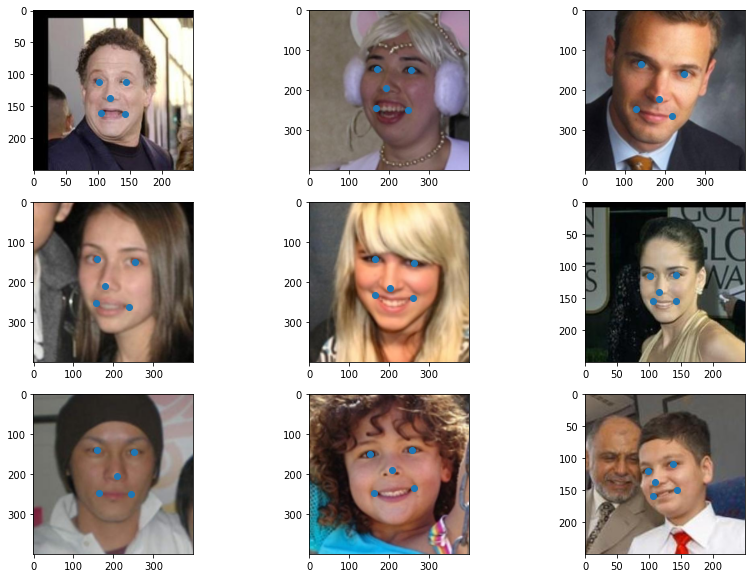

In [64]:
#visualising the dataset
images = []
all_x = []
all_y= []
random_ints = np.random.randint(low=1,high=8000,size=(9,))
for i in random_ints:
    img = cv2.imread('C:/Users/Acer/OneDrive/Desktop/Project/MTFL/images/' + train['Path'].iloc[i])
    x_pts = train[list('BCDEF')].iloc[i].values.tolist()
    y_pts = train[list('GHIJK')].iloc[i].values.tolist()
    all_x.append(x_pts)
    all_y.append(y_pts)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    images.append(img)
fig,axs = plt.subplots(nrows=3,ncols=3,figsize=(14,10))
k =0
for i in range(0,3):
    for j in range(0,3):
        axs[i,j].imshow(images[k])
        axs[i,j].scatter(all_x[k],all_y[k])
        k += 1
plt.show()

In [65]:
 #utility function to load and resize all ofthe images uniformly for network input
def image(im_path):

    img = cv2.imread(im_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (160,160), cv2.INTER_AREA) 

    return img

In [66]:
#utility function to calculate the newly w_h ratio after resizing the image so that keypoints can be transformed accordingly
def w_h_ratio(im_path):

 
     img = cv2.imread(im_path)
     img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
     (h, w) = img.shape[:2]
     r_w = 160 / float(w)
     r_h = 160/ (float(h))
     return [r_w,r_h]

In [67]:
# calculating the ratio of new_shape/old_shape
train[['r_w','r_h']] = train.apply(lambda x: w_h_ratio('C:/Users/Acer/OneDrive/Desktop/Project/MTFL/images/'+x['Path']),axis=1,result_type='expand')
print(train.iloc[0])

Path       lfw_5590/Aaron_Eckhart_0001.jpg
B                                   107.25
C                                   147.75
D                                   126.25
E                                   106.25
F                                   140.75
G                                   108.75
H                                   113.25
I                                   143.75
J                                   158.75
K                                   162.75
Gender                                   1
Smile                                    2
Glasses                                  2
Pose                                     3
r_w                                   0.64
r_h                                   0.64
Name: 0, dtype: object


In [68]:
# changing the (x,y) co-ordinates with newones after resizing
for x in list('BCDEF'):
      train[x] = train[x]*train['r_w'] #x_coordinate
for y in list('GHIJK'):
      train[y] = train[y]*train['r_h'] #y_coordinate

train.drop(['r_w','r_h'],axis=1,inplace=True)

(160, 160, 3)


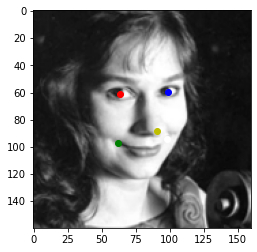

In [69]:
#visualizing the image with keypoints afterresizing
n = np.random.randint(low=1,high=6000)
row = train.iloc[n]
img = image('C:/Users/Acer/OneDrive/Desktop/Project/MTFL/images/' + row['Path'])
print(img.shape)
plt.scatter(row['B'],row['G'],c='r')
plt.scatter(row['C'],row['H'],c='b')
plt.scatter(row['D'],row['I'],c='y')
plt.scatter(row['E'],row['J'],c='g')
plt.scatter(row['F'],row['K'],c='w')
plt.imshow(img)
plt.show()

In [70]:
# loading, resizing and then storing all ofthe images in a numpy array
images = []
for row in tqdm(train.iterrows()):
         img = image('C:/Users/Acer/OneDrive/Desktop/Project/MTFL/images/' + row[1]['Path'])
         images.append(img)

images = np.array(images)
print(images.shape)

10000it [00:16, 613.57it/s]


(10000, 160, 160, 3)


In [71]:
#utitlity function to visualize the performance on train data of model
def viz_result_train(train_pred,result):
    random_ints = np.random.randint(low=1,high=8999,size=(4,))

    fig,axs = plt.subplots(nrows=1,ncols=4,figsize=(13,4))
    k = 0
    sig = 0
    for i in range(0,4):
        axs[i].imshow(train_images[random_ints[i]])
        if result[0]:
            reg_result = list(train_pred[k][random_ints[i]])
            sig = 1
            axs[i].scatter(reg_result[0:5],reg_result[5:])
    plt.show()
    if result[1]:
            res = train_pred[k][random_ints[0]]
            res = ohes[0].inverse_transform(res.reshape(-1, 2))
            res = res[0][0]
            res = gender_map[res]
            print(' '*8,end='')
            print(res,end='')
            res = train_pred[k][random_ints[1]]
            res = ohes[0].inverse_transform(res.reshape(-1, 2))
            res = res[0][0]
            res = gender_map[res]
            print(' '*21,end='')
            print(res,end='')
            res = train_pred[k][random_ints[2]]
            res = ohes[0].inverse_transform(res.reshape(-1, 2))
            res = res[0][0]
            res = gender_map[res]
            print(' '*21,end='')
            print(res,end='')

            res = train_pred[k][random_ints[3]]
            res = ohes[0].inverse_transform(res.reshape(-1, 2))
            res = res[0][0]
            res = gender_map[res]
            print(' '*21,end='')
            print(res)
            k +=1
    if result[2]:
        res = train_pred[k][random_ints[0]]
        res = ohes[1].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = smile_map[res]
        print(' '*8,end='')
        print(res,end='')

        res = train_pred[k][random_ints[1]]
        res = ohes[1].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = smile_map[res]
        if res=='Smile':
            print(' '*20,end='')
        else:
            print(' '*15,end='')
            print(res,end='')

        res = train_pred[k][random_ints[2]]
        res = ohes[1].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = smile_map[res]
        if res=='Smile':
            print(' '*20,end='')
        else:
            print(' '*15,end='')
        print(res,end='')

        res = train_pred[k][random_ints[3]]
        res = ohes[1].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = smile_map[res]
        if res=='Smile':
            print(' '*20,end='')
        else:
            print(' '*15,end='')
        print(res,end='\n')

        k +=1
    if result[3]:
        res = train_pred[k][random_ints[0]]
        res = ohes[2].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = glasses_map[res]
        print(' '*8,end='')
        print(res,end='')

        res = train_pred[k][random_ints[1]]
        res = ohes[2].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = glasses_map[res]
        print(' '*15,end='')
        print(res,end='')

        res = train_pred[k][random_ints[2]]
        res = ohes[2].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = glasses_map[res]
        print(' '*15,end='')
        print(res,end='')

        res = train_pred[k][random_ints[3]]
        res = ohes[2].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = glasses_map[res]
        print(' '*15,end='')
        print(res,end='\n')

        k +=1
        
    if result[4]:
        k = 5
        res = train_pred[k][random_ints[0]]
        res = ohes[4].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = mask_map[res]
        print(' '*8,end='')
        print(res,end='')

        res = train_pred[k][random_ints[1]]
        res = ohes[4].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = mask_map[res]
        print(' '*15,end='')
        print(res,end='')

        res = train_pred[k][random_ints[2]]
        res = ohes[4].inverse_transform(res .reshape(-1, 2))
        res = res[0][0]
        res = mask_map[res]
        print(' '*15,end='')
        print(res,end='')

        res = train_pred[k][random_ints[3]]
        res = ohes[4].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = mask_map[res]
        print(' '*15,end='')
        print(res,end='\n')




In [72]:
def viz_result_val(val_pred,result):
    random_ints = np.random.randint(low=1,high=999,size=(4,))
    fig,axs = plt.subplots(nrows=1,ncols=4,figsize=(13,4))
    k = 0
    sig = 0
    for i in range(0,4):
        axs[i].imshow(val_images[random_ints[i]])
        if result[0]:
            reg_result = list(val_pred[k][random_ints[i]])
            sig = 1
            axs[i].scatter(reg_result[0:5],reg_result[5:])
    plt.show()
    if sig:
        k += 1

    if result[1]:
        res = val_pred[k][random_ints[0]]
        res = ohes[0].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = gender_map[res]
        print(' '*8,end='')
        print(res,end='')

        res = val_pred[k][random_ints[1]]
        res = ohes[0].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = gender_map[res]
        print(' '*21,end='')
        print(res,end='')
        
        res = val_pred[k][random_ints[2]]
        res = ohes[0].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = gender_map[res]
        print(' '*21,end='')
        print(res,end='')

        res = val_pred[k][random_ints[3]]
        res = ohes[0].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = gender_map[res]
        print(' '*21,end='')
        print(res)

        k +=1
    if result[2]:
        res = val_pred[k][random_ints[0]]
        res = ohes[1].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = smile_map[res]
        print(' '*8,end='')
        print(res,end='')

        res = val_pred[k][random_ints[1]]
        res = ohes[1].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = smile_map[res]
        if res=='Smile':
             print(' '*20,end='')
        else:
            print(' '*15,end='')
        print(res,end='')

        res = val_pred[k][random_ints[2]]
        res = ohes[1].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = smile_map[res]
        if res=='Smile':
             print(' '*20,end='')
        else:
             print(' '*15,end='')
        print(res,end='')

        res = val_pred[k][random_ints[3]]
        res = ohes[1].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = smile_map[res]
        if res=='Smile':
            print(' '*20,end='')
        else:
            print(' '*15,end='')
        print(res,end='\n')

        k +=1
    if result[3]:
        res = val_pred[k][random_ints[0]]
        res = ohes[2].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = glasses_map[res]
        print(' '*8,end='')
        print(res,end='')

        res = val_pred[k][random_ints[1]]
        res = ohes[2].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = glasses_map[res]
        print(' '*15,end='')
        print(res,end='')

        res = val_pred[k][random_ints[2]]
        res = ohes[2].inverse_transform(res .reshape(-1, 2))
        res = res[0][0]
        res = glasses_map[res]
        print(' '*15,end='')
        print(res,end='')

        res = val_pred[k][random_ints[3]]
        res = ohes[2].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = glasses_map[res]
        print(' '*15,end='')
        print(res,end='\n')

        
    if result[4]:
        k = 5
        
        res = val_pred[k][random_ints[0]]
        res = ohes[4].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = mask_map[res]
        print(' '*15,end='')
        print(res,end='')

        res = val_pred[k][random_ints[1]]
        res = ohes[4].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = mask_map[res]
        print(' '*15,end='')
        print(res,end='')

        res = val_pred[k][random_ints[2]]
        res = ohes[4].inverse_transform(res .reshape(-1, 2))
        res = res[0][0]
        res = mask_map[res]
        print(' '*15,end='')
        print(res,end='')

        res = val_pred[k][random_ints[3]]
        res = ohes[4].inverse_transform(res.reshape(-1, 2))
        res = res[0][0]
        res = mask_map[res]
        print(' '*15,end='')
        print(res,end='\n')



In [73]:
train_images = images[:9000]
val_images = images[9000:]
keypoint_op = train[list('BCDEFGHIJK')].values
train_keypoint_op = keypoint_op[:9000]
val_keypoint_op = keypoint_op[9000:]

In [75]:
ohes = []
categorical_cols = ['Gender','Smile','Glasses','Pose','Mask']
train_categorical_ops = []
val_categorical_ops = []
shapes = []
for name in categorical_cols:
           ohe = OneHotEncoder()
           train_categorical_op = ohe.fit_transform(train[name].iloc[:9000].values.reshape(-1, 1) )
           val_categorical_op = ohe.transform(train[name].iloc[9000:].values.reshape(-1, 1))
           train_categorical_ops.append(train_categorical_op)
           val_categorical_ops.append(val_categorical_op)

           ohes.append(ohe)
           shapes.append(train_categorical_op.shape[1])
           print('[INFO] Done For {} with shape:{} '.format(name,train_categorical_op.shape[1]))


[INFO] Done For Gender with shape:2 
[INFO] Done For Smile with shape:2 
[INFO] Done For Glasses with shape:2 
[INFO] Done For Pose with shape:5 


In [77]:
print("Training images: ",train_images.shape)
print("Validation images: ",val_images.shape)

print(train_keypoint_op.shape, val_keypoint_op.shape)

train_gender = []
val_gender = []

for e,i in enumerate(train["Gender"].iloc[:]):
    if e >= 9000 and e < 10200:
        continue
    else:
        if i == 1:
            train_gender.append([1,0])
        else:
            train_gender.append([0,1])

for i in train["Gender"].iloc[9000:]:
    if i == 1:
        val_gender.append([1,0])
    else:
        val_gender.append([0,1])
        
train_smile = []
val_smile = []

for e,i in enumerate(train["Smile"].iloc[:]):
    if e >= 9000 and e < 10200:
        continue
    else:
        if i == 1:
            train_smile.append([1,0])
        else:
            train_smile.append([0,1])

for i in train["Smile"].iloc[9000:]:
    if i == 1:
        val_smile.append([1,0])
    else:
        val_smile.append([0,1])

train_glasses = []
val_glasses = []

for e,i in enumerate(train["Glasses"].iloc[:]):
    if e >= 9000 and e < 10200:
        continue
    else:
        if i == 1:
            train_glasses.append([1,0])
        else:
            train_glasses.append([0,1])

for i in train["Glasses"].iloc[9000:]:
    if i == 1:
        val_glasses.append([1,0])
    else:
        val_glasses.append([0,1])
        
train_pose = []
val_pose = []

for e,i in enumerate(train["Pose"].iloc[:]):
    if e >= 9000 and e < 10200:
        continue
    else:
        if i == 1:
            train_pose.append([1,0,0,0,0])
        elif i == 2:
            train_pose.append([0,1,0,0,0])
        elif i == 3:
            train_pose.append([0,0,1,0,0])
        elif i == 4:
            train_pose.append([0,0,0,1,0])
        else:
            train_pose.append([0,0,0,0,1])
        
for i in train["Pose"].iloc[9000:]:
    if i == 1:
        val_pose.append([1,0,0,0,0])
    elif i == 2:
        val_pose.append([0,1,0,0,0])
    elif i == 3:
        val_pose.append([0,0,1,0,0])
    elif i == 4:
        val_pose.append([0,0,0,1,0])
    else:
        val_pose.append([0,0,0,0,1])
        
train_mask = []
val_mask = []

for e,i in enumerate(train["Mask"].iloc[:]):
    if e >= 9000 and e < 10200:
        continue
    else:
        if i == 1:
            train_mask.append([1,0])
        else:
            train_mask.append([0,1])

for i in train["Mask"].iloc[9000:]:
    if i == 1:
        val_mask.append([1,0])
    else:
        val_mask.append([0,1])
        
        
train_gender = np.array(train_gender, dtype = "float32")
val_gender = np.array(val_gender, dtype = "float32")
print(train_gender.shape, val_gender.shape)

train_smile = np.array(train_smile, dtype = "float32")
val_smile = np.array(val_smile, dtype = "float32")
print(train_smile.shape, val_smile.shape)

train_glasses = np.array(train_glasses, dtype = "float32")
val_glasses = np.array(val_glasses, dtype = "float32")
print(train_glasses.shape, val_glasses.shape)

train_pose = np.array(train_pose, dtype = "float32")
val_pose = np.array(val_pose, dtype = "float32")
print(train_pose.shape, val_pose.shape)

train_mask = np.array(train_mask, dtype = "float32")
val_mask = np.array(val_mask, dtype = "float32")
print(train_mask.shape, val_mask.shape)

Training images:  (9000, 160, 160, 3)
Validation images:  (1000, 160, 160, 3)
(9000, 10) (1000, 10)
(9000, 2) (1000, 2)
(9000, 2) (1000, 2)
(9000, 2) (1000, 2)
(9000, 5) (1000, 5)


In [78]:
gender_map = {1:'Male',2:'Female'}
smile_map = {1:'Smile',2:'Not Smile'}
glasses_map = {1:'With Glasses',2:'No Glasses'}
pose_map = {1: '-60',2:'-30',3:'0',4:'+30',5:'+60'}
mask_map = {1: 'Mask', 2: 'No Mask'}

In [79]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
            self.val_log_dir = os.path.join(log_dir, 'validation')
            training_log_dir = os.path.join(log_dir, 'training')
            super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)
    def set_model(self, model):



        if context.executing_eagerly():
            self.val_writer = tf.summary.create_file_writer(self.val_log_dir)
        else:
            self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)
    def _write_custom_summaries(self, step,logs=None):



        logs = logs or {} 
        val_logs = {k.replace('val_', ''):v for k, v in logs.items() if 'val_' in k}
        if context.executing_eagerly():
                with self.val_writer.as_default(), tf.contrib.summary.always_record_summaries():
                    for name, value in val_logs.items():
                         tf.contrib.summary.scalar(name, value.item(), step=step)
        else:
            for name, value in val_logs.items():
                summary = tf.Summary()
                summary_value = summary.value.add()
                summary_value.simple_value= value.item()
                summary_value.tag = name
                self.val_writer.add_summary(summary, step)
        self.val_writer.flush()
        logs = {k: v for k, v in logs.items() if not 'val_' in k}
        super(TrainValTensorBoard, self)._write_custom_summaries(step, logs)
    def on_train_end(self, logs=None):


         super(TrainValTensorBoard, self).on_train_end(logs)
         self.val_writer.close()    

In [80]:
inp = Input(shape=(160,160,3))
#1st convolution pair
conv1 = Conv2D(16,kernel_size=(5,5), activation='relu')(inp)
mx1 = MaxPooling2D(pool_size=(2,2))(conv1)
#2nd convolution pair
conv2 = Conv2D(48,kernel_size=(3,3), activation='relu')(mx1)
mx2 = MaxPooling2D(pool_size=(2,2))(conv2)
#3rd convolution pair
conv3 = Conv2D(64,kernel_size=(3,3), activation='relu')(mx2)
mx3 = MaxPooling2D(pool_size=(2,2))(conv3)
#4th convolution pair
conv4 = Conv2D(64,kernel_size=(2,2), activation='relu')(mx3)
flt = Flatten()(conv4)
dense = Dense(100,activation='relu')(flt)
reg_op = Dense(10,activation='linear',name='key_point')(dense)
gndr_op = Dense(2,activation='sigmoid',name='gender')(dense)
smile_op = Dense(2,activation='sigmoid',name='smile')(dense)
glasses_op = Dense(2,activation='sigmoid',name='glasses')(dense)
pose_op = Dense(5,activation='softmax',name='pose')(dense)
mask_op = Dense(2,activation='sigmoid',name='mask')(dense)
model = Model(inp,[reg_op,gndr_op,smile_op,glasses_op,pose_op,mask_op])
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 156, 156, 16) 1216        input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 78, 78, 16)   0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 76, 76, 48)   6960        max_pooling2d_12[0][0]           
____________________________________________________________________________________________

In [81]:
# These losses will be added in keras at the time of optimization
# reference : https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438
loss_dic = {'key_point':'mse','gender':'binary_crossentropy','smile':'binary_crossentropy', 'glasses':'binary_crossentropy' , 'pose':'categorical_crossentropy'}
# sicnce the main task is keypoint detection, hence giving more weightage to this one.
# other important task in pose estimation
loss_weights = {'key_point':7,'gender':2,'smile':4,'glasses':1,'pose':3}
metrics = {'key_point':'mse','gender':['binary_crossentropy','acc'],'smile':['binary_crossentropy','acc'], 'glasses':['binary_crossentropy','acc'] , 'pose':['categorical_crossentropy','acc']}


In [82]:
model.compile(optimizer='adam',loss=loss_dic,loss_weights=loss_weights,metrics=metrics)

In [83]:
epochs = 40
bs = 64

In [84]:
start = datetime.now()
H1 = model.fit(train_images, [train_keypoint_op, train_gender, train_smile, train_glasses, train_pose], epochs = epochs, batch_size=bs, validation_data=(val_images,[val_keypoint_op, val_gender, val_smile, val_glasses, val_pose]), verbose = 2)

Train on 9000 samples, validate on 1000 samples
Epoch 1/40
9000/9000 - 8s - loss: 4133.9284 - key_point_loss: 585.1914 - gender_loss: 3.2522 - smile_loss: 2.3623 - glasses_loss: 1.3736 - pose_loss: 4.2904 - key_point_mse: 586.2396 - gender_binary_crossentropy: 3.2574 - gender_acc: 0.5214 - smile_binary_crossentropy: 2.3657 - smile_acc: 0.5288 - glasses_binary_crossentropy: 1.3744 - glasses_acc: 0.7572 - pose_categorical_crossentropy: 4.2990 - pose_acc: 0.6169 - val_loss: 1848.3375 - val_key_point_loss: 258.7815 - val_gender_loss: 1.3165 - val_smile_loss: 1.8254 - val_glasses_loss: 0.9192 - val_pose_loss: 5.7747 - val_key_point_mse: 260.0354 - val_gender_binary_crossentropy: 1.3212 - val_gender_acc: 0.4795 - val_smile_binary_crossentropy: 1.8343 - val_smile_acc: 0.4840 - val_glasses_binary_crossentropy: 0.9188 - val_glasses_acc: 0.6295 - val_pose_categorical_crossentropy: 5.7305 - val_pose_acc: 0.3010
Epoch 2/40
9000/9000 - 7s - loss: 988.2638 - key_point_loss: 139.6013 - gender_loss: 1

Epoch 11/40
9000/9000 - 6s - loss: 92.6068 - key_point_loss: 12.4718 - gender_loss: 0.5555 - smile_loss: 0.5925 - glasses_loss: 0.4221 - pose_loss: 0.4434 - key_point_mse: 12.4818 - gender_binary_crossentropy: 0.5556 - gender_acc: 0.7087 - smile_binary_crossentropy: 0.5921 - smile_acc: 0.6805 - glasses_binary_crossentropy: 0.4224 - glasses_acc: 0.8488 - pose_categorical_crossentropy: 0.4440 - pose_acc: 0.8353 - val_loss: 273.0014 - val_key_point_loss: 37.5937 - val_gender_loss: 0.6823 - val_smile_loss: 0.8464 - val_glasses_loss: 0.3557 - val_pose_loss: 2.2539 - val_key_point_mse: 37.3184 - val_gender_binary_crossentropy: 0.6835 - val_gender_acc: 0.6085 - val_smile_binary_crossentropy: 0.8434 - val_smile_acc: 0.5320 - val_glasses_binary_crossentropy: 0.3539 - val_glasses_acc: 0.8920 - val_pose_categorical_crossentropy: 2.2262 - val_pose_acc: 0.3850
Epoch 12/40
9000/9000 - 6s - loss: 78.8564 - key_point_loss: 10.5358 - gender_loss: 0.5430 - smile_loss: 0.5839 - glasses_loss: 0.4144 - pos

Epoch 21/40
9000/9000 - 5s - loss: 42.0748 - key_point_loss: 5.4481 - gender_loss: 0.4398 - smile_loss: 0.4643 - glasses_loss: 0.3474 - pose_loss: 0.2812 - key_point_mse: 5.4497 - gender_binary_crossentropy: 0.4397 - gender_acc: 0.7902 - smile_binary_crossentropy: 0.4642 - smile_acc: 0.7752 - glasses_binary_crossentropy: 0.3475 - glasses_acc: 0.8636 - pose_categorical_crossentropy: 0.2811 - pose_acc: 0.8922 - val_loss: 217.6105 - val_key_point_loss: 29.9609 - val_gender_loss: 0.6485 - val_smile_loss: 0.7732 - val_glasses_loss: 0.3641 - val_pose_loss: 1.7139 - val_key_point_mse: 29.6833 - val_gender_binary_crossentropy: 0.6497 - val_gender_acc: 0.6500 - val_smile_binary_crossentropy: 0.7755 - val_smile_acc: 0.5695 - val_glasses_binary_crossentropy: 0.3619 - val_glasses_acc: 0.8860 - val_pose_categorical_crossentropy: 1.6879 - val_pose_acc: 0.4780
Epoch 22/40
9000/9000 - 6s - loss: 40.0157 - key_point_loss: 5.1726 - gender_loss: 0.4455 - smile_loss: 0.4398 - glasses_loss: 0.3467 - pose_l

Epoch 31/40
9000/9000 - 7s - loss: 26.3871 - key_point_loss: 3.3434 - gender_loss: 0.3561 - smile_loss: 0.3512 - glasses_loss: 0.2958 - pose_loss: 0.1882 - key_point_mse: 3.3443 - gender_binary_crossentropy: 0.3560 - gender_acc: 0.8426 - smile_binary_crossentropy: 0.3512 - smile_acc: 0.8512 - glasses_binary_crossentropy: 0.2962 - glasses_acc: 0.8835 - pose_categorical_crossentropy: 0.1881 - pose_acc: 0.9306 - val_loss: 210.2225 - val_key_point_loss: 28.8234 - val_gender_loss: 0.7058 - val_smile_loss: 0.7963 - val_glasses_loss: 0.3604 - val_pose_loss: 1.8470 - val_key_point_mse: 28.5400 - val_gender_binary_crossentropy: 0.7075 - val_gender_acc: 0.6420 - val_smile_binary_crossentropy: 0.8011 - val_smile_acc: 0.5910 - val_glasses_binary_crossentropy: 0.3580 - val_glasses_acc: 0.8890 - val_pose_categorical_crossentropy: 1.8217 - val_pose_acc: 0.4500
Epoch 32/40
9000/9000 - 7s - loss: 24.4861 - key_point_loss: 3.0879 - gender_loss: 0.3475 - smile_loss: 0.3412 - glasses_loss: 0.2886 - pose_l

In [85]:
end = datetime.now()
print('\n\nTime taken to train the model: ',end-start)
#model.save('all_lossses_weighst_extended.h5')
train_pred = model.predict(train_images)
val_pred = model.predict(val_images)
print('MSE on train data: ', mean_squared_error(train_keypoint_op,train_pred[0] ))
print('MSE on validation data: ', mean_squared_error(val_keypoint_op,val_pred[0] ))



Time taken to train the model:  0:06:49.519498
MSE on train data:  1.8268354990774587
MSE on validation data:  26.805964352905185


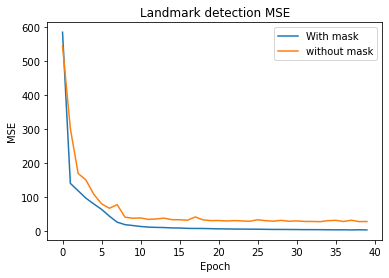

In [99]:
# plt.plot(H1.history['mask_acc'])
# plt.plot(H1.history['val_mask_acc'])
# plt.title('Mask Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='lower right')
# plt.show()


plt.plot(H1.history['key_point_loss'])
plt.plot(H1.history['val_key_point_loss'])
plt.title('Landmark detection MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['With mask', 'without mask'], loc='upper right')
plt.show()

In [98]:
H1.history['val_key_point_loss']
H1.history['val_key_point_loss'][0] = 545.01524
H1.history['val_key_point_loss'][1] = 300.99492
H1.history['val_key_point_loss'][2] = 168.70181

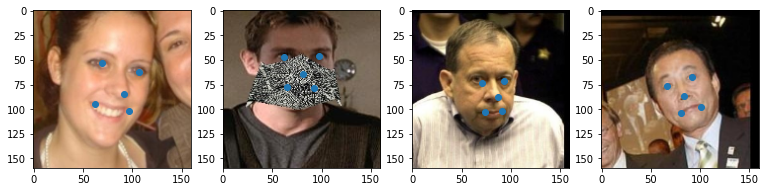

        No Mask               Mask               No Mask               No Mask


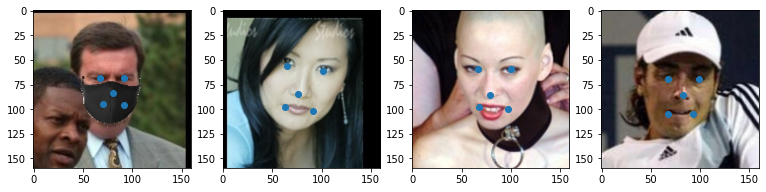

        Mask               No Mask               No Mask               No Mask


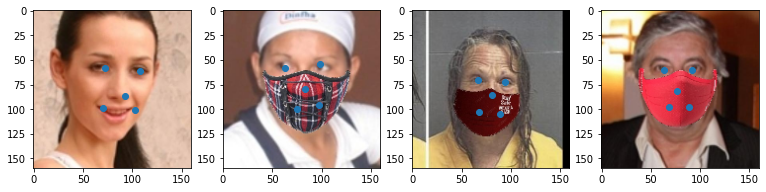

        No Mask               Mask               Mask               Mask


In [51]:
viz_result_train(train_pred , [1,0,0,0,1])
viz_result_train(train_pred , [1,0,0,0,1])
viz_result_train(train_pred , [1,0,0,0,1])

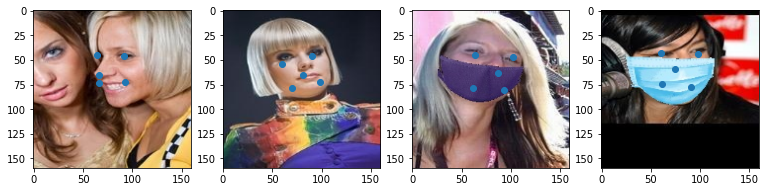

               No Mask               No Mask               Mask               Mask


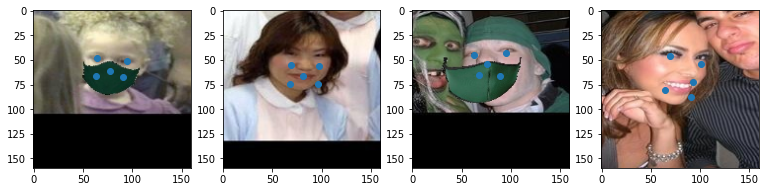

               Mask               No Mask               Mask               No Mask


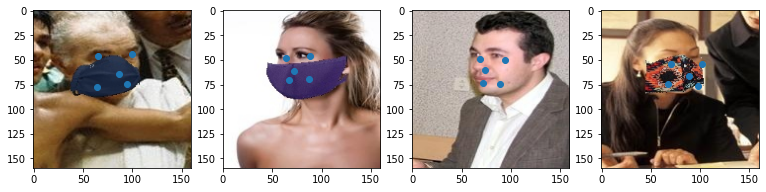

               Mask               Mask               No Mask               Mask


In [48]:
viz_result_val(val_pred,[1,0,0,0,1])
viz_result_val(val_pred,[1,0,0,0,1])
viz_result_val(val_pred,[1,0,0,0,1])

No Mask


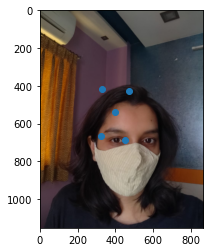

In [70]:
test_img1 = cv2.cvtColor(cv2.imread("C:/Users/Acer/OneDrive/Desktop/Project/face-dataset-4/train/RUchita/R12.jpeg"), cv2.COLOR_BGR2RGB)
test_img2 = np.array([cv2.resize(test_img1, (160,160))])
prediction = model.predict(test_img2)

x_h = test_img1.shape[1]//160
y_h = test_img1.shape[0]//160

reg_result = prediction[0][0]


plt.scatter(reg_result[0:5] * x_h, reg_result[5:] * y_h)
plt.imshow(test_img1)
print("Mask" if prediction[5][0][0] > prediction[5][0][1] else "No Mask")

In [42]:
reg_resultdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAANEAAAD8CAYAAADpCEEHAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAADcyklEQVR4nOz9Wax1SZbfh/1WROy9zzl3+IacKoeaq4fq7urqZjVbFNmUWxQHmRRFCx4gCZZsQzBfPMIGLNLvAvQkWC82QEi2aUgyRYiGRFiGCbLdpNUcWiSbFNndNVdW5Vg5fcMdzjl774hYflgRe+9zh8zsruryl0BG4uZ37xn2EDtWrLX+67/WElXl4/Hx+Hj87of7//cFfDw+Hh/18bEQfTw+Hj/g+FiIPh4fjx9wfCxEH4+Pxw84Phaij8fH4wccHwvRx+Pj8QOOH7kQici/KCJfF5Fvicif+1Gf/+Px8fhhD/lRxolExAPfAP4Y8Brw94F/TVV/+0d2ER+Pj8cPefyoNdEvAt9S1e+o6gD8JeDP/Iiv4ePx8fihjvAjPt+LwKuLv18D/pmrHxKRPwv8WYAQ/Ffu3buzfBe4rj0VyDkjgIibPqMcflyvfbccT0E1k1ICBRHBufIjgoi9BlCVt05/yPz3dFQ5uLblFaSUSTmTFYZhZIxpcV8yX9bhLzeM+UJEoGtb1uvOviFy+zfLfbzfkX/Phi6ey2LI4t5VlayZFBMxJlJKXLWY6nN0zrFer3Huw+uD37ntZdd1eXHBfr+/Nm0/aiG66blduydV/QvAXwC4d+9U/9gf/4OcnJwizk8LWXT6LCrz733fk3OmbVtEhJyzfebgR649FICcE3EY6C+3eMmsV4H1OrBqA20IiDhbfwqKI2eIWYkpo+qoit0OffMSVew7ZxeXXO4HLveZ777yBm+/85iM2OK3nQC8AwQR+5mvWed7V8WpIChtcPzUFz/P5z71Aj7YtdTvXv05eCgybwI3vXfjQ3sfN2D5bA4/v/xOBtTOp5BTYr/fc3Z2zrvvvsfjR4/Y9wOaFedcmXtn8wCMKRJjxDnHF77wOV588UUQuWGTvH4dh58Qls+q3n+W63PxX/4X/+WN9/ujFqLXgE8u/n4JeOP9vuCcYxxHHj18xPHpqQkHzDvt4j4FYbVaEWNkHEeapsE5j2oGWAiUTAtwOcQJbdfR+kAc9jhX3s8Zh+KLZkIE1ITIZ3CSiQk7LpQFD6CoMgmAlGtsvOPO8TFwiWrPpz/5HCkl3n3vMYpHxNm15XmDuE1r2CLPCEKMyte++V02qxXPf+IprqwBu4ZbBMmudv5MPTaq6I1nl+n+5m8vrvQmIbv6kirDMPDo8WPee+8Bjx49Yrvdk5MiYs/eefDeI87TNq1tQimSUcZxRFV58OARn/jEC3gv76te31fwl/Pxflr8hvGjFqK/D/yYiHwWeB34V4F//YO+tGo74hg5f/iQ45MT1us14mR6TkvLRxDa0ODFMcSE9+BcoJpKOdsDWmqmOhweUDQIQdZIHskpgRNyBucV5zzeyXQsp4L3nhgzfVRUHYogogfraFqYZfE13nGy2ZDKzvjZTz+HqvLewwtUs4lFVsSV5aoKk8my2DkBxE1W5W6f+Kdf+w5d13H/3hGiiuDAFRVq8m8azFXNuRAce2E6vopMmuXqUF2a1lIfgM3h8q1yPMGE0m5IODvb8o1vfJ3H5xfEVE1acN7hvMc7R2gamhAIIeC8J8ZI6rP9Xa7/4uKCi4sL7tw5vXJ9em2zsNObRkNuN+3KbTD98z5S9SMVIlWNIvI/B/4a4IH/s6r+1vt9ZxxHxsG0iveei/NzUoxsjk9Mzd90dwIhBMR7YkzTgrHd7boGKtdWvlt2aRHIkLPQp4RLkRDA4fAu2Ge8I6uagIkDUcYEWQFcEdKFD6WKFhNGgbYN3JFjhEsE4bOffhHldd57cGaCAYi6g2uc/bLZt5Dlw1bl8fkFv/m1b/ILX/4pNpsWUETzwXcn7XjD8WwaZu2pevMKuj6PihTvxhaoHgjgpNPKnHjv6fuBOEZUhBD8pCXX6zVN09A0zYE5673He49zrmxeZnU8ePCAk9OTSfsuhecmrXvbODSbmZ7VdXN0Hj/yOJGq/r9U9cdV9fOq+u980OdTTLz55ptcXFwA0HUd+/2eR48eEccR4MD8mE0VwTtfTDpHznmaeBMoMXPhir1t5lERIhdQ1xJzYBiFNGZyTGhOeAfeQ/BCE4RV61h1nlXjCI4JiPBXznm4aJUueO4cbTjqWk42LZ/91Avcv3uKaIacyDnbz1JzLp/lwsavQppVePu9R3ztm99hGOLBd6tJOx33is+4OOzB52/6ueX5mibNZQM5eJOD73Zdx/PPP49zbnrNe08omieEcOW4JvRt2+KcowkNlGt87733GIdx2lLrBrAcIgYSufKsi3Rcu4el0L2f8NTxozbnfsdDNfPowUNyysQYuXPnzuT3nD1+xPHxMavVGjc5x2UHL9aFmwTDzyaMZBBbHIhW696+q4qSi8oHdbZIhzzixxEvGecU7yA0DeIdmhV14J3SeCGM0I9KzNVptQeWkOm5STkjKE1wnB6vyCgpK5/59PMkTTx6fGnCpA4VcNgCFecmv3CeJ/u3WCnkDN977S2O1it+7HOfRLyfPit5CSbcZqsVD07mz3yYHV2rXTl99HZhExGeffZZ3vz+W5xdXJBSmgRnHEfbhLw/2CSrJhJVUgj0CGSl3+64PD+n6+4fmvcV9JObwaSrdtpVE9A2pfe/9ydeiDabDd2q5e233iLlxDAM3L9/n7ZtyTlzfn5OSpmjo6PJzq0mni6epffzbrf0BeruvRyq1aEu69R5sip9ioQxI5KQosWCmKahTLZXwXtFXGKMSkzlOAjiHCkbfOsMN5gg+CYETo83ZDXU6nOffonvfPc1zs4uyQJLo6Fq1YUXY/egFF/RFkJMyje//T1Wq45PvvCcgSKL+1+6LXDFlNHMjFx9MCh8DdWr/g8LIbx6DmC1WvGJ5z/Bxbe/g6qSUkJESCkRY5w+WwVIVUkxMvbDJGhVY56dnXH/6ftXQIKyQS7N1Sum6/ub9x9460++EDnv+Pmf/zLfffkVvvvKK+x2O/q+5+mnn+bo6IjVasV+vyPGyPHJCT74a5NodvrhbFQToj6A5ZhgzmwLybCvQNKWYdjjiIZAi5mMzjtcQdQyroAZMIxqGinZg/QI4oWcIOUMKuRUhFigDY57J0cIW8Dx2U99km9/7xXOzi9NZxnuavezMG+q6Tjb7tONsB0jv/2N77BZNTz91H0EmYTQwIpZFK9Cv7I43nLxX/0dbtjBl35Ffa0I+tVF+8wzz/D2O+/w6NFjUkp478kpEUuIoo6UbBNNY4RiVbRty2az4fT0lKefevpGMGGGcyaxmYCYxQVPmn0SuPIhC2vcvpE88UIkQNc4vvD5T3H/7h2+9vVv8ODtd9AxMj51nzt379G2K8Zx4NHDh5ye3KVbdbabXTlQXXxwuHNWn2n594FNrRlBSQjbPqF5NgMRQRyExtAiUcWrICHgRPEuM0RlGDMZcAjiPKigGk28pULj0HjH3eM1qntyhs98+kW+/d1XuLjcodmQJS3nnO5BzW6RIgmHYLPnYjfy3/z2d/iFn+u4e3xkX6kCONmXFb27LgjvZ8p8mM/UK6k68+pYtS3PP/ccF2dn5BhR5xHnIFvAdRzHKeAqInRtw2az5u7du5ycnLDZbMzv9Fc20MmUvjF6hGZFnM3BrSJyTdqujydeiOoIwfPMM09xfPz7+Pa3X+at779DP4zs+z1PPfU0bduhqpyfn5HSEZvNplhAhzvtEump/y53nqUwHSBYambesB/JQzGdcDgfEVvRht4VxND8Dl/ACxPnYcykyaQUHA4tLIvpOgSC95weH6F6Scotn/3Ui3zne6+xuxzswlRQlTmO8wEWlyo8PLvgt772bX7fl77IatUcaJl5zAe6yfSaj3e7n3P1/YNLu+LsLwXw6aee4p233+bBg4eTwFThcc7RdR1HR0ecnp5yenrKet0dIHXTs7ziJ874wSEYMm9A9Trl2hR+WFTvIyFEdRGLKOt1xxe/+OPcuXOHb3772+z6PeOYePrpp9lsNrRtx263YxxHNqfH+BAWElQOeLDhzn5CneQqSLPJZwfIeWToM1EjompIT0X4nB14gmSdybC4onkKlJDHPJkJzgnqHFqCizBvfG2AeycbFLuWz3zyRV7+7uvs94OZpuquLQqZ3ZB6m7PPII7vv/OIb3znu/zUj3+Oppmd9fnzZXOQ2Wec3rtFcK5C5O/7+YVGuCqkTdPw/PPPc3Z2NoUluq7j5OSE09NTTk5OWK1WU3yohsyuBo7zldNeNdVvu77qm34YH+jq+GgIkUJdhIISgvDJl17g9OSEb37zW7z1xlsM/cjTTz3NnbunNG0gxpHHjx5zfHxM23WAzrvilYmqQMTBwyiTr2U7U6cWE0qRnCK78k2LKxV6jgqCo2kEcVKcc8U7R9sIYOZG3yeiWgzFOzF0b4kHm41F8HD3+IicDW37zKeeN0HqIxbEqrvB1Z+rE2jIXlLlO69+n83mmM99+hMEJ+QSP6qLyBa2+YK3+TvL8UHmXF2XE2p38M7iEkW4d+8ezz33HDEm7tw55fj4hK7rSvzILcIE83eW1zHrUDuXPevrvtzN93NoBE/G5wdjKk++EJnTzOSjaAnoIcq9u6f83Jd/lu9871Vefe1V9rstw/gs9596iqZpyCqcnZ0ZALFezdBwGcV6Otixa/wICqG1mkwFStWc0ZyJMbHbFQFTAy5UhazGbmgaMzXqE7eF4BGJdsIxkUosxXvTtMlkZ3Z/RfHBcedkQ9aEyoZPvfQ833v1TfoS/xGRAg7Yj9ZoPMvlMBtVY0x8/VvfYb1qjRqEXhM9Kf7RDJtfD0BeHbdpqvpe3YzmF5fCRZmjwGc+8xmARQzv6gY3C+PtZqV9Tg9em03NW81UuboFXbWTb94oPgJCJIhTNFWzqk6I3VzbNXz+C5/l7r07fO1rX+O73/0uu/2eZ555htXmiK5t2W63DOPI8clxgaOXkwrLZVYf1pIVnFPCKWhKRgMqUCwIfZ8RF0HMzMpIYTEobevMZBMAM/+aUO0Q2I+JFDPiMOQOiDHPmlFN87aNcO9kTUbJd45I+RN879XvGwS8lLpy3MU/B2/UzWjbD/zW175N2zXcv3tyYBrVObnKmLsJebttMR6edTrA4Wc1HyzsOpqmuabdrlN3Fue3V8obhwTUD/LdDq/wA1SOXBWoeTz5QgQEyQyYSQN1Q3MFcct4EZ59+ilOvvLzfPPb3+HN199gv93ziRee5+T0hK4JjGnk8aOHnJwc0zTdpGFYwJciOj0UAbxz5TOOSCQNAykq3s8+QxwTe+dRiag4snpiFmKOJNWikSrD20yk4BxdyKCeQZUxWVqEc2KfrX6YWlARwDctTx1j6ureCTknXn3tTcaYC7BRFr6vvLDDRV91U12QZ5dbfusbL/OVn/kJjo5aVGcNbOulmM9XfJ7bYOzlOABtls+yTPeMeC3NqytATv3OByGDFTgoz+2DtNThEKbN5TZnSK4DDlfHEy9EwcPR2pN3loNj/kNhU1P5XfbA1+s1X/ziF7l77z7f+ua3uPz2JS+++CJPP/30tMOdPz5jvTlmtV5jlpDpcHuYADNUTDXtiiXS7yOXF3s2mxVNYzB1zpYfNAyxLAKhTQ0ph/Ke0oSAD+U6C6oWvCvn8jAoYyyLqaRC5VRIrF4mYGPdNTx17xQenaH3T8k58dobb2HK8XDBLzXrRHHhcHG9995Dvv7Nl/mZn/4xGu9tF58V5bXPXx3v5w9dRcOAaykSHwa4uHaMG4AMXWi5q4d5f61ZfKfyrG8Uo+VGcMtUPPFCtOoCn3iqwT0aON86+l7Judy45rJTzHfnvfDSi89z984dvvHNb/K9736P3W7H888/z6rraJuG/XZLGkdjOSz8FlhOupsmzeTMsd8PjKOyvexZb1a0rcc7g8VTcgxDRjUSM8QEufPEqHRNJjQmOCJhWgjeKw2g6kAzCaP9eAHnMdMQMw1RxTlh3TieOj0i5cyzT98DhdfeeHdiQWsJpE73w+2Ak6ry2pvvcHS05guf/dQkwGYh5mvC8TuFvMubB7/eLDizLrltXD338vd8xTw7YCdc+fx1367MULVKboC6F1+48eUnXoi61vOlH3+WV998zGtv73h4pmz3RStVs0dAVLBt1B7IyfGGL3/pS7z26mvmJ12aVjo9PaVpPCkOPH48cHxyQts0gAVCKwpYTQ4R82kkZ+J+ABxjFNLFyHoN600gOIWcydkxJiUNiaRCKn5RTJkmOZoGGh9xfrb1nQiNF6TxDGRU5xCx8xB1vhaKebVuG565e8K7j8555pl7pJR48/vvFLIoaFIDG8rxmeADJrOP4ugPOfOtl19j1a341EvPgtNJW9ZrXJpnHzZ2AlxTC3m5PPXQgLrq8N/mB12H0rmyS8yfu0kYPowfNx+FBfp5+3jihcg7+PTzdzhZBe6ebnnljQvefm/gci/GBEhGylxY/ZMTG7zjM5/5FPfu3eGrX/8G3/rWt3jxxRd55tln8CGgqlycn7HZHNF13XTOGnibTBI1NvnYj1R7J2dlux3JCscnDucNAkczZGEYoqWBJ09qHGNUmghtk/HB4aWmn5sP470QABUzDy3vSQgY86JiKZX1sOkanrpzguo5zz1zj5wSb73zHqk611lKHlTZCFj4O9U+LX5hPya+/u2XOT5Zc//e6SGIdkWAru7kN8WHrgnaTVpgOb9l41t+d0JGF9+78fwwo5RX/KHbBHIJoMxzwuF3l5f/ARvHEy9EqkrnE88/s2GzDpxsAvdP97z6xpaHFz0uimmGKkwHQUib3Dt3Tvm5n/sy3/veK7z++utcbrc8/8LzrFdrVquVAQQx4nxzELOvhqKq0PcjKeniVUCF/W5EEE7uBIKfF7uC+UoYIBKSmXgpOkIDIQihML/FOUQU7wXLbIUYC3G1AA5ZLa4kqoamqXC0atDTDTlnnv/E06Sceevdx5ONz8GCnrfsKTqvhhiqCufbnt/82rf4ypd/ipPNetJU9Rncxpe7+qxuev0mISoTe+PzXv5+Na5zzaST5e/VGpn9wXr++vfh95lR7Ksmff2s3GweLscTL0TjGOn7LW2z4s5JQ9udsFk1nGwaXvn+OW89GLjcw37IjCmBZiov2xWnUURYtYEf+/xneOapu7z83Vd45eWXef7557l7/x6np3cMgYtmSlUfqM5wUmV/ubXjHcQSjAQ5DInzsz0nd49ofQ0K20NKyUyslLX8ZEJ2hORog8O7jHcZ8YJz3kI+zoFPpo3KOvEiJIUk8+4tCCfrFQ7HWw/PeP65Z0lJee/hI4vDFlpRTY+d18kEok/rWHG88+Ccr37jZX7up39sytX5MAHXq+NA2G4TFJ210fv5RB8IPhw6PuhtabiHH6NAuxP6JtgmXN/PFWFRszBUbvf9nnghevfBBX/nN17mKz/9SY6OVqybwIvPbjg98tw5DTz9zpZX3tzy4DFc7KGvqaXOsk5tnkwYnBPu37/P8fEpr7/+Bg/ee0BWJYSG1eYIWexqk0ZS0JzYXVwWK+jmhRTHzMXjLUd6xOqoA1d33xI3SkZczVlIKROTIyVH8JbE573VE3BlwRsqaF6EKw4vzq4rUfxBUSQLm3XLM3qC6hkvPf8MmhPvPTqfNZJkxNdFUY41+TyL+1XHG2++zenRmh/73Gfw/sMLz22I21WUb2kiz6/rwdzXsaT0LDXSNf+sHvMKyHQwJo1SN1aKxbD8ro3JLEfIQBQhJke+JcP3iReivk/8X//S3+VrP/8af/QPf4n79zru3z3h/mng5Kjl3knD/dOWV9/c8frbex5ewnYfrQIP1Wookw8g0LYtn/nMZ7i8vCTmSAiBnBNLkNNoPyW9YYj0l7tpst308OwfO7aQI1ye9eQMm5MO590kiapmcuasJC/4bFoqeEfjHSEoPivOmblmQWYjskK1rkpODXPaeUYJwMmmRXWDKLz0/LPknHlwtrXPoVMinnNu2nlRFpWS7N+YhG+9/Dqnx8c8/4lnq1V4gGR9EBx9IEgsNc7yvQ+jMQ4/c1XQloHm6h/dBolXk64+CzBhqUKkGBoqzmJ6WRxDgvPdwPmuZ0yZIcYbr/OJFyJVZXuZ+NVf+za/+dVXubt2/Jv/2i/zY59/nqZtefb+EUfrFSfHK+7c2fK917e882DgbD/Sx4hmg31lWjygGlHF2MzSESaem5k1ZYpJalV8Hj84ZxjSLDx1iPHmXEkvB0ET7C8HclY2xx2hmRHDXPwArfEl70gukwMkFVyC4DPBKd5VZkUNSEIVajufFvBBSU7xwOlmBQpZMy++8AlSepPHF1sUX3h2RaCcZe5qlaJpW7aNZz9Gvvr177Jer7h357js0ua4VzPwwz672cdkmoey/Ks19WFXwiQE8//LY6gbwtJmrRqsfrvkhhk9q4QDFLIIKo6UYUjKdhjYj5E+ZvoxErOBVstY29XxxAtR8J5f+gNf5MGDd/nGV7/PaxeX/N//yt/nX/nTP89PfOFF1ivleBVYPb/h5Chw5zjwvdcvef1teHDp2A+JmPKE9ky7ToHIvQ9m+8NEz1luz3lIPHz3wcK012lnrv8tF5UIiDrGXeY87jk+WdN2rtjqduyUTTNozmRn1xKTw/lM8BCc4L0ddRx6drstJyd38KGdz4NM/lOtDuSBk+N14e+d8dILz5Fef5OLbT/dk5ZF4SbrbuG3FEdOFR6dX/Cbv/1Nfv7LX+ToaLXwwi2L1+71ZoDh4LVrfpHt/O59NNq1Y9RrWwhQNbXlyueWIMhBwDcr4oLNF2YV7IaByyHRj5HLXW/p++IRH0ATCcs3yinjJNyqO3+ktbh/N+Oo8/qHfuIOn/rks1xcDDx6eI6I4969jl/6Az/GP/cHP89zz9wltA3Ot+x2mTffO+f1t7d87/s73n00crnL7IdMSqX+nFqA1NIW5gozOEF1LsAYU+bR24955duvQjLnvg6L8Ryyi6d/i1bKgG8cm01Du27ALWzw6Tg6Q93O/u53ey4vL3j8+IzL7ZZhGHjpxRf43GdfoikxreVTy2IIYE6gRXs+fHzBO48veXSx53uvvcl2NwCFXS6V4lN37qqJSjmxcnSP8OmXnuNLP/UFmiaU8EFlcCxRv8NhpmYVtOVHZr7clAw4f2sSjCtHu/H/ky6b/LnK8XccHEZM4yQVhjExJmXfR853e6JaJrJioI1fmNGII5WzpGSa+7u/8Wvszx9d051PvCYCYd/Da6+8Q7fqOD5aMwwDu33mV/7W1/jat7/LH/3ln+Vnf/KlQp1veem5EzarwPG64Y23t7z+zo5Hl8p27xjGRM5x8i3QZMIA0wNBhaSZ/fmet199C0n1AS0vS8oarA76otJQ0VIO0KhszwdSTKyPOvDzUrBUbVsANfVit9vx8svfZbvd4V2gW69IOfPy995AVfnc5z6JDw5ZsrXVUh1EzK5vnHL/dIMWJO/TLzzPK69/n+1+j+bKs8uTCTrbXDMEbp+AV954m81mzRc+90kab2DHFck4GFovaPrrUNhuYh7MltKENiy+N79+tVaCVqEs2jMD3gUQxxAz+yGx7yO7fmRf8rikaKKoyUy5nHA+IBjo4/y8CSggYkmWVjDl5hX6xAuRCBwdrTg9WhmDGohxZH20Yhwir77a8x/8R7/OL/7c9/kjv/QTfPKT99msjnj67orNynN67Llz6nn9rR3vPBh5fJkYc0MsTr49q5I/U0wMzUrsR956/fsM+4EpSY2rQnNYBovF+8hcoyBnZXfZk7OyOl4hBQafrPzFzt22Hc888wyvvfYGqpQqn5bC8OorrxMCfOYzn2JZ0O0wiGlCErzj7snGnGiFF194hldff5P9PqK4Aj4ZancoEstFboVWvvWd77FZr3jphWcN9LgyFwfjGnDwIQCE8v9DNG9OpqsLemlS1/9nFWKGMWZ2+4GYenb9wDAmYjLmCFLSzQFSRpyQVPFNU8xpW1dNaHDelQIyMiG7IfgJ2btpfASEyC58jAONb+j7nvVmAyolpz4z9MKv/to3+ea33+Cf/6XP85Uvf4579++wXnW89Ilj7px23L/T8fr3d7z9KPLgPHJ2OdD3dbcpTncheqaUeef773D+8JzqzLMQlskXQA810PsMVcd+F0lpz/qkxTdXaftFuYlw7959RDyvvfo6fT/QtIF7d+/xzP273LlzbJVXnV45/vTbdI2Ng7snK7JGoiZeeuE5XnntLfohzUIw4b3LOV8sfYV+yHztG9/l+GjFvbunHwr2nh3xq9d5g3AtULL61tKfqRvRTF0y82s/DFzu9lxsB/bDSM4gEkhqlWqruZo1TShn9WUBUk6gMlduaszv8b4kWJbnmnVulnDTeOKFSFXpmo4UB8Z+SwiBtmkZ00jOmXffO+P05ISn7x/z4OGOv/JX/wn/+J+8wVP3V/zpP/kLvPDcPU42jlW74fio5e6DyBvv7HnrXXh8YTayqhWZz0nJKfPovTPe/f4jyO7arlvpJabma0C2/gsszKw6JhNGYegHNCc2x2tC58gyi5KWRSfiuHv3LiEEYowcHR+xWa/pGkcIkNOyWP10lnIQqHETVcGJcvd4Y6xwdcRPPMcb33+bYYyW66SUwiuy2GjlQJBUlPPt1hgNP/tTbNZtWdAz0fXgnqvDP13XLdppYUlqBvLsM2UtFZEAxDEmuNz1XFxesOtHI/iWY2RAxFPpk4763Ao3owip1fY2lNaXOCI11Vxt87QCKVh4odxTaByqxVe6YTzxQgRwcX5B23qcGD2n73tC2zCOhjTFFNHseeruXR6dXfBbX3/bHPIY+TN/6ud47uk7tN2ap+82rFcNm5Vj0yrff3fg8eXAmIQhWtr2xcML3njlLeKwqOYjy0Ui84/U1PDZJ7ptLAVpHDIXZztWRx3tKiBl05yhbFtIx8fHc2xHtdQesIXvVIwyNPlmi5OpeQy2poTGee6dHBmtT4H8FG+98x5Nu2aMmWEc52IncihAM2ypvPfgMd/41nf56S9+gRAOUbrrvLjD15caaAIXKADBZMa5UsAyM8bEdj9wsd2x60cud73V8CtmlSuVUq0wzFLb1fmq81CqnoYwgQaV9R2cB+9ME4nDOSs9Xcm78yGvIH1XxkdCiHywxLbgPcMwoKoM/chuN9jCyNnanKTIqvU0/hgnwt/79dd5+90L/sh/68f50k9+lpPTDZu24cVnWroms+6EN99JPDyPgGd/kXjjlbeJu4jDHZhwdSyJjsvaDLcJ0dXoekX/UoTtWU9KkdVRO9vsZSxjLFW4UoHFVTM+O7KzBMFaPmuBApfro9CGlM4p90/WBu3nhMOx2ycGb/2YhhSZA/ICUuNRYrXH1epLvPrG26zXBjR4JxUgKxvO8tpvF6D646SaW0aC7YfE+eWW84tLg5xTMt/IebQKQy37fCV9vAqPLCr/5MyMQpayaPWZ1XLFUmu0i0edFQwU50gl83a5id2ScfTkC5F3wmrV4Z2w217gvSMncKEBSrF6A9mIY6JpWvb9OcdHHSi8927mL/2Vf8rXvvSAP/wHvsAnX3qabtVx79RqLoRGCG/3bF/b8b1vvsb2bG8nXmofWZouh4Jz9febxhy3WP5tTPD95UiOsD5ukVL0sdQ3mU5XkTvjd5XvpmzM8ZSNMlQhcpi/rLCUi8Y77p9sICtePQ/YobuBddcSd7Vmg5k64tupHl/OmRqIVYVvv/wKx5sNLzz/zBXsbSEs6IQaUuD+KnBWBVbpx5GLyz0Xlz37/cC+H8jFrDJgxkNBx5w4u65J8y4FyJWaDHPduaQ6lSAWcYZaNo1NyCLnqm48zgs4SNmAFzMDSzYAAeR2StETL0SqyrDfWWF453HOuGeXuwv2+9EeuvfknCZe2t079zg7O6MJDTEJj88Sf+Nvvsxvf+shf/AXf4Kn7qx5550zdr1y7+l7vPdg4Df/yVs8em9nO3fZ6Q78nCua4ibtc5Mg3UpDqSBtUvrdQE6JbtPQdMZUONRCppWySMlbKmkUKoYuJcV7xXlLqag+TT1VNa2cwCoE7p+ckJPn7HxPEIEQ2KxW9HFcXDhT6SrIE3Ih4ujHzFe/+R1W6xX37h1f74qwsAUzBrvHlNn2A9ttz8XFJf04ElMps5wpfosUwbUDTBpgETqo1sFUaw4OhKcO7+ZkS9M0JmhZdSqCUo8xFe3PlbhsIFNw9l4cIk0jpaXO9fG7FiIR+STwfwM+YbPMX1DVf19E7gP/KfAZ4LvA/0BVH5bv/Hng3wIS8L9U1b/2QedxYgzscYxmrjUr9rthek51onNWxnGg7zPb7dbeVGUcraZzwvHG6xf853/1H7JuWtLoEGlo2jesJkLy+GrCUWguC02zPF997aogXfUNrs/ZEkWb5hHNythbW8UuN3Srhsnrnj9ZzKZSVSjD5F8Uf8plIWe3yFPSaQ5RpkVknSiOedefs2fEi6PxgTElUjbkTlOaL3ihlTOAD5ztI7/9zZf58s/8OCeb1QwfFJkbY2JMict+4Hy75+JyxzhGnHiLjRU1qamkYzCfoz7Tq3N9wA6HKe4zrZXF56u/mlJFIussMpmCc+Xbojkl09W+SMFxtG45WjWcbo44Olrz8m/87Ruf6w+iiSLwv1XV3xCRE+AfishfB/7HwK+o6r8rIn8O+HPAvy0iP4U19fpp4AXgb4jIj+sylfOGYRk2EYIQk6ULbI42PHz4GAEaH4qJZ/0964KxmgqOmAwNu3OyYrNecXG+Zbsf2G5H1t0xzneI+ILWVPGxqj3VKbVeQdd3Q+FQE90kQAcPvy61W7RTjsr+fEAytKvOarHolZJWdQHlwsXLoE5x2UxBKYHkIBR/yeZD1PywcbDiKrkvBSgpRMycybnG6BcCXDeQ6Z7nGMrD8y3f+PYr/NSPfx4VZT+M7Pd7truxxGoGKwOGwcTmZzrUQYkyW62MBQhx2+YEy2Kai3krqNn02YKOCjOAUJ6O+XnTZzMoHK886856IVk9jw3Hx0ccrVa0bVPMa2WMsVR4uj5+10Kkqm8Cb5bfz0Xkq1hj4z8D/HL52F8E/ibwb5fX/5Kq9sDLIvItrJv4332/87RB+MSp491He2hb4hjZDyNtE8hJISec2gJoQ5hMEBHHvu8Zx0jTBNomgGaOjjqOnWe16hn7yH5/Tmg2OL8qdZmL8HCIvFUh0iJUN5lxV02K5c45x0Bmf6UWwZ+T/CBH2F0MxAirdYvzBcZeOO0ThFy2/qR1oWPIUrS9tfTbM+c8m/ZKyQrDMxafRax+eDVpEBYAQz2vddrTYiZOl+sc755t+erLr+GDKxm5RRlpLuSGKnyFQlPN05ytcCWlpPKi6upSoK7GpKopd0VNTxdbry9rLtzaEgdaNBAD8zPX64Yv/cRnuHPUMca0KDajDPtLzs8HLnZbdpc79n3Pfr+/cY3+UHwiEfkM8PPArwPPFQFDVd8UkWfLx14E/t7ia6+V12463tQ9/M7K8eyp587mlJffy1yMmePOMfYjQ05sNi0+CCk74jhYPYOmLSiWpXVn1PyBVUfOiTFG1iuPMLBaeYYYuby4IDRH+NCYspDFg1ponUobqa1NDjrBfUAQsgZn61+L+z3QVpoofpKy2jQ0bZgd+zn6UZwmMQHR4j9lo7Q4xBqRFbNl6r2U06TdHBTES2YnDK6tTxFu3DRcQc0enm3pVtYfV6jd1h21kuth4LQ0WwseX4XkcDoO5mSplQ7RsuuflwIRVvBhet0ts52Z2rf4kgR5fn7Odrvj0eNz9vs9OWf2fV9Y/ImoQsyJmH/Immhx8cfAXwH+16p69j6L6KY3bnQgdNE9/KW7QVsZIXjOL3fshpGffK4j3G1440GmaR2+Cez2g8WOYsQ3nm6zRvaxwOCJFCO77Q7NmaYN+BBIfiQEJaYR75XdfiQ0R7TtGkFxNYAj9fJLtLsK1Q13dZMgaVETFTlTnbXINVtfzHwgw9CPllJxBKGRQw2RfDHpDPvOybSOr8iSE3yYhcP8o4xo1Xumcry4sslchQeqeSRlQymvLRHJcm85Z+JY+uOW4phVoy+PpyV+NX2/CofliFwXVJ1nHZZmm1kasw9U+G3i51YxNTWlbC4p6wzJZ2vZs93u+do3vsu4vyDFobD9IebMqKY1E4oLrZUOEM9N4wcSIhFpMAH6j1X1/1FefktEni9a6Hng7fL677hzOJidf+e44bVHluuxaluOG8UxchQiTePp48imaejHzH4cASGOYynTq1OLwVRMvVaEGEfzGRTSOKKaODk54vzigt1+RxqV+/efpgnd5AcZG8EVLaCTn2B/zvvB4e/TXC12z5t9p+m7deErpDGyPU+sNyua1jRsTBlN0agwi9iHK6rRFltZwkVi625vH5Epgl/9h4NrgRKdL7SXq+aqzFoZKCXD5qZgUgl2cFDoslafrWdZxpGEGYmc56RWYCrzN5m0s3Z04kprSyVP1SGrqczUGKzmEy1/Yso8PNuy22+thagP1nzAtYTViuBMcEMIhKaZNoir4wdB5wT4D4Gvquq/t3jrrwL/I+DfLf/+F4vX/xMR+fcwYOHHgP/6g8+k7Pqe776t9BFWLQQHgcgLdxpc47kcYDfapKbUIqEhx0gqBRG7rj1wTif0DhAX2O97sghNA+t1xvWZx7uBs/OHnByf4n2LD61N/fsgcDcJ1PvM34f7bNkZ95cDxJKoV3hkqnXHrcyFesxDP+0a+LGQGYPK51SOXP0qmbVuRc+mDoOL4y59jNlfqceu2mBuDjDB0yzBksPg7PTdyffTAyROFk5irfQjIkbpkfqMSl2kCozcMPdQ6qZ3xzjvrLl20yDO2z06KZSiGm64+RH9IJroDwH/BvBPReQfl9f+95jw/GUR+beAV4D/PjYRvyUifxn4bQzZ+599EDJnQ3lwnnjzUcQ3HUPf4/B4MshA8IJfN7SNINvM4Kz1SRqFoTf7P48j7ckRWZXL7aXtis6x3qxBrMN4tzZ+XnCZu8+csllH3n7njPcebMkaeO65Fwi+Kzyz+do+SAaqnX799ZuFsZox9fj1H+P1VfOvgg0TZ2ICCUygDo931WSsO39d0C5fNbxm41NgKhklFVRZHHf+5mw+GRJXk2l1cSRKOCJPC7OyCFxpk1k113xoN4ESFfb2PphFMGkuEyCRuQ66c26qs6EH1ztvBt57VIQmBJz3uFDigeXitAS58xWf8Or4QdC5X+Om1WHjX7jlO/8O8IEdww+H8OjSCiN6J7RN4PioQZLpdN8E9n1P1zU0GAye2xPOLwaGYUcWm/TLi8upn2mNbo9DRF0ubF4IzjHExO7ygk3Xcu/U4ULLo7OBx4/f5fj4Ps41U4eHau4c0noOBaP6Prfe3Q3CtPAMDqLklelcd9cqcAdcivqwdf792jUdnEgKCGFweM2W9QsELBd/xJX6A9O5OVxc5h+Z76XO4aWaXe6aELNY0DUsMWkUN2tU+46bNNJNAEdW8w1d/WzdYIrJuVykNT40XU9pEmbadrYXKzy+1Ky3LfYnnrGACue9o1u19PtYKuJkchqIWYHEugsMw55NCNzddLzy8JLdPrJpQHImpREfOutVihDHiO9s8s4uL6dT7ff91Jnt4uwMp57OQxsS4ge2l++w20eOT+5xtLmDc+EgJWGi57zPrjXd1oHtv4TAr3/2qum0OAj10c5xksXnOVxwN7EnlhrFiZt2XfuphbllWpRX94SrC3vJjatBcBbnmD5bLn1Z63wGDa7qxcPz2TOqmlEmBBJmYOM6b4+ixfzBsSYhkYruVV/rcF79lXLTy/HEC5ECQzJK/zgObO6u0RxxIpwedeCEYRxxZLrGcdYrF/uId561TzivSNuiwegqpvKFnKOVQMoF7hWDw2OMaMrmTAaDliUPbNYNXdexHxyPHj8mhJam3eDFULwQAjqOUzCwmnFSesAvd+KbhG3eoRc3Xn9VM9FEl9+Zi31UnF2L9jnwN66cByqtpVyPq+ajTvC5EzcV+l/6RuWODjQlB0I3a75qtjmRWoy1lCi271k5s2paHm4QlY1h83eTfydTN3jnjNGdpoqpdZ6rSagmpM5MPgu2ujleVXyp4GdkDymVZmVhuXi5TYY+AkJUbP3gLFszx4EcgZgY+v20a3jnEVG2+4HzfeRk1XK6DtDAgLLLIwnLqZcQzJH01rpk07W03hMVhmGgXa0m51TEYgnBC0Kka4XgE2dn79F0ParC6emdCQWaRzX1Dl6azJb3G1IW501m3iRCOq3x6m0sPsU1QTrQfCxoTDLXhAAW81kDrEChQ1X/YxKWD/AVputRJnOrOuqlsy113c/BVbuXm7TbXHLZFyFNIEZSrlBF9a2oc1MmyMw4O1/MZsKLn/lzCsX8lGkDwM+VmsRdeZaL8eQLERCalg4IbqANHtGBpJms1jw4eIfmRBwiQ2rph8RJBy73dK2yCg2r5BEduRytzvXxZsN+vydgwulywspcCJoSvm3JWen7/uDB7XY96/WGVowuPwyQUqTv90WQb9+x6svvh8wtP7PUXkv06raFuzTj5KoU3XCO2u0cydOCW2qUQw1QUwmWiXjcSMyd20LOZtEEAmg57wJoqD7R8hjLf6uJvRxLcmoNnl4vAjNrkhDCvNE5IUedzLulgNW6fMG7a8f5yGoiFPb7PbtRaNpA19qNNk1D0xj9PwQhRQVxbAdhve7Imulc5P6Rp88D57mjdcrghf2YOX98QePhdGXd6zKBB2c7qAslZ4L3jGMmJTPzQmjwPrA+OeLe0/d49GjgvXe2B4vg6gI/AB4Wu+z7InPVBFkcqz7kujPe9N2rTv4cF5qm8uBfYNI68wZQFrCbzTZX/ZfJXCqacqm9bsiHAqYqtMvPicgUKPZTPOr6fC3RtHr8lJIxEHImCHzqpZd4dHHB+flFEQCrNtt2XSnhXAS3CHRMGeeEVdNMUL5zRfMWrb6kYk0B3fdBYa+x2J+0oRSnDkcIniCKxhFipHXK6VFD4wFN1heIwLpoEV8JmWTiONA2vuTHJIZxRLTnk3cdL96BexsITmmDL6V9S89VNTJrjNG4YC6w3SbeePURZ496urazdGRZ1jor1/4B+PeHASAOtUGdkYXNfyMSMf9zNZBq36j+VNUWbpF7I5OmMBZAYYXD1MlCXIkvuVlzLa9z6dQfas/Dz0uh71z/3Dx/1X9c+pEpGdH4ky+9xFP37k4tayt03zSNMTjKvTjvrPjMGG02NNMET3AOV/w11TyDMmVa67neD/SBj4AmUkB8g/fJfCOvrNeOO5vG7Nu4Jw4J7z1poMQIrDmWaCLHzJitAB8+gApd13F2saM5cmw669KdJdP5jKoQyMSYySmZydcayGAaCaKOkxPvQ8mYkTl67/08re8XmJ39gPcXtuVc3Pj6cgHeIJhLX2N+sWi3JUl0KUTTQp99JjOF3EKzzL5UNZuuCsPycmqNgroheDGBrPGYqzD40g9aHl/EsV6veXj2mLffe4c4Jig0oLoZ5JJiHkpauD0Xjw+BrAYcxSKMuSTpLe+flCbW9lyj8OZN78kXognNyXgHXQMp9fSDUYIQITTeSmBhJkK0PGq86LQD5ezxnaBOiJES8XdoUsQnVpI4DSNOWgZNrNdrE758jpMGUdOIQxRyKunK3i5QNU+lisuWuFg9MwwNFLTrfSBuAVG73+W46idcfa/uoA7Mz7khgcwyTa3fUR1OhOxkMndEipNez1cBkhJLygszzioh2S7OYuHfNOo1TuyDMgea59+X+UA30aiq74Mo2/2OdGlpH01oSrr33DRZocSbSgr9BPSYQKSUjKS86BG1PJfzDl8Key6fzU3jiTfnUJs8L47ghVVQulC6y2Gt7ZWEdxBztDYlTmmDo2stXSJlcxRjTOz7gZgiWTNDtF1NcyYNO+5uHE+fNLTeTEFNEUELMlfaooSGadoUE5hiklQfZEJ0PsBau9GJv/3D196Tm35uUVfL786CWARPCuVFap0cZtOmfvbA5Cr3qHOF7pvMxmv3Wa4t50zW8pP1wGRamnBXNeOsiew4ltFauIwoKY03xoVyQeNSTkblqSnvVwSnnjulNN3/5NuVrICbxhOvibJaAZIcE77paDSZ86/FHNDMer0ijsmoP+JxKhDH8pylVP10aHY43zDse3wTcMGTUyqd6xyb1hNQ9qPnbD8yDolV29B68B5issQzaKbrk+ozLHKMDs0qubazLsdtSN3y9Q/jOwHTYqrm0mEhj+s7vOEEJRazuNb65lyHQA6k8KoWBRbs6aXJZqjeZLq6hSYqPlH58sRSuNkklAPhMg2WD0w9oxI5RMwX8pW+s7jmA/ZBMVX1ypxUDuCSZVFfv82gfuI1kTjH8dGGddfiSJyuhVVr+UHBCV4gjT059ghmHniBo1UgeKPAxyi0TcMQLWOsbVcoVkOg0ugpzAbRROOt3PB+t6fxQuMdqyawbnxliNm1CaWAhj+wqYEJRLNNW2e4jMMFMi0YZnNquWBLweCSJCgHWmd5nMlcKupoyX6+NqfUa6sCpMUkm9+/+j1fKEH13K58VzVTU4cO7mEaM3uhttGsJnq9/xrbmRIDr4ylb2QMBymIm5u0Ud0ArNZGohqd9V4m8uzSTCyd36nFX8q1ifPXBN57f6u2ffI1Uc5sLy+Nbdt6XB7KA1XQRONautaTo+e9rbNSsEkJYiyvmB1JIQiok+K/GAFVcyxR9QYvSrPq6LMnbkf6vtjbzhGc0HoBL+yGhrE3v2VaUGWSl37EclQf4NahU9FaagS/OApFW9g5yq83aJS665e/sUu5TYPNNr4d0cGkCaZjln8PquJQ6aB27FrBR8oJ633Xv6uJOyNnMm1aB9B/FWaRg3PWe4OrLPHCYMfhMOa2vb9M/z4UvsPjVC0jpWSW/Z3UQCFXWnIsY1E55wMe43I88ULknOP4dMXYjwQXaZw1tVKqMzuSxpGYhCFaiaWugU6V4D05R9rWc3S84u3taDEBsYfQdi3OjSX2IOQ0ggpZZ5JlVqVpPN5ZTKN2/rb1svRp3EGFzA+LuJUv32IpVLGpH/tgs+6DhMdiIExS4Zz1SsrpUAsYECfXFnSegAYq6mOL9YZTShGsuTbC7FflbA6/hRF0OlY93lIQrpp3NbN1Aiqov1PIwTK9D0ypHMCB8NpnSlkwVXLJuk0xoU4PBCje0uALPgLmXM6ZcdjTtsKmDaxaYbXxtI0QPDgvtI1N3G5UXDByydHKk0vnyVDquWU1k8RhD11SpAkCaiZA8IExGlyaywR3TUuOI8GBoxzwAASoEZdDM+tw1AVRfyoIMf83fXIpAML07oGBdNVnAEv51uta8KppVhc2BcBzOvsHvph24kocEoVSxFC1MpsLaDL5XlcgcXmfWbjy+XovNd+o+jzzjVKSDqtiNhAi5zSZkhbfsesUuWKulddcsUCkgD2zQGdUE9WFXQr7EtyYNNpH1ZwTJ2xWLZCRuEVjwnlLW0gJfBOKivb40BDHnjZ0NKL0+8Q4Jo42kLN1x+tCQFSI/UAICUn2IJwIMWZSdowxE4IjjZE4Qhes01wIHiHAgaO99LgXr8gsOJOgHboKh9++6iPZ056OdZt2kas/k68jN/o2VXtW87C+m3O2/kvelYWWIBuVRmpVSTm8dbOIqmlWGQ2H02J9avOBaVUZASnPCF+l7IQQpnkQKMFeswzyAa2nQNFVIOWQYlTn0E0mvLVSMZKCn0xOBMQBKZPSXJMOmU3ISXPd+AQ+AkJku0LCO+GpE+GZ+4LH+po67+jHkRSFYbD4T/CBpMbyjiMgjrYzlb3b7pHQMODo2obTjePkSOn3O3JMjCmSYkdKStM2DMMlqoL3DQqkaKYPypTvfxUBg9swnN/9eD/zrApL/dyBb3Sb+aeHZacmoSjvLc3U8qHpfAfHvarhZD5Snj57u2nrxHySuRHoIdwsyDTPBklzgxZbCJ/MQVU41CwVHHDOTP4qpM7PoFA11UWExAy7L4O4N40nXoigOO8O1q2Sx4g2QhYlBLhz0pBzgG1LficBiVXX4FTZ9xaRXneB80FZr9dkcSiB3diTxj1DDzkmurZBo2PYZcCjMeFFWK86y+xURZ2QLdp40Hrj6uRW0wOYELoPK1jFzb4V8q6/V0Puqi/yQW6TTL7cfMZ6rKzWtLJqsHmxZrQ48MvD27lddcQoH16ACPOd1/iOqz5bccxy6RdUUxtqD6pKCp2+O53TeHcqOhFKl7GsOt/LwG0ugXApNROgZtEuq6TKnPrgDbwIYZ4DQ+duHh8JIVqtW3K/p3MFDsVY25qTaZA4susDY4LNpmO/26PedhIjVypDtKKFvmtJ4wiqkz8UHAxjzxgDuDWI4hFELTUihFXRQJmkQm2pIqXhcWU2Lx9oFYT5r8NxG9JTvlk/dJXvMH3iqg82LfiycG964NXsqt+aHG8EHyxVeglMzCaYs65yi6upgqAUpFPKPQm4MkdL083OWgum2I3N6e5MFBsnQliUBV6aU676c85SKqq5NRUjWfguThziZ0GqV6HlGmbAZPbtpqZvDhz+Bl/v5vHEAwsiwrrzrBvhuM0EL7TB2or4IAWatE5pTbsiDQNdcDRSzAWxBzSOsF4Zj8o3jrYJrEKwaokkujbQhIaUMs6FuR60OFDFiyNprZJ6uPnW67ymkT5ILdx604egwc3HvJm0OR3gA44/fW8hMFWArmrBCigsqUHAVI53/n71xW7z3w616UzRuR4jWgoycGVBX2eMV/7bRKQtyKL3/qCDRM4zaIAcCqn3vmTGyrXzvx/a+uRrIoEcRxyRTYiWJ5UjXedBzOmVKKQs7Pc9XVjR9zvEKSkajBpCYEy15nJBfLIS1LJYvViNsTEp4jw5GkXEe+ueFkpyVlYrkogc4mrXA4zLSS9u8+/GUSpm5IeYotkEUyZhuHlUNLEKqc4bwmL3P7gPUQtIUh3sqlnmz8jC9JpiMGIs6Vo8sfjx0+9T9BbzMV1pz7Xc/Ssz4WqwtCZi+uALT+56A+o6rD/vPKUg+JJflCZtW8jLBUCon58ZDFd2zcV44jURWI1qnxPrVulaR9e50h5DCG2Dlka3ohbrabwg5eZDiTwPQyJjwuLIBJd5+m7LahXwAmNU+tHqW1cbXVBiHEAMOk+lfT1MWr/0nj6sm3a4ay3RpJsF4ubvfaA+ufYpARal167tpjePIiRyfcetMZj6iqvQnNQg5fWNw4TOQg81ZUJqSGFxXbl8bjIBF61T5nYus3ar2qYSR4PzNME6mk/1FQ4AAFkInLEcKvdDiwAvM1ulpIO4snHNwv7B5tyTr4kyCI51KO0yFIYh45s5iJeyY98nkrriE1giOBmcy4gLhOCQWGxlFYL2MAyIRLPtxZNVSEkx1ojlFrXBkJ6J9nFtQcqNG9QHBVtvMpt+p+P9HuzSpygXtPj7YEVfQ/eW/sW1Ufygm869POf03RtuUUvA7PhoY4XioxGCK5xdj3OTFrgJDa3nrCahaWQLhNl1XKnGJLIoTn8ohNWPTgugAZgQv5vGE6+JpGyvm7bs+M5cREN5HCkpY1RiNpXddQ1dCMXEUtYbz3bfs+97y1tRRbyjdRBQusbTrQLiHVqo77kE5pxYLes2BHJKhclw/QHepGNu9o+umEk1cClLH2txBqkLcnaqZ0Bh1oizLzKbKzedf/m55RWLOLwLh3Ge+RKu+Thy+PUb73vSGovCjXWiKuByfHQ8cfy889cOeeDjlPmpHROX5t1S2OqP935icNeKQylbbe15s5jPpUqxNJgq5ypMGve2jhDwEdBEIkLXtjQ+E4LtKE1w+EaIMZKxNoH7wR51Ggc2jaPRQGoSSMaHQNsqKQs1TceapmViHHE+ELOjjwnxAUbzpUrpenMJcmYYtYZRFjskpbzt9VV19UHNSuF2025er4dOdjXTlvGdw8/XEyz8jKVQTEHNxbGlmmCWhHjt3hZXcuj3ySRcE1Fzut8rWqwKvwhas00Rgve8996DRf2EElBV8Mwlh+sxjZ84m15SETzNSBGYJRwNJhSusLkzahB9ga+NdrS8V4Fi0o3jSCIz7gecC6y6lpr5etN44jURIux3O7ow87ycNwc/Kowpo1mskH0QjtYtOQ44TUCmaQLjkBDMEY0psrvc4iTjyGSFfkzse4uR1B3Tld6NqlZn2h7MlYX9Prv94vJvuKVDrXTw3sFnYLngufbelTfK+W5Dxw6GzlDv5N8cCPnhGXSW3sUhDv24q39fReqq8x9CwC/M5LZtD8y05f1NXex0eQ2Hc1G10TLE4GvJM5jbcUr1j4dJ0J1zE7lUxDZm84ktMNs0zQRO3WZ8P/GaCCwpLvhECMqqDdakyhmSo86jBNpWGJOQYsLLnP/hZH4ACjShBRdoZWfWhUIsoEI1gyxH1nZ/m3ybvuCbK1dWja/bhQIOBcnWQU0su9GZumkKJi1yox9UEbnphPM/S6E8WPALpWWKtDQWOgiOVt5YPX7VxHO8ZmZE12o+S57ZXK5Yqu+os1ar3b+ZTquHAVaRAxMz58J9S4rqaCZb00wsbpj9mlQ7/VFKAzgzA9Vb6sRSqOr5lyaiLxaQ84cFXG4aT7wQmY9iTOxVp4zjSFZIYyIipKz00TMmUHU0bYvsd4hmnIOudewGRxM8URtzYtPIUWOmgPmdgZQcSRNJxEyFVJEZBVfjROUhHl4gNbHt9rjNcix26g85BzcxpA/fL55FcZonwalI3dKkBEtEO7iijJbegKpz2aj5Ozr1MdLCUHDOlfx8Jj/CTb1u673VtPPiuIuxDabikHWUJMvJuVxuAlrmUxUVKfk/aikvzmFsikPQQbXkU4kjZzMXl61jKs11CYDU5EoRKwQ5xtJx0M9lh297rk+8EIG1lMwxMfS1WHnZHVRQAkOkMAlAU6QLniY5cjB7P8WMdx3jfqRpOkJwdM2O4MxxHBPWFnHhFOeshKbEJ7QEHHX2ieCGfxfjg+Dl276qVz6jN37q+nmYL//GcRA0nAS+LvWZqfBBJuoSKbMpKX5OEaDlRiJXdpxc2uiZ+bW42xLMvsmcW87G8v3JF8sgfn4vpVR4dPatpmmsF1VJQa+AA3BAdnWFDmQMces0Pgdoa/f2m8eTL0SqpGGPFyGORtqIKdnCF4+KY4z2uiE3jrTvARAHTRPwQ0Npm8Aw9qgaZUg8DH1mGLFCJq0H9fjgyDmSxkhqpEx2Ji2bDZcxY2ZXL/u6VlqaSLeNagZN5r++nwhdOef0fftXy3qvVpraBU2frWd0TgihQdjNQcmiRWr9uTmAymxyavElSt+mqo3tPq8k8zlnZhUzt64O740lX01SL1Y/zpcNrC7wVECQakJ6b+zymNM0t855UirlA4KbTMumaed5d0tzrl6zzcoEULg5FnYta/nK+IGBBRHxIvKPROT/Wf6+LyJ/XUS+Wf69t/jsnxeRb4nI10XkT3zYczRiwdHgy67hA6FtaLvAkBIxqZlvKA5l3bagznKIcqLvBxO+mMha4g/JmOFN8Oik7h0SGjPbMAFsg8eXQiVx7kRvY6mVfmdzZv++32dgioFWIOK2h7jMuZx8rSI8tTKAqy9Qrab6DduFAxS/aJ5HhxpjvhhMuYAu03VR0icWPplgYYHqZy0h73rvInWjMEAgp4SITgjYdO9Q/FEla5pzpuq95ZJLVI4bY5pS/us5U0qkFMu/h8xs06Ae7wLC3FFcnLvmCy018NXxw0Dn/lfAVxd//zmse/iPAb9S/kYOu4f/i8D/UW7r33d15Aw5kTXRttZWfd8PjOOIk1r9VMpiz4hmcjQ/ynmHqtnGxydHHB9vOF6vWK8coRHGaEUfM1YrIMXIer3GBz9lvDYhWMHzCRRYGO0HEPb7O6C/03H4EG95/5bvqh5+P6uScmKII9txx7bfsuu3bPst5xdn7LYXkBKSEk6tToUtWi0+kf0I130Dt6iWeuhnzIHoA1Os+EYVXJjNy8P7rIu+IqZLhHCJ2tV4UtM0tG07ARlTKgRMZpzz3oL2ZUwxJjfX+a616pZlhqvpd9P4QdtNvgT8Kazn0P+mvPxngF8uv/9FfsDu4SKWwbpqrauZC0q38ng1lK2/KE6tM82jORK8xQXaxk3pwinD+fkF++zwaUA3A6PLiPOMo+WjqLGJ2O93jP3ApgvkZLvZat1NFPnF1b3vdX/QfdUjTIHIxXGXZtNSkA4twaoKZw9rYiuraeGUM9v93rpg9z1jHNnmge0wUE+bcyIWNMt5h8aMEAwkyIB4gniSgqoVka9VfIwm5aZY2dQDaqGBZkh/jidNwlQZBvWOdBa+WqZKpPYsctNcyRUUzzvrQ6VczylyNQW8JB7Oz8ZyiMxNVHypX1fNTdOUM9P8Noz7B/WJ/g/A/w44Wbz2Q+0efrr2NL5h3ZpG8N6x60fUar+SkpQ0h5Gj9ZElKcSxcLOUrLXqv9A2HTnDuoPO7yxmMMKYzJ/KIRDHRduTXBeDZb9Cc7hVGgnrQ0/Wcrlffb2OB8/9BG98/g8zrk5o9me88M3/ik88+I6driyoA5+q+j3lgeecC5l2ZBj3XPY7zndbduM47chjiThLIbT5Yh7nnBnHEa0p2BV981bk0rlAiTzjmpZadMSQOkg5GdtD59YpFaZWzTbHpYxzLaxoAufm3UEsVlPLFFef5bAz3uz7pRhx3oppZixYXsGAGewoKRaFdOpFrGhNPZLYRpA0k5MBV05mhNIKl9z+nH+Qnq3/EvC2qv5DEfnlD/OVG167UbZ10T38hXudrhs1xkHKjCkZ86DYx6qWC7PZBNoukPqBvh8pxaPZ95GULetxGEYiAm4o9buFYcyk5JEAKSmr1QYXM7shl11daZuuQlFX5+B3MGNMAjg76ofjwXM/wStf/ONoiUeN6zu88tN/gvD1X+G5974zCcuBHGsmlUIbKSd2w5bL/Y7d2DOmyJis5HESi6Hlsaf6VxMbu6BRbdvStq1BvClO8ZYYB+I44p2V0h1TAvEcn5zgmxZyRFwovMQFSfeKU9627SIwmktpKxtTvTmdtdViPRyYiTFZ0ZCa/lDNL6CwGlzp5WpC64Of/J1lOnm9lmqyTULjjNkyp1W493Vgf9Cerf+yiPxJYAWcish/xA+5e3jOmS6Yv2PgmMPTWO8Y36DFda7lklarhnGw3TZrZuwzQ0yMUQhth6rQyEBwQnDBzA9sV84qXFxsje2dIifrNU3jSDHSdGFy1oFbncwPOw41iu3Kb3z+D08CVIf6hlc/9wd57r3vHM6LWnWafuzpU08fRy62l1yOu2mxKID3xl0uWiPnTHY2r/GTX4Gv/Ctw9BTj5XvsfuM/p339H0/w7hjHyb9I40hU0xCIYxh39P2W45M7rNbHiBaczjmzEpiFqApBpfhUYamBWS1tcrz3CzTy0Bd05Vj1GOaj2LxJOddcIL8WcjTtUzeDCa4WExLVWVCq8Fod9XItpSFY7Qd7myD9roEFVf3zqvqSqn4GAwz+P6r6P2TuHg7Xu4f/qyLSichn+ZDdw70TvGSsn5OQxsx+N7DbDfT9QGha2rYzlayJsR/oL0fLtcuC4gltR9OtjdutmVVrTcN228j5NpKy7VpjSjRNoPGNQeqxR3OkbZpiqpSaZ1IsuR8yiDCuTm58b+hOMNPHyuEOY8/Z/oK3H7/DGw++z2vvvsn3H7zFxd5aZ+YSLEzROHEx5eLzMKN2n/1F+EP/JnL8tC3A46fRf/bfYPv8lzi7vKAfhxJDi8SU7DtqWcQ5R5xY6OHRe+9wcfYIjQOFoUZBiKlguqoSY2QcRwuWlw56DpmDrBSTdCKsmt/lnZvMeCs2k6bverGuFVUYZyBB0bKyY4wHMbKCzSFY0c1DmpJHcOSkVm+j0IFSShNV6KbxexEn+qF2D1dVmgbGIbFZOZojT2iBdk2i5dHDzOVlD96KlDfegIeYIoowxERG6IeBGIUxZXwzklPGNcGK0juP88FoRKMaFJ4zPrRlAYyItFh/5GX9gMNCg7/bURBfmv054/r02vttf05KiT4O7IY9l/2W892WfexR0mS6gKLF1Kk7KGo1xGNOxDFOdJjmZ/80ErrD62g6/Ff+u4zf+XX2+z1d1+G9J8ZonLKyk1dGs2BVlC7OH6Gi3Ll7D1RwKpNGmK7lALGz+FMQYRxHk+3F+/Xfq5y2ipbVtVy1i/ehdHewAowZxeVM8M0BwGAgVTgoHZzy3EBsqcHreSsKeFt1VvghCZGq/k0MhUNV3+OH2j0cIBEaR1RHHjPiG8YY6ZOw720Sh2RNudI2sd9Fuq4BPN43xCHjQ0MrgvPKptniHOx2iV2vZDwxZ8YIKVUkRgk+0DTeNEBSi0ct0Z0r8O3vdEzfK9D5C9/5NV75yT92YNJJHPnEN/4WF/tLzvaXPL48Y8ixLDxDExWxYu3UvqQeRRniWDaEVFrTz7t8c/zUzRd1/NTBgqnQcNUgh869WQeaRy7PH1tRmKMTQtMZjCyu/Ng11hQIK2FlfzelSs8SpXSL2gjL1idQNq0FyFAZJSklMye9JevVwLPB2kZR8gs4vQqguyK89d6yzmW+pmdxiz33xDMWtMQqwHaNmBTNEQkdw5jJ2qI50TUOp5lV06GtmWhpVHYpkdTTp5GUHDlDFzJRlX6AYQS3KrtQcHQuEMdIL1abOyUrLxx7MWrQLTDn9VGDSMuJn798yHqw8dRbXwfgjc/90oTOPf3VX2H91m/zcHfJo4tHjDkanX/SCnmC+JviuI9F4xgCpYhzNIWtPMbSnPniXeTkmevzffHuBEtPxUOKD9L3xgQ5DJzabWlO7HdbFDg6gqZb432Y27iI+XFesJrclDp1SwFi9hVrzEaYs34nmNoHsi41h05aBhcOBMHmuoQax1Q0WaEqlXLB0724ubu44CYhsnBmJbReH0+8EKEW78lpBHHEmMFnhExOwjgmg7JzYr064vLdC/r9iAsO37Q0YYUMHhkzikdyz1HnSKMyjFYWt2kbxAsaM8OwJ8WM81jwVgAS6mxBWKHH6zXIDtGk6dVrt1MXzJLQqDp/8v5bX+Pum18lxkhKI7u44929IW44CG0zESTnRDFH15lpNgwDzjnarpuYq9UcizGSk5k7+7/7n7L+5/+nSDObdDr29H/vLx/s/FcLGC4DoFeLlFRzKxe/rVFFQoNzhyZVFQZdHH9CzfLNWbVTPGlhRlct6UNAhQnqHkuJrOB9actjm0ndDKqPhuoizX3BERSBXJP3XKm6ens+0ZMvRJjm6NqG/ZDI2Ra3aX5z9L0TQhuI40CK1u0OBJxbEEvt4QVVVq3Z6XhFglE8cnGLmybgJAHBslrbhtWq5XIsRUoWY+kbHbx+LSg6j9uCdksbfYwDMWf2w55H20f044iU/JucM/sSNG1Cg/Oe4JvJ8W1KxB6MDhRjpO97E8pp8Srj1/6/tvH8wX8dd/IUev4eu7/7l4jf+jvTblx3/wnVKpdeHfRKygXwZSOwoKcjBEfWhFePqiF8phmKECwFoiCHWmI7uiiFRTW93LzAK8xfzTIt3D8tk+9LxR5D2izuQxHUapJW4av0Hu8DUnKIlnEpO6Qd/yOriQR45m6Lpp6cE6Es+iEpY8qMURnHEmfwisY8FdRo2obcUx6K1dIODogjKhkVZ6nDCbKz2IKqQtl5KFHznKAvXcdxvgipWzzQD+cTVXIpk/DVAKNldKpGhtgzxJ7z3ZaL/Zao2SBWIOZE3/eM40jXdXRdR86Zvu9xrmgj74oWS8W0G0sGcClKWC4158zwjb/N+M2/c+jncd20qpqjLsC08InqvyYgCjlNFXrAM44DjbRlrmbBrMFPWSBsWUs3vuXTF8vvMvZiIfvKzHZIqgQVA4a8fVcTUJ5thbArcrfUfMYCL8/RlRT5qgHz7PuFINxUmKWOJ16InFPIseS9gwulO5pWSFJwU90FQ1acE9abliGODGNCtSutAzOtT3jJbHfKdpsRmmvZk1V1T060gE1VmOzvGj/5nQw7VDURFxTQyjRIkWEcebw9Zzv0qFhZZC0I2263I6VE13VT4HIYBkRmbtdua37JtECLSaMFVVsmry3L7NbXlv7Ocuee5+LQAS8fnkykg1QVmc9R79/7MJM/q8moeZEAueD7LTUSh5qx/gQfJhNNsLRzkcyYakq5p2kbEoeJe/YdJpPSlflZAhjTJsKC3X3DePKFSEBTsqZewdOPiWblCU1L2qkVoY+Z1bpFyXSdI0ki64BilUurcDjvWHnr/ToOMA4W0Fiv11zGJSNBWBYING6ZBeGutnN8Py1U0ajD8OHiu8XEsVaIkX4cON9esI8jrgkWdSkCNgwDOWfatmW1WpWClCUY6jwpWRzGN7aolnGZGKNBv3ne46vfY+iWTrv71S7iSyGzOM6sPRc3iuZMv9+Ts9KPI8fHJ2w2R6ZZJiGdtQLFpMo5T2TUumiXqeIVRVsKUH0+FviVwm/L5Z5K8UWMD2kNix2pACpN0xIKgyHGZAYFQmiaCfqWkrZRzxfa5veOgPqjGK74O4wW//CNA2+AwjAKXjxNgHXn6ZyyHUbSqHSrBnEeR4FAY8IFz9opOSkqjj4bSNGPIykHHKGYVrF0Ki9sX4XdANaGw2P0/OJ3vc+wSPjhp6bfi2AnzUQd2e4vuBx27NMw+T+kImCaGZJlWlYTLqaZ21Z7lYoIsc+kYZyOvTTNamSexe9TPlSB9ZdNuOx6ZYJ7YRmwLJ9nhqLRTBz2jOPIfrtlc3TEyckpTbdCXZjKA4vIBLkvzeFDFsc8h1UjTkJfr0wcITRkrOuhc4Fhb7Smpm3K3FgKRfWDVDPjCF3nbfMBfPBzARMFWTDM3TTHH+VqP5QdKHiG3UjG0UpABNouoBcDx8crutYxXFxOExZCw27M+KbBp4BPiSRq9edEJvChsnUp6A2LB+pLLlGMVpYLkcJWnj9z6E9ch7NFuKa9JshWE4nE+facy90ladGFe/m5OI445zjabFg2nKpByOU1XM2lqRF7rS0YpZQwlEoFqprFNFpdNE35PV3pZG4p3vkAvF+idVONg3Hg/NHAfrvlzr2nODo5AZoCNx/2WxWRg2Ndn9e5go9dnyXZVYRuubybxoCVCoB470vD6rDQspa4VzGe+VyzGbks1zWmCL/Xwdbfy9EE4WjlefhoICUgWFpDzg0heFabkTjuSGODqKUdS+lJs1pvODu3UklNG5CcCUFKukNCtVJKPJIcQ99bueGUEO/p+4HVyh5WzHOm6IfBEeZA6mLiK70FJWki6sj5xRkX+0syOpV4kmICpZSs6XPObDYbAGNZq5aa0UyVcrQ4/sMYpzhRpnLUMsGZf+Wdo/WepgmF0WF9m7JasmP1Wer1lrxVMnNPIy0ctaVfdzVYWetCxHHg0cN3GYae07v3abu1CXoVJnGwQO3q7n9QuLGa4wv/qp4r66Jc14JHV7UkFAH0npohW1kYAG3T0LQtIZT66wsNVM8XsDykm+rywUdAiFDl4nIsa6EmWwWSCsOYiGO2ooxIyf3J4A3BM1TKdq5+GIFEd5yJWdhHX5LwStxDSmkl7xjGkRCEpgmE0JDUE7NpFFfj9Afa53cCMNguGfPI2eUjLreXjIVRUFt95MKiHnNiGEfW6zUA+74/iNvY9CipoHHjODKMo6UxqJnCjXesQsPRuqULLcE5mkZAHH2MjLFhSEofDQHzjZk2Dk8cbQduvUM0kdXCBk4q0hWJOhGhTDCYzTPL5RFEE/32jEdp5OjkLpujO3jnrEsfxWctznvTmBk2QdGFvqTK5LM0TYMsULca+2qD+T8xxqnEVc4Z5z3jGEtumSPncdZMztt1lPiF5ky3Wk2QOABpJq7eNJ58ISpORUoZin+TUy4xIopZ15VdvgACUhz2pKgKcbRWkjkrm9YR96V4PY7VejUtGq/OCtx7b1HxAo1715IXQaLZ/JCD125T9wd3o4mURy4uL9jutpMArVYrwDRNKrXuxnGcNM0wDJNdXuFr54ygWb83xhEEVo3naNVytAocty3Hbctq01nQMVkKQsyZMQlDgqjCbkjEompzMUHFW72DGJNVHW0CNbPVEENhjJmYDZ5ORTMJMsV1pjQDVYZ+N20Sm81JcfJtCS6Rucl/yZbkNyXn+ZpgmUnjeJCBmrJtIk3TToHnqg5zznTdqoAJcfqe0Y6aOcWivJeKKbxer4sVMqOaN42PgBCJVevxDucC0loNBEOdqh8A3aqlP98So/k9FjQza2YYRwaF9brF6QURR1wEDwH2/UCWUGIcZg627XpGpLQITHVwpCRzfQjbziwfs8BjGtnuL9n3FgNSjIVgizKRCpw9jIMlyxWkbWIKlNyhikylbDUKyInjruX+JvDUyRFHXeBk3dK1DcEJvjFTLkcToJiUfkyMGYYM2z6xHTJD2dUFUC9WITaEqTGATACETObgkDKXY2YfE6lsehV+ri1ObKFHchzYbc8Zh5H15pjj4+Mp9cK5ypMrJleOEyewUnIq3O9DONi0FAv0TppM56L0VSM6cSVnqitmcZ45dN6zWq0mPzM0zST8JlzNRxfitjyhGr9IaMICa+KAOQ04xqHg/6UjmvcMCVzTsTkNuCGRxwuyKrs+M2QzD8QLKhZlj9GcbyUhzhPjQNOsSipA6SCn4LTQ+BcAw+03YNyurJkYB/b7Sy52l4xpnMs7UdAqIAv0Y0TEFzt90bm62P9tE3ClBkQaEq0od49XvHDvhNO1p20867Zh1TV458uiLPGZzoogVgGImonZcb4dabYD/RiNn6hWada3HlGruwAZTdFQMV/bmqwYY+JsGHi0GzjvM30xkZO1ykLLxtOEDtSSA8e0xQqZKCfHJ4TOGrfFPJjwiZ+QQIOkZ8ZGnfMJCBJoQqAJAecs+dJqKbgJibTiKmZ9gJTj+WL+JVo/+2Jd101shjFFQtMe1K27Op54IYJC88E6erfrFX0ShnHEuYauDUzVTp1jHHOx+TOIZ3u5Y5uEpML9tcehVqixUEnATImYIrGACo5qk9eaziUSPkHbNWh6KDxXnWv7PRdIeqQf9lxsL4g6MqaRmjimAmOM4IR9b7GWtm0B48IBc0uRYH6aaiaPA2snnK4bnr93zLOna7yHNjg2qxXrrpngZxFfHPBCs/GemGxXTwhtGFg1ju1uIBVfhJQQMo1f0QZv3Qk1Tpmi3lkZqzFm7g8DDy563j4feLAd2MVIjCMxzQs++GZC1VJKDP0eRCaTtG3bOXiaIYvD+UVQtghQ0zRzr1WbeIs5qdL3A03TEJowI3SLznuhNMquHMNaW9AVDbQcFSkMIRwc4+p44oVIFfohIVjLwzEakRQsyBZLvr4516UhsgiqDsF2885bkJa0JThnbSedo2bF5JRZrVb4ZNBsHgdWq462bWibhkcXmay+lFS4nf5x5coBKUIUyXlku7sg5pGYI8hcaTSmhIrQ972ZKpWlkOIEJ6dU/BIxEyunxMo77nYtzxyvePr0iOPjFpcTq65l1TZs1qvpUpwLBbiwl8zBNkJpEli1geOuYTia0Tq0aB4E7yjaZw4D2L0p/RgZx1AWG3jgwVa5GCOjsaqsz2o2Ldg0hqymlNlvLyffyTROia2JIwRLi3Al3XtiMDg/xci8DwZBKzStxxc/KxXalgEMhnSGEnhd9oWdTUlHF2r+kUwmqRf7u2maWxkqT7wQAeCdtWt3gBP6PuJ8AxFCY9F61VycZssd0bL77bY926w0bcfKW2GLaC4E0lp3gZgzl7tzYlIagabxxHGANEAeGeIJmr1V2mQRH7oyqYcayEAEzQk0c3l5zn7cWuHJHHEFuMhqaQFDTKRUzY1cbPPRhGiCa60uuQe6tuWkcdzpPPeOAqfrhoC14Fy1gc1qRdt0JdbhDmMxi2vO2XbwNng6H6wOg9ZqN4lxHMgp0TSNOewy+2XmvxkzIDYBK/BRaMGSyJfKxVDSUkq3PecqA6KUy4qRfnfJhROCd2jboQ2gloIgCL4NkHPpaldIoiw0nPq5BUrRJj7YazFG01Rti4r5wlVoK2PCNFcD3lroOG/9XsdC2rUiJgu2xpXxERAiIcUabjESo3NhQoAQoWsD/bizBVAQnaEf6QdltVozDpFxHOiOoA1SurjNJYFTyTPJmkoPI9Nm6/WK0HjGxxHkdzZVFoA0xsF+d8l2d0FKBkFLCKDKkBI4IZacIKgLo7SNyRW+B1Q56jqOuo5GlLVXTlrPSRc4PV7jRGmcp209625F2zR4H+adljlvZ/6B7JSYK9KnaHHYc8qMMSGNw3fNQfReq8OtGZ8z2SlOPCkHcu6IMbMfIoaQKzkaFF7TzCsiJ2I7fD/07C7PIWeeevoZQminOUyFflNNWWAi1HZdh4gVQAnBSnxVfyxnJadS9L4wvKu5VlHOEA4zX8cqcN5PNCnvPV2hWd1mgDzxQqSqjEOeKOougfcN4owJbN3QoGsbBhfpWqPPe9fQhIa4j4Qm4NsGyY8Yh8QwmCZyjQEULgguWjEUJ6lkh869dm4h7hz8utRCtXSVUUx6LrfnJcdmMKZEzgw5g7OAru2ildoiU8xnopqocrReswqBBqVF2QRh3To2m4b3Xvj9/PaLf5Rtc4fjeMYvXfw9fmZ4GfGhpEs4vApknSg8c+qFYp0FSwSrlKnKCF4axDWT9q3wdb1HVK2ruNicaxMmQd33I0OEIWX6bP6mwdOJ/X4/sQFUleA9MY5sL89xznP/mUDbrFDNkxkaQpiOUa+jMstFLM3ch2b5QICZaBurf1NauaSUWK06DkphyfzMq7bqutWEDH5kfSLnhPXKGd9p09JsNjw8z+z3AxAsy9WHEt3PpFFppSGqMCr4JtCPGZyy6bDAacpkTThntv+QEvuxVD8NHjQxRjONskLWlSV9UUr2ilhbyxsg7qqBQEk5crk7p497xhzL9zBOm3iGYZxtcKojawsqxjhF49ch0IqZca2D49az6RybruHRS/8M/82n/2WSs937ornD37j7R1jt/i5fzq/NlT/zTGaFPJmSIiaouZQP1gJRqwCVO8h10KTE/q18mRwSbVMKHK9bLnYjJ61jSJ4hGv8PJ4yibPdbjtZHE9PAYoGRy8szxDmeevpZNpvjYtYOuFKFpwY9nbfUf8VM/aZpiSnjQi1/Zen9YAFUX4VFM87NhNJKEfMuIEGKUFpwN/ganIW2/QjnE6FK0wqhAZXMfr8nRkuWy7kmUKnVnlu1jLsExXZerVZcpkznGjT1NEEYLq1wiXiHbywHpRHPyjviMOJFEWexpqZpCL45SEhzRXhsXBeg+bNK3+8Yx3722VSNkq9C0lhYzXOgrwYDh2Esi7zEvAS8KOsAx53nuPWsO89m1fEPPvnHJwGqI0rDr66+wu+Pb5UiHg4PUzVXI9IKTs3M886aBNR8qpzNT7vKX1sKknNKqsHZcs9BIWVz9ldty8km0o8jJ6lhF5UxDYaAqqWt9H1P13WzYBafZre75MHD9xBxrIug5ZQQVwozqhbTvacptfLMrGumXKR6HzUVJDRlMynpGU3TTF0svHcH8Szj280B4LYr5uJHFVhQYBwzqs66NuBBXcnkLPkfOaKjpXXHUWmOgjnwcSSlQhdJEU1jKSEF4oJlgTpjKex3+0LPF1YlXTznjDSF2VsuRq7SfrSW7bWdvvJT+92OftjR9/uyOK0ib8xmr6tYtRvA6h5k2wjSaIVFVGvPWCF4YdUEjlrPnaOOtRdWq5bj9Yptc+fGeXssm0JtMV/Gq6BecSmR4lBMqTzV20YK65uZ7mdg5KJQxxVWhsNNqQRguV/OWbHEpm04WjVs+4YxKaerll1MjIMhiyMjDkdowoTIoaYRh6FHL86nJgOr1crY2pX46hxNaBjHEVSNqQFIthJfbX2uJdDatl3RZGbZzOTSmlhpLHAJTPC7uPL5RS7TbeOJFyJg2vGc2CL0TWCzCaSojHGgaS2LcnDgXaLtWkb8xOvKOdG2gZPTDZ6BzRb6rS3clCy42HhPHEcUi3204mg6E8YhOcvY9GFiKkAVLJ1qp0mBRq1Ow8A4Dga/ihhPrXDLDHr1VgevdCsIoSHmTB8HUk74UnPNi6P1Bj/fOVqxbhvWjePO8RGbVcdJOuc8XC+zdZctIVSzRRCV4vNY578UIxZemxkYlGtxhfQpamnfuDkjVsVY3IiYAGYQySCWx+Wd0npHajx94zladQxROcmwC54+JgY1c3rMI/3Ys+5WFsLIlrqeYyQxsN9ecuYc3j1F8KHE8pRuvZ54dlkNPduPAyEE1uv1dA+ZuTijltp75l/lSWBdERacTMHtlDIuR3xzhaXwUTXnZELk5kLpwzDQ98bCPjpakccdQ4yMg+KCwZOSjfZjNrTHu0wcB3b9yL6vUGmpEqpzYE0p3RNGRZ0i0lCcH/u3ECan+dTlLmU16na7LUqi7/eGFMZIzHkiUFY/qDrGZuO7UgvBtFBTOrR5cayC+RhH6xVdEE5PjjjarAlO+KXLX+evn/4yUWanutHIn8i/iWvm/BtX+9FibI5K3WGBCh6YbgfU//K9Erid6rYtzLCsOjngrtSzbpqGVRs5XrXEBJtupB1HxpEp7jOOpVYEtX9qQTVTZL/fo1h6AyKEdkXXNRN6WUEGt9CQ1YTLqjQlmc5at1gprdAY0JJL+WWXTbNJkgIyOZwUZLKYqZX/d1t08IkXIi32M2XCYop03QYR20ViHEhDj6YEWWjaYEVLtkaKrPEE0UQcB3uAJV0iTU6kThty8MEi824246w44hxfEakZBsuKPZmUI8Owp2k8ZxfnKCYQMedaG3SiqsQ4WnGUAt2O41hM1DyVzPU+0LQNm3XLug00wbHZdKxXHd5B2wZ+ZvgOzYXnb21+kcfuiLu65Y/n3+Qr8gbQleuVQ4aFeivSIjK1k8k6s8OXCFW94QneLnMwZcRS07iZkDl735gIXeMZm+LDDZ4uOC5jMisgJ4IaN7AtsLZx7IxJIdlCEw8fvscYR07v3Gd9fILmPJUHa7sWFwL7/R4wIq733hBZXxsfe4PNpRY/Mfa+OONYhiYQ2raERvqJK7nMsIXbTbonXogQy2Ydk5ILwjOMF8Qk+NDQlFrazbrlorU4QL/vialDCagY6bNrausVg3V9G+i6jsv9OJ+rsATa1r7nnCOrJ1GSvCY0brbn6oKruT+gjLGn73ekrBZEVesta/UMzeZOORuMXHa5vu8LpC1TT9O2CWzahnXr8d5yq443a5rgaBtP1wTaEPi59D2+cvlq2WVbnLPYiBT/0XbROZtVxRXuWGmd4gXJ2TJ6F3DuxFxeCpGaPwcctE+hBHRrPArU0GMn+OBovbD2ji54nDNzzgK2tvlYO7FaRMQadqWkhOBpvKff77gM5+SUOT29iyMXlrbVaeraAGLUMAMiSqwrK6FprQ+vc8XEbdgNPTll2q50CHeOcbSSYqoK3lksUeZ40UcW4oZC+ymagVLZpXE2Yal0vKNQSrLYzh73ueyaZbdMPQ4YBiuplXKiH4YS05nBAku/jqCC4EgxF8Im09EMaSsxCtR2tlon2gn7/Y6Y02TGpVyhY5kyTVPKuJLTUmvCzekNVs4peBOUJnhWXcOd02PaJrDqWrxYxVfv/ZSFaoTLmQtW0SZjEsz1A8i1RoFiJJ1izjILSx1LoWHJelhorOVYZqVO7OvgSr0Dzyp4GhmJYqZxjJHG+Wtd7FxpnRPHiGxgszlit9+TrAYam5xYbTaEknIRCmE0puX1lJhX2bS8zGWQTePliUfXNE3xd+f09cqIqGGCj64QidFBfNMyREcWT4pmEjUh4DWTdWC/N+SNNpg6do795R5oyCkRVgV2jlYOOJQdy3qSirV1X/gBRi2RwmhmMl3m9GVz0HNpQWJscyz63psQxZwYc55q38WSLFcLpQMHRUjqQ3PeTTw574QueO6cHrNqG1bFrPPOT20dp++V3daOMbcTWebpwNIkE6xxVskipQrWnCINBQxZPI+JRXH4mGbzR+a5tQWoOGdgydoHWufYp7m0cUwRFxdFU5iDuzlnttsd3WpDEwJxHBmGEb28LAK66OKAabGUrVpTvYdUnmtlLChi8aSFxq2wft1olqbpLbIzjR+8Gvvv8dASFRfvrFIplLLCtoDXbUPjPCQjnap6YjKmcmjXiDPmcAC2OxgSqDqapjNBEcfF1uxgH1xBe2yBxjEaP0yXy6j4DVgv0KkMk3hQYVe00JjSQgvVnbsaH0INT9Ya15CZmP3OGHQOK9J11HU0BepugqMJjuAsfrQo22H9R4N1B/TuUIgm3xAWr7sJ8r1arqruwFWrvd9Y8vIo7UhyzsTRyKyiYhm13tN6K2m8HLVrRSwao5b2UrV04nEc2F5eIgqrzpgMXdOCKv1+vyi2X+qOZ8uIsuqlOiF/UChHlb0vBtwE58lxbp6sOdM0HWDfH4YFe+SG8QMJkYjcFZH/TES+JiJfFZF/Vn7IjY8FK2mFWLp22wacU9omcLLZEIee7faSklldItBGhowpmhmYzFlPyQKdKkzBxaTKar223cfJFLhTxJgQlgOxuKLD2tDlvkCUXb9jSAMxW2p30pIjVDVc1UI650jVxryzGUTxzYy8umo8q8aZEBWTzVcTowi7czOPsF7PpJGqgBzM6SEaN2uy2ZxZCpWTQwf76veW36mmj6pyeXk5nbBqVWs27QpJdQ7eLuvbLQtFVgbIMPRcXl5MpvR+v58+W0tjVeQzhDDF5iZ00rmSXiIlGD+3Ii1PdTqOEW3n+wkh2Hdv2Ux+UE307wP/b1X9SeDLWAPkH27jY4FxtJyaWLIRm6bBl3jMOPZ0q1DSkZmi/s45Npsja/supXZcpPhUjna9AudKQNKqh1Y+Vm2Q63zAyDDTpUyj7paunLcfrHJpysb8TYV1vET+loujmhFmYsz13lRn6lDwjlVwNB66xhzsxnvCgfDURbxsF3+4sJeaxvmZ8TyZXVeEZSkYJbp0+LlyjukR1fMvIv6r1Yo7d+4UAmwp1VsEqPFXtZse1Pi+KlQ235GcE/2wK7vAnGu19HNqf9Z6D3PtuUrqTQd18Or3K1eubS29fL1a0bXdVKbsQNteGb9rIRKRU+CfA/5DAFUdVPUR1uD4L5aP/UXgv1N+/zOUxseq+jJQGx+//yi7Rtce0bRrYsqMcSDliHMZCYJKYjck1DtjGuAYh8zF5ZZC6ueoA1TYDxkXrJdPLiwCcTDGgW69oulaq/M2jgxDz35Mk/klgrWjzwmNI7XcVMoj/f6SFEfG0bqRJ7V8p1zM0YQY1F3jGNlMmKR5qiNQoWLINA5OW8fJqqENVXCkmGneCnjUOm7OWxA1BEsRKVrVeW91CbxHwkJ4SuYv7qqweZwEBD//iAPxIB5Z/DjnZ3PPWWawE4d3rdUHbxrWR+sCH3skWBGUxju6uiB18UPZPLBnkrR6jYqSSWkgp0hKkZQGvMOCssNIHiNDP7Lfj4wxTunyS//WiVF+UsxTQUstJZpD2+DbDpxHfLBM58Kta2uf10Uu1tXxg2iizwHvAP8XEflHIvIfiMgRVxofA8vGx68uvn9r4+OrIyVFnBE2VWczou7YTlo0O+u/qiYcEiw2MMRUTGALoE6sXbNprFJojAXiHOciIOJQnevTHV5PmnYvEWG/30/t7a2hVi7gQa2xrQvNVesNmEO9NGnssqz9yHHXcG/T0XpYBYcXPdAQOIf4gGsanG8Qb/kwOG+UFWtrUZwsExoXKvDgJ67Yssb0UoNNP0uw4qqJKId/VypNjdM0TTsJWjWLQqn1INRg2wzYTLzDK9qoStk4DlbWrPiR9VkN/WC0qWJGTuAPTMJSH3peVIKdyRozC6X6PtU0dKW81/uNH0SIAvD7gP+Tqv48cEkx3W4ZN8nxjZcnIn9WRP6BiPyDs17YHK3Y7bYTDFx9H+edVcUZYqmYY6ZZUms9MqZMs14jqoQgjMmc+mrGAFMRkFr8HCjq33bcWmGooltjcTItOzMwDINdl8CYIn0crVWhFoFm7rSGzLWxq4k6oWZarRRhFQJ31i13Ng0nm46TozWbVbsoPuis0bAPiGtMYFzRFj7gmwbnw7Srz4JkbI4D867+7uZmV4cCxlS5Rxbm41UwYhbAeZPzwU/zVAUsFC3l3LwclmyDqybdVKpK5n5J4zBMzY/HcWC721rIopQUa9vWfCQMuIG5HHEIYSpIUs8Tr5iS9dz1/nzwix6x18cPIkSvAa+p6q+Xv/8zTKjeEmt4jPwuGx+r6l9Q1V9Q1V+4s4L9bkvb+FKU0XhnKpE47Oga49RpNiay8wEKitO2LWM/0jYm8UotvyQlQu/ZbKxmtNnlphlSSpbbH0rFIDJoQktPm5roFlNkSCOZXDSQMmYlFhSulBK0HB6xVOekmf3QTxrV7heDl8XhRVgHxzOnG+4crXjqzob1qi10fTdpHe8bkIBKQEJrWil4CA2EBvWBiCPjyOpKPAygapdQNFbRWlJ60TrTcrjam9YERw8YGwUyFyvyksWV1BDrjicl2OtDUwLAYRJqFSGU7A+VmlrC9JMW8HkubI+6SalAP+xJKXJ+fobVfTSq1ePHjxab7AznV+0k3pFQZBHzEamEJibAZtoUVPASSqeIwPu5779rIVLV7wOvishPlJf+Bawf61/lh9j4WASONx2qVhK3bc3mrqVwx2EosK1R4VOyViiX2x3b3Y42BMhW0DCOlotfqTfDMHJ+fsHlxWU924TuVV5XTWGoPXPq7lRBAUtzsEIjYylHNbOh57jMVJK2JtuVTa2SLtUpOGXlhOfubHj23jFP3T3haLOeUDMrBBdQMXLtmC21AmnANSQcUS0Rbijd6FKeaUd5sevOz5Epn+cAfTow6UyQmIReJ/9lDkLLJCSKmzYRxaEllKDOgHtZpIDMp5NpXqsgVGQt1nLIZMYxTjGf7eUWqAVqRsZxmFrP5Jy5uLjg8vJyyqhdajyrPTdr39pRpAJBNQk0xjj3ur3FrPtBg63/C+A/FpEW+A7wP8EE84fW+FiAOIxEdVMuiHhHGhyalc2qZXsR6fcjUT2us5yT4Bu8g32/587GUgqatkFcmsw2BLquI6LEwYiQE2ImnhgTMQqqpdcn2I5dfJyx7Hw52+8xxdJlvC4y42DVBVEFqPoYU5VP5whOCALPHG/41DN3uH+84ni9WqBmDhcaECu60qeMOiVkh4/7kn7Q0hTaUAieUEANL4KnpjyYOVuJs0sEbBb6w+AqLOplV+Ep/mi9Byv5VYEUirYXohqHMYsjZRPwufHaIVxOOXvO+SDgWc2rWkZrGAaOuzX7fk/brehCmBc6FKQucHJyUvyaEiAuzyAES+Ks4EHOWr7jJ0bK5BsBjXeE0uzgpvEDCZGq/mPgF25464fX+FiM0m61pYWx35bOdsVhj5FhtBoIPggiGZFA30dUzQRsvCWL7cdsXDJvvk7KVu4JbztnyplQe7djvlchY1FN86y5LJKCqsXMbhjo08ioyfKFWJg8ZVcdx3HaEQXmRlliRE0nntMgfOaZI549PeFovaJtQvF/BJx1vT7rR84uDTV0oaVbCc6NNG1DF6FtEg6la6xoI5rpmsCqCQbWq3H2UEVTRjXN2rCYTFIEfCJOlYuu/MFcBSiZL5q1aItshUsi1qV9TJlhzOzHkV0/cDGMPN73bEdDNmeSa/WprLselLR1ZyyK6RoAES0I3UjXNYzDyGq9JjjP0A8cHZ8yjommm+NDPlhKS7gC+9uGWfiKziPebtQVv7X6Q06xqoO/R5ro93yoGqLmpEKqZfKdlWpqG5v0YUy0bQe+dNAOnt35gAvGHM7ZehnV0lRdG0gJRALjooRSdfxrxN0tskYthdpPu2/TBvbbPRk1aDUvmA2LXWuJJLEwW6otLiIEB8/e2fDC03c4PV6xapspljLGzC6ODNvIo/MtQzYN16029GOceF5iiAuhEFSPuo62DazahuNVQ1dLWoklIoqq+XoL827pT0yaamHG1XvJNRaWlZgxgUnJaiqMkf0Q2e57tvuBi+2ey13P2XbH+XbPeT+yLMtsx2aKe83nny1M1TmekwuI0DYrYrSUic3xCf0QudxuLc8oZeucWKyGlPMUL1rG61IqNeuSmYrOzX1d63zUDubozVL0xAuRFGzfFIJnt9uxWnV4SUgXcGq0+iZYw128aYKxEBSHYY/msSxahxNlte4ITcum8exGM6dqMb/a/t05JSQKnV5qoBt0Tjve7naMKbEf+okBMZk+i8U4Q7VlkS7s/vqzbhwv3D/m9KijbYopU2JJbz0859HFwD5WJoXHe8euH8lYCeQaPNWU0BxpgqNbBY7WK47WK05WHafHx6y7lk3b4sVZVVCWbU5mp34pSJYrtPQDLXlvSKUL+xi57BMX2z39MHKx69n1A9t9z+V+z26wQiX9MLIbE0NUKk+0oq11bmpm6XQN5c2p3G95fxwHhnFk5VqGfmC9sdqBl5eXrI8203PUCqPXjasAR9UnCsHqrvsQDE0tNb1DYUDUYLPeIkDwERAizZlV1xD3Vjyi7TozH8aRIIlVYwHInDLt2hEBKaZPPwy0TcvK70jReHGhbVAnuOAYtj3jkJGmITSepmtIOdE1gZQyXQOpoFt1Ms1mj+CUYRyMJ1dKONW8I+8s9WG540FJHahxDCjcN8WLcmcVuHfSWYngCunmzHuPHvHqa2/TR0doO0LX0TYeFxwpj8WWl9J/yCL7KQ6MQyKOjthvGXYtl03L+cUFx0cb7hxtWDVW4L5pLFnNIajYbjsVbqz+kuaZhZGyNViLyUy07Z6zXc/ZtueyH9j3kV0/MMRkQtT3jDkhBcGLdQOB0rLlEESo/mpd8OaHMhFKbbNQskZyjvhG6NYrkipd27KWUvmp3yEbrPiiQBOaSStVn8gsByvDnzVNhR9r6eplMZP3G0+8EHkvFqlWb3UTimPovGfcjUhj1XGaNuB9JloQCB8CTYa439GcKjGI5SXtMpuuo1biRCCKMKaRYVCaUsRdnFWMiakwG+oulo2HF8fMEEf6vi+TPGd+GjNBr2mgakrAHBMSEbzA6XrNpmsLGmZm5TAOjHHkqafvgu9woeXkzj1Wm83k8Dsf2PU9j8/OLH4SIzk1WPlfIceRNPZElN6Bpkjs9xxvjlg1LWuM0hLEUeOKqjrV7a8Lz1jpVmW2HyO7/cDjs0vee3TG2XbPRT+yL8KFOEtXaRpWIvg0UtGMddtwsR8ZU2JcaGuYWeDLHq1aUk3m4HrR7ikR40i/7wnNCt9YbbplcDenRPbWA6kKzxJdFXEYcq0TmKI690Fa0oEM0b15jT7xQmRoTyCTStENa7doLVDc5AOICN1qRd/DkCJjEsZRaSUTgrK9yOz7jPiWfhgIbUdKJiSpRNCbprGiJwq5lKZ14klGCy8wqJFWhxTZD5ZIZ2CTFJOhMpDt+pdm29UKmhWRanzgzmbNW0//HL/ywh/lwp9yks/5xQf/FZ/Tr6G+ZVS12E4wAq4r1+O94DXQ3TlhjNGyY1OEwoDOKVrWr0Dw1hkvF8h4RAihpF14YUlTVQ677Y1pZIgjY1L2w8j5xZb3Hj3m/GLHtjdzOQi068JS8NZELOY0Z82W0sXrXc8+PmA3jtd4iXVOpn6uE4LIhNYBUy5QNTNBS9EZ61XbxGiaPkaCzD2V6jNpmgYfglGmmMGUpVZ0bi4zXAGQm8YTL0RgZlnwa4bRGk21TSCmHod1KCi8UsaobFYb3r00H8qL4IjEvmfXJ8AXPpsFIVWTOfpQtEyia5sp1Ryx8r44V6qm2hXFaI7tMAwlYIilPmi24iMy2+L12GYeLUiMk8cMK+/Zfur389sv/emp/NW5P+VvPfXHwXm+sP823tJiSbmUJvYBH1oacazWHbpakZOlXI/9njj0DONgdbC9w5VzO2/Uf9FkMaLsyWkkiYEsBmWXThZgjPQ4sh96hjiyHxLb/cCj83PzxZzjaN1R4zXi3MTvQ8QqvKoyjJEEDKOyd0Lrr0DGRUh8KbyvJXO1Vj6yoiIlVUVs04sxImRyHEshk4T3TWHAQ05KnwdyFkr2uUHbRbOE0obFNE+Zm8JMWAqrpBoW+YgCC1mVYRxRFxAaHDAOPd5lS07zDpFM03pWq47LfiTrPCmdEzQLw2iw6Wrd0a1WjLnGH9T4ZiI0oSmVduzh50FRdYUpUaDqONIPA7t+X2z8VEy/hVEgha2gkZV33DvZsG49bz265HJMk08AViBw3Xa89oX/9vX6ca7hv777h/iZh68ZBJ/y5DBnlBxHg5W9YH1I1UoVDz1p6E0L5VLzjtnRVqwCbJLMOFixehEtmq20GMEw/axWgWg/9Oz7nu0+cnaxZbuzBsNtWxpmlYpv3lkKtnP1ODAWUGcfrcyZYmBOsdSWEdsyzxaUdQCLJMEJaCjmc0qR/W6HqmO/37PyoX7cAtzOTZ+T5A5NvZzNFC8WyBQ7qjHEZJrJH4BDN6/RJ16IUCuulxDiOBB8y9HJEdvzHRZEN1t7jBHZ7cGtJhNgP+w57cCSq8RKbO335BCQ0Fj8JWnhwhkPrls15BgRgTgq45hIyVT8MA70w0BfiKZJtPRFzaU8rz1jr4KQcCQ+89QdvvSFTxKall/9R9/gYriYbs1TytqGwFl398bbP3fHZRoy5EROafLV4hjZ9yNjtnabqsI4Ri7Pz4lDj2imaQJd17Du2pI+4YiSGQfHZrM2ECSV9jTCgc+gagVDxhjZ7fdc7racnfdcbnsrbugDOrUdLmxyrakIsYAJppljsl6yleUxmbaqLDtDm09STDpXoPiFibVcFzmrWSnNimEcaEq9uBrY9k2DachDUi2UrNec0eIv5ZwJ7WpCXr13hf7lIBamyi1L9IkXIsViQKGBrmtK0b4tOUUkeLZDpu0cR64hi6cfEkjLEEu5WNeT1ApAjllogjGMqwNczbmcreNC7IcS8Q8oIylbpN9oPbbzD3EkYRSaicgIGFTgpkDiSev5xJ01nRcud1tzUjUZTC0Bh3HlmiCsx8fs2rvX7v84nRP73eSfjGNkt+s5v9zRF/PWtx0Rxz4m+v3IbnuBQzlqGoup7HouJPP403+Qb37+T7Lr7rIZH/ML7/wqPzt+jxji1GHOhUJkLbCYqmWe7vYjZ2d7HjzeWrle72GMqPN0m2M2x8c45+m35ifmMTGMewNf4mgcvGIepzEjJNQBaclWqE981mqoJ2lJUdfDZSzMKf1OhLEfaLuOmEa8esiQSLipnlya+j5VjTMHxB2kjATmdBPvreEYAvl6PYk6nnwhKio+F+6Sests1KzEUad5jWMku0xKVjtZVRj2PW4txGxFH8ExDBHpe3xo7VGVeakFQmpbk4uLS8YYSOpLYDFOkLUVRJnpLzZk5paZMceqbdhtt7zyyquWJTvsaYMna6k/IKaJVm3gy2/9Kv/gxX+J6Ob6cSGP/IFHv8bY76eSWtvtnt22J4sn4ni07Xn47hkPzs5ZHd3B+8A7b71LExyfeu4pTruWoybw9ie+zNd/4r9HDlZGa9ve5W8//6fw7/w1vhxfMdTTj7Td2gi+JXAcSxBytxt4dLbjfNtTi5w0bcPde89wevcphgzvPXrE9954m91uh3PCarUixdEWeIwEV5ImU8Y4I1IZSIdxqcKgrjxGACmVY2HmupUVMq2Ttm1ZrVald62l6hfIgRDsc7U3rnHxoGlrbT6d1lmKkVSOB7PA3Tae+BoLMJM3oZRnUgvC+lBg2ZLCnWr3cCxFom0axiHSj4qVHzZOXRWcoe+nYho5ZyMrFuYBYlSgMeUpUAeV8jKXDJ6pKzYMRJj9o2EwtK8LgU3w3N8ccXe95rizoGrjhXUX+GL/Df7Y+a9wms5BldN0zp+4+Jv8dP9NHJk0Dgz7Ho0Z7zznlz3ff3iJHN+D1RHn+8TR6T2eeva5iU3uT+7wwhd/itiu+M6P/alJgOpIruXv3//npl16GIcpdaCmRqSYGPYDZxdbzrYjuz7Rj5l2dcS9p5/Htxu+9fKr/MY//W0295/hrYfnvHe55zLBp378i3z2J3+a7Bq2u5Ftb/1dQWicI1whoS4h7OlZw4EvczXfqVKWcrLGbTMTIdG1HScnJ4SmmQK4NVgMZjcsi9NMBGNMC17rzvFRhbhtlPyUpqUNLSn2+GDoWts0KD24hhiV/WCNjn1o2O961qcBGazWgngzC1ofwDl821lrxWKDN22zaP400o9aii5WdSVomq0KE9gy+UCozF8MXUrRuMw5G3/t888/zZsPt0gTePdiS0rGJj7qGprg+dL4HX7u8Su2Pxdmw+gCWQIBR1O4ZQ8fnfHwfM/9T32Gz/7sz/Hy917ltde+z4N332G/O8J7Z2ZraHjqhRfZNC1/e3X3xpm9CKeGxiVDuayoJOYrIESF7X7g/HJgVzrfde2KbrXm7GLLs599jvNX3+Biu7OqoWLd5XJJpHz2uWe5PHvEfrtlv98TPKy7jqTWEocKMCyEpwqTCUkFGmZfiRJOMADHuHRoJsbRmPfOqF9jiqTBzG6r02HB8MN4lJUYdn6OIbmFqTehq9wedH3iNZEr/YeyJkvX3m8JwSDjo6OOFCNtY/Cj4sCFKf+l7VrrjBetv5HzrvQeKsUnum5q124TZoVKLNEusS9apO5E3ociUrMpN9VkWNDqwcyLmI1SL6p4EX7/l36KF565y+nRiqfunHJyckwbglUsKuVtp+qnNRvU2bGbYK0vvXOsupYXn7rLvSDo4/f45DNP8czdU1K/5+LsMeuuZd22PPfsM8Ttjtz3rIezG+f3OJ1DaamYlVJ9lMJgt514N478/9p7s2Dbsuws7xtzrmY359w+28qqTFWBBGoslxCNMBYEojNBIPvFlsOEcYQdRPgFjB+MFDwQfsMOwuEHRxBBuAHc4AYTNiggJBsb00kggaBKpVI1WU1mVubN255u772a2fhhzDnX2vucmyqpmryXuDPj5D17n92sNdcac47xj3/8o/e+sK/7oefd996j2+64dvM2L738KtF5PvOpT1ObSrUhli3roxXj0EP0yoyoLW1VFdHJTD06HHlelS837RL5X7MHEij6lsVJtFo4fZBQOt3l8ojMcfTeJznqvuxOc0pT5jZmFG8cR56ksvBM7ESr1RIxDT5GalvRdxvG3tGJp6kFO+ZEp7pfYrQxrut3qnZ51uFc6ozWtFSVpRtGorF0vba6r+uaOgWg+eJoQZalsgLiC/Na47SpzNiYFJTOVqwYJXXCs6R6Wm4crfidv/mTvHdyxmmoePvuXd776lssmlmv0PmFSqtx06pgxqJd0LYr2nbJZtcT8OwevE+1WvEvffyjnG52nJ9vGIcd6+UCc/qYh+dn+G7LJ7Y/xS/9hn+dYCcY3YaR3/z4Z4pGQyCVL4TIaGrM+hr+/ILRmMQEsYAia8vFggrH25/5NE00vPrCLR6cnlATWNaWT7z+MdbWcProEX67xQTPqqlZNdpP1jmn/X/ivoHsgwz7fyuxEpMbnZPOzjmsd9So4VnR97gkYCJJJNOYoex8yuZWiN6lju2li96snijnk540ngkjcm5M7hv0biA4jzVw/bhmGL2uELEiRIMy2w0xoKRUt8PUFrdV6koYB6K1mKpi8MoC8DEiPgWalSWgDG2GClNrPYrvPWNUWVofPEG0WVeV3IC0DykXLK2uow/sxsjRWi+UygK3SIBXXnoDbxvef/sdFlWVTEcS3JuYxj6o3p5N7HLr0DodkLrGR4hGG/neunbEzevX6Lue3W6jCeNuC1VFVRk+dvpLVG9aPvf6j7BrrnPkL/hNj36Gj2+/gF8vqRcL6uWKxa3bNNevsVwcKXz84os0L7/C8sW3efurb/Pw3gMYPa2tqK0lbM5olgveeOkWd9YNu67DWMvSbbn7hc+w2fWM/aD9ZK1h0ViaWt9bi7pqIvvs8cMY8/B5gQKRZ+Jt1/fYxUJTHSGwXFWlSjbHVDFGzQ0FZrw4j0hFCCNDHxOyagkzzyKz5J9ZdE6H5kC0vSRgPG2jCFJGe3bdiAs1YmzJ7eTmWloop+5VrdOkSppOE611rQxwiRCi1p+o7K4k1m9yLZK7UIrQymqmOJMR0b6vQBTdFR/tel554bYKr4shjA7cwLptefmVV5OYx37Lw+w2GDtJU0VAYoVthNZYsAOjjyAGqRcE0X6lIqpfbSqD1FWpyI1GeGP3Rb777fc4unGNum1pby1Yf/x7uHXnNlVTU7UL1R1PSVdpGqK13K4M9XLJi6+9yvZ8y5c/+3nO3n+A8x689rmNraOxgmlrQoz0m/NUw2PwEmlrZUzXtdVyjIRO6tXVcQjSzMccdMgAQNbeEzQpDEIMqUFb0+CDlNY1pWVlEmnMeaepuFCwVlnceDDVPC4LTzQgeEaMyJjU3gSNkXrnqI3eLN3GETAqzuErzTRnDgmK4lVVjY+j7lCiWeymqTGNVTqK91hrsGZCfMbBE0KDcyqEEmWCYNWdSJ+f3mOs1iwlIh1gCBI5GUa2o+fatWNIaJANnsYI3/HGG6zXqz3UycyNKCnqZIKrfh/UDTSto+sH+nEE1O9vm4qq0ubHJMa1bWuWx0esrx2zvn6Na7du0q7XLJdLRITlSoUrXQi4VGpfVQ113WCs6kcMQ69gC3Dr5Re48+KLPLp3n7d++Zc5v/eAOI7E4Gmbhrauiss1Bs8wjgQ3QK3afstWuznM9Qw42HmucukOa57y/ERUsCbD0c45luulJlzdJE6SCyNjiDhRLY0Md2fhmey+1TIZGCirBJgApoPxTBiR94PKASfKfmUr3G5k22kfVGssVipdeSTJQYkhOg/eMfbq72otjrZT77Ydo49JGSf1MooQRtVxiFVFPwSCm7QEpnJwLRmwou0aY1Bx+RGHqOq+GqMIg4/cO9shlWqC4wKNtYjvMLLm2rUjXPSlD6xWsEwtWDKXDVE4wxh9TdW2NMsjhlEDfheTVJcIS3vE8njF8Z2b3Lh5k9XxEXVbF9ERa6cdqiBdKbtVVRXtQpVCx1EL93Sl9jg3EFxLs1jxyhsf49WPvsbXvvRlvvSpXyJsL5ReYw02JUwtHktgWVeq5LpsadqGfnRUVsUcBfYoaXPCbsogYYwkgCHXHiVJs5yKCCElWR2NrYjBcHZ6gSQxxrluQzbIDCBkxaZxHFkslohoF3k39BA8pmmJmQwbnlkjShllVNXFimHoR5aN5mPETJLAw+jxstCWJuNAXUWWy4px0NUmpouWWbym0l0txKwxpp/Z7Qa2W4cLC3ISVWRWz5JGdgmKvFKYq4UmzlWE+6cbHp3vFJDwnuADtYWjmyt+w2/4BA++9Eu4eE1TtCJkPTfFGQxGEidMPCF1t4so2bNua5q2plmvaI/XtMfHLFZL2uWCdtGUBDGpMZY28wWp5oic7lq5BEP7oYaUK3HlR1fzgdVqrTpvdc3Hv+c3cuPWbb706U9z9v59LCb1R9WVfbGMJdfSLLQYMiQq1zSVT3aVchJUMqmXSSMui11m7qKISQti1PaRMbJc6q7knEsslLiHwC0WE9XHp9Y4VVXjxhEBRkhsi8s7ZB7PgBHpClLXtXLFuk7LeH3kaFUxeohSJSXRmouLnhF93BqtOemG1BWtSoIjUbXLeuepmrb428PgaBttreKDpM7YaaGeoURzZGhevSqkEuc01zmY3bnIW+8/4JO/7hO0kjri+ZH10YpP/uAP8nPnDzg9u6CpamyjTYqzi4i1iiBhEOsZBnU/Y1OxuHbM8e3brG/exDQVzXKBNRUh5Z+ipJ00aKPg7Nbk449R2e7j6NJcSyljb9t2KpNPsPDR0ZoYhPPzc1arIxCo2ppbr75EtWh498tf5uFX38JILKXYUSLG6nc2ba3x1qgyZ/O45NJVP3hun/s2oaA2dcjw3rNcLcu8X79+DR8j2+22FNhNWuHVXrI2gwzDMBQd96ZZYq3ucruuSypJl7thwDNhRCrk6VIJdgx6Y9x+qcXakW5QNAUx7HpH3azY7pzCnFZXp6HcJND3A7ZRqWBlZTvahZJWtREy+AQ4BDOpXxpRQXktLUoSUkHJk7pTam8gRT7m5eEq3PG1kwsebbZ85PZN4kbzXgHP6tqS3/TDP8y9r7xJf3qibSuaRMdHi+WUuW2o64b6Vsvq5nXWt24jtqJetGS5YmttKVoUS4JtVRsi30RZsxoS8jSOKo2czinESNPoLkKEpmlZLpfsdjv6vk9E3R273Ya2bTFGaJsFxzdu8vpvXLC+doP3vvA5gtdCyWgMjWkKAOOjxjBihFVd01hDf/W9CewbU9kJUjlEhMRx015OYgxBtJ7Mdb2mPWJkvVqngkVPXTeqAZhklrWExlFVGvf4VOynRZU6l81irY2zn113Ds3cj57FosWL4HpP1/XUNfhgaFNvTmMt24stIgsIUBvLOAyEKGCiakQvFkV00GAgrUqgbk1V1SnBmlnZUqpcTQIl8k2YxS8g0XzKHM+3ff398bbj7YePuHPjiOWNa1SNkkMhcHTjBkff/wPgBvrdBgbHuNvihp4oBmkart28QXN8DakrmmQ4Sj9SsZCmaTRXYlXo3rkRYzSYluSOZgPK2XoVhNeYw1qLS9CvMjaUG1eP2kz45s2b3Lt3n+1up9y61KmhqipGGdWVahpe/o43MJXl4dtvEbbnWAHbNAUEiC7JL0dYL1uOVp7hYvfB1/9K1G6KVevFIqnBajmMC8qsN6Ksja7rygIyjCN1Xat0QO4AkjyR3AitqiqqKqVWrNGEftPwzNYT5Rt5sdDuArYVdpsOrOZkXAj0w8A4CsMQgIquGwAFFganUlu2tqmSUVf2sVeNuCr19WyaBoL2ojFSUVlRN8oLRrSVZF3XGDciRkpHglLKHCb0LltT5tERhTHAV+494Ls++jKVFRo3UGVh+3HU6tJqzfL4OgTNg8Wg0GyIkXax0LgF/byYitS897TtosC4ufOelgMMpbGViCkGn4PpolqUXC+T/jaJ7nuyO21SfKTI5cDR0TExuUs3biwYhwEqS9W2XH/pJY5v3+T87l1O3n077RwKmARJnyfa6aJtKuQJN+eVvESdbL0vMNiqVhVXsUpsDYFhcCyWWVMuFHkskalToaYu/B4vU/tCTaUgkzZgEvJ8wj36TNB+EI0N6qbBmMhyqVoHIcbUAsWWIBtTYZuWEAOrZcX62pK6rhhdSLpo4BzYqqJpG80ZBc+u29ENHc4HNruO3qsUlCp2Vil521AZW4wklw7nystAIqjOSQfomhkifO3+CeeDUmguzs6pbMUi047yucZUDWskyX/peY/jiHcjtrL4oJBsRqUUxFA3bK5oE4LC1U3TslqtSkzg3Ij3Y8opVeVmadPuKKKd/8ZxwBhYLBratmG73XB+fobzI8PYY62wWi8Z3cjox3ymrI5WBGN57bu/h9e+9/uwi5W6R2n38EAw0K6WrI7WEwopc8ZH3Pt97yebnQhV1ehjo/m/0anh61RqLDx6z67vGJxj8I5+HJLs8f73Zs2L3P4zx4duHPFuYOZq7N+j38T7/VsyYoR6saRul3R9zzj6lMOBmCpYRxcYRo2DVMY3YitVANpsOvreYSSX/TKj+I/TDZ/gZe3aFhMFJqV9kLKrLOoWQlQDSMLok95cLOhcGWkzIsLFbuDuo1OiGE5PTul2O4hRSbTpAjk36q2Y0DE3k4+qE68v3/SZcdz3PVVlGcdhhjzFUrG5XK4KSjeOI123m+gtlS11Nqr86RLIMpTXGGNYLpdcu3aN3W7LZrNhs7mg7zuqquL42pEuSFE7XSyWS+q6put7br/6Gq9///fT3rzDbvD0zjP6iDeW1z7+HQnW3785n5TYLIZFVlaayKLBa6e9PsHVfd/pzZ+QW11oFcInsRxiAjeqSvtbwdRDKhvRMCQJ6rSDXTWeeiMC6LdbdpsLjLEMvWccQFJpwziq71vXDXXdUrUNprJF4mkcIHghS8NOzaS0kjOmeCIXYHnl0iQ3cjKgfOOulkvaumGRkntFlDFOUOz+6paNKjIGePvuA863XRHamMdYUy2NFJ21udsBk4Fml815xyIBI0WmOKGZoLtlXlkz8TLvPrqbxUKLGV3utDCWFo56XHpzvfbaa9y8eSPpXo+JYrQrBtu0LXWl33fjxg36Xv++unGD17/v+7jx2mucu5E+eG6/8io3X36Vs/PzPWWhQ4rPVTtRHvm6ZAbJvOVNSJ6KcyPjMO6JnuQ5nRNKpyZruju3bZsSsJNY5aHQTB5Pf0wEmKolRi3XRlS5dBiTUk9UrbWug11nGcYWl9qou2GkChEXItHUmqGuLL2LaMt3rS8aR9Vuy2o5la3pveAj6toYzVrHqMTLwDUuLi7K94CuajEeuCKkHAOoyxEjJ6dnhMHTXFumfJaWUWuBYC68EDCqXS1GaUdVU+OTQqeSIitcmKTM57B0nepn6sRuD8FhreCclov7kLTq0i6ZZXYjIaF5E4JHVDUiiCwWCz7xiV/H6ek/VXY3UG3rtAhp14e6bbTEgcjNmzd49523uXX7Fs1yyce/9/tgseT09Izj69d5/9Fjzi4uEJMhgnyTzhagqDilERUpMQnijiLYulFXO817VVnEpkUpBoipY3gMSDCYAH7Q0v62bbWezAdCVdG2TUplqAZdCCbt8BUxanfxq7NEz8BOFBF2Q8THirpZMYyR0UX6ITJ4Q4iWiEntO5QeJKJSWsZYAgaMxQeh60f6wWmMlToT5JtOiqxSkptNcG8UdZsqa0sjMGuUZjKRRqcE6RxYSJgCpU9YMrSj1Zprx8eMTsu9c1eGSFSBlKilG2Xly/F0nGnZpdU27zR55Z7ngtTgxrKLaVmJpJyaKcqm6t6qzoQWKZpUu5Nv7JAQq5rj4+OyywxpR9psztltNyWPYkRpVUdHa27dvs3p6ZmihLbilY++zsc+/gm6ceTzX3hTixZnTASYE01njIao+a6YfGwRQ7tYpOLBvPOo9lwMmtMpXnVQ3fFMS1HdwJFut1O3Nblq2a3sup6Li4vZghjp++6J7txTvxOBYKslznnOh41OVGqX6KNmzcUoPNuNI6OLNIsjxqHHBWVUjz4QpVatuZQXyK0aY4Su68h0eHXbfEK1LMQU8CdoeBxHsKm1fFXhk9Cj6pbtx57ZjZu7DXVd0y5aFsslORsfghq8MoqnZKh2KwhUld1zU+b5nvz6nCPKWuIZZStwfHr9WNC6yXVRF3A/kTy5VSqxLMll3m63LFPMk1E97z02aaTXiTuXUcE7d+7w+PFjdtsdYaGfvVqt2G52vPfu+8SovYDmo3z3jF83R+pEJDUKSyXkqdRBkOJ6+RCwLi2kPjAM+rkK1NTFHe66DiDVmU2u8ji44i7m83zS+IZ2IhH5kyLyGRH5RRH5KyKykG9y93DvAyePT5URXC3Zddrxrus9zldsO4hiWSyXxLQm7LZbogsEL/QjjD6Jwu8GvIeQis68V4Z3cb+CUj5sVYHUiNadJ+Y4+Kgr3JwFDFqTogtkWs2KK5SYcEaKOP0wOO2mMAzszs4JwODUpQONxebd7ULwE0Sb+HS21vM0xpQse5pfgALHjt5jKotLtB+fUMScC7NG9agV0q5wowcMIpaQ1HyM1S58wzjivCvHko11t9sxDq6UHeTdwnvV5sOozG8k0nVbzs9PGIY+qbZuFFJmXvINRqJ2sJCgyKNMrl5+na3qtCMlvC8mOB5RjYTREdNzCFhr0u6kaJuIgirGqtzXMPT0/Y5xHIgx0DYVMTiCG/BuoLITE+Vw/JqNSEQ+Avxx4AdjjN8LWLQ7+De1e7iIUDULRg8nZ+fsupFuEEZXcb4JbDroHex6rzR+oGm05UY/BAaXhEoiDC7QDy7lFnIcIhix6kLHmITNk2gjmsx046i6294lMCKpbyLUtSbsEJk1600jAQ0mddaOGB6edzw8OWfotmxOHuPGAe9G7WIw28Z82G8qBhS3b74qTqieKyuztVomEmLuHavnFYm6gotFUHZ7dgXzzicJTjSJHhMj1HXDcrVSPmKC1vPOp2CG5lJCCPRdVz7TOccwjBwdHxeDOz07Y7vdcv/+I/ouNWibQc3Z8zV54ZF85lO+ytjcJCz5xwSVDPZOSakZDk2uaE5BOO/SDqkud64iziIw2XWrKq15sibl4wSNsZ4wvtGYqAKWIlIBK7R95I/yTewe7n3gYtux6wYGF/BBuDiHB488287Qj4ZdL3QOeq838Xa7RQAXLWMQorGIrfFR0JaIFWAZhtw4ShOrqqFR4WPF6GIpJ3Z+alpc13URNrFVRZOrHmNWJLoarlVDC5z2I//wM1/ga/cfcnJyxm7X7ZUt6zlnl2QCCbIrl797/vgS6iRSjDCjcvk96r65EidlNy+7X/mY56IfGSpfLKZWJjmDn3emueuY3SJjDJvNptykwzDiRs/pyTlvvfW1tLuG0vQsz9M+T25KYGemhbWpo7eZ4tDsmufvVYPTDd2Yfdh8Dv5MDamllIyPs0T0Vbmrw/FrjolijF8TkT+HdsPbAT8dY/xpEdnrHi4i8+7hPzv7iCd2DxeRPwb8MYBbayEES+c8tTV0A1xs1ZffuUB7ZBijp3MVzgVCUD/eec+AYQwKIkQx9M4RqwjOF9pHEJk65AVLGIRN59gNARcNuTsbJBjUWGLQDnQ5b5PzRC65XogWg+lEZQNSwMAFz+ffvceDs3Pu3L7J9957zL/6r/7WUo5hjcoYq0AHJXdV1xoz5R1ArN74tbXle7XRcgqcnbYHGYZB3zM43Y0CWFtTVdPfYJLXzcYmxuKdS4qoFu8Dy+WKx49OGAbVdzNKTsQHR9UoJ01UTpXRjRhj2Ww2SeNA3edA5OTsnAcPT7QthshektkcGNDsntBcnjFgDKkvn+4U0ai0ckL5RAxNXRG9T10GUy4q6oYy+pGmrhG02jnGiA9SEt9Nq6KPMeadzKNtea72537NRpRinR8FvgM4Af43EfkjH/SWK5670rRjjH8B+AsAr98y0QehqhaEGNgNjt4ZOhdYHi/Z9BGpa+0MLtqKstt2uBDZhUDXadNcqbWztvPQX+yoKtWgC5UFidogqhsxEumc6g1oAK9ChYvlsuRZnPfYSnMsrgTsKjU1bxJ2GKTHBNeOIfL+6YYHZ1vuP77gu77rO3ntoy8lODbBuSHLFuvN7ZIkVInHkrGqGqqnsZbRjSmZqO5Y3h2M0QJBoiJPbbskJ56rqmIcx72yjokekxakcVQyK8LZ2VkRf9eqXA3Um1ZLHBBRieUIoLv42PXpRo0ghvfvP2Tb9eRSj+zGpfvqkruaz1l3rKnU23uP2IAxER9GhApjSCUN0LQLiKrmFEThcSMhiW5WjENPFGXLu3FgTMnYGLPgScpDJnT2W1GU93uAL8cY76eT/2vAbyd1D0+70K+pe/j+EJxXsXljK843kbNtpGoqurOR9miBRMMQ1HVzEZrFEu+SD5wg8DA6JV1bvVBDqi+RUVV9hsEzukhVqzRXTP5+0yx0lY0xCf5pHBQEdl1XLrBPnwfsuQH5sRZ17XfGhsjJ+QXvvnePj3zkJbAG72NB42CKdUKINE1V6mKGWQw0/3eO3GVGdwYOYoL9RYTdblcaXeXjzWTVPHK16JCM7OHDh9y/f7+UWosI6/W67GCLVjt2dH2HtVVR0MnsB208Lbz5xS8lxoHZ+745+rZ3B0hOeE/pBOLUtU9EK3MJEWOyWzl1xLNpPpWpPbm9oDmyKhkmwG63I8bI0WpVrp13TkGSq23oG4qJ3gJ+m4isRM/6R4DP8k3uHq6dFS22XtANkV3nGYPhdOPZ+YbTneGsr+hD5tZZhiF1LxjG1HhX3aLeqWKPi8LgYNs5+iHivPLjQoR+GDm92DA4l+Bzg081JcM4KtJT1+ouJqXNwSkaVicZqBim3jZ55BU14X2FduJj4Ktvf42xxDL6Gh8jUXTx6Ic+uU16HtkUVTPApRqiqKia15szJrc25RxL7JLpPSLK2tjttjrPISDGUqWUQV2rJoR303m8++67bHdbbGVZLpcslisWqzXNYqm6FKai6we6Tn+2267syLvdjrqtuXvvAffuPYJoyH1ap2LEqw0qxzh5x9JdLdF8uh3j0OPdwDB0dH2naRCCyj6nVivBKyrqU8uVUmzoXNFh8M5pIWIymrma05PiIfjGYqJ/JCJ/FfinaDfwX0BdsCO+id3DNcao6AfPtgs83lm+9tCz8Yb6fGS1gvWR5eh4Td+PeERp8bYimqAi9Y3KTvVei9AASDJLo9OGvSIR57XDtK0bqqDug4+BftdNORmEru/Y9ruU8deuFVVVQcw0oGnHybdFpqboZ8ywoxj59C9+lh/6bZ/ko6+9QmWl9JBVtSJF2CpiqnvR2K+qJ1hbUpJYmPJIOWekNTR1Qe2qypbSgHyc2TWqmkYT0aL1Oi5VuHrvefDgAY8fPwY0Nqrrhrq12rkwhCQW0zEMYxKu98VVHIaBiLpzX/j8l+i6UdvVJM1rMZL5URhk6iWUYjOFwFNCtqB1+kA7dmj/KPVYA8PQFbdPjKGpGyprccNAjBShRmJM3DitcDXW6uty8jUjn95p9/AnjG+0e/ifAf7MwdM938Tu4bo75IZOLe882vDeBVAJq8pigqGh4nynbTL0x7DrBrbbHmO0qfCqqVkBm21PndjKTdMwOlUCUk03y+Aj253DeWUka9m0LciQ846LrivkRa3hsXvd3faa+l6xuuqD8j8ePz7h7bfe45WXX0pMbH/59Uxu4uhGmnZRYhnnJ2Rt7s7Nqf5jqqPJQMj873N0y6W4KvgJcbt37x5f/vKXE3dwxWKxhAhVo8jkOKrwf4wkMUTParXGGMN2u8V7z2q54u137vLW2++Wc8vuZzYMScdvUaMySU7LWlsgZpsMSVXTlQhsK5vyYJRdDbRDXmUNmlzQZUvblabO4cNI1WqnwGEY9tgfuQNiCEHdvaX5lsRE35YRY2R06hJcdCM9wkikSitKuzwqoo7j0NM0S7phxEXDEA3iIw0qGtK0Lf3g6IeeOnV9UpKixwFGavrR0w8+NQHLlZMKWAzecbHbMWaoOa1WmdDpnCt5mbk7Mt+N5pchq+J6H/j8F7/EJz/5PbjRJI29UF4fM2StHwgI4+DxXpndufRbWy2ZSYQkQlU3Ka7SQjuNkwzOq/INCUSwVt1WEi1Ita0tPgbeeecdTk9PWa1WHF+/ocDDqKIk3dBzfn7O7dt3uLjYKN+sbqibhs12U2Dnfhz5yltf4/xiq2xqa5RpkBKsWYTFGEFCoDJCY7X9p5U8F4FGHNZo3kdshakMmAwcWTwRUzWEzNhPO2oM2qEpuJ4QNKark2qq5E5+IakDWe0+YiS1La1qmrp6Ykz01BsRaHxgROg71dqmVrnfqq4UsdsNxBBUttYFBufoxkCfug8Mg2ez3bFer2kXDTKqz2tMpTedC2y2A+AgtR8k6sqaXY1t12mX8KAKM957TMqhZJ/ZeZcSspOG8xydm/8Ok6sXgM99/ovcff8Bb7z+ESxJJ1qSAfmgN1bahTTXoyqr3ilokBOPuSLX51KJhOI1dZPKu2sQrxWmaRcLMSBR8KgYZUxQ+Tj0PHz4UDtyL5fcuXMn9SSKiDXsdjt2XUe7UIXWzWbDMAwsV2t8SHFG8FRtw3vv3eMrb72jLpu11FWtblpMuRzR3rVWVJNuWRkWVqglYIOjsWDwNAxUUTsg1kCDVdrQCHiDl4roKsYITixiarxYgrREUyO2xhFUAs1YbFXjTcCLUd0Ha2maGmvUxY8hQACJT1ZBfeqNKCKMXpVpxhiUlRAiY/BE0RVOlXAsfe+0o1xA/00Qbe6EJyI0bYOtLU1TMQyOqU2RLStWxBBFVysjwna3o3cjLgYikgq+9uFrrUHxZbG6Ktdx1dDXRB6fnvH3/8HP8vJLf5CqWhWkr7wmAkJBo3LA7pwrdU1VVU0gRIqrcvwzQe6mwOb5HDILoU6Vv86pnsDFxQWPHz9W0f31mvV6zWa3Zdd1KRkcC0K36zpFsNDdMLtDVV1zsdvyzrvv8/DRCbl+B6Y5FFKbGaMiLY0RKsBETyWBhY20NmKipxbBxGRQwbPEYAiItqgtLlcW1FRsQMCpmHPAEkTAVESxeGNwGLypCHZBNDV1u0KqWgVwxNAsVyyra0ic3Ob5eOqNaPCGr55owPv+wx27ANHoDuFjoLUNbujZdj3Xrh3pxY1BWxwmen5MBEXnHW1TKzdLIsvlGucjaw8X257NzrHrlOVtjFLv1dCmYj8SBaRumrTia+e6cXTKcxNJXRX2jagkMec7U2ZSJ7DhU5/5LD/8w7+VxbKlipp8jSFijZYiIAp01Mbgo9O28s4xjCNtqtL1hWvnNUmawIje98SIxoAhFS0GzXeJEaLzGGsT08EwuD5FEZHFesXx9Wtsuh0Xmy3DOLBYLFg0DcMw4l3g/OysxFhaOKgLl/Mjjx6d8OaX3kq1S6kLuOQuDxGDUBuLjRq7GInaKypxDzOXrjJQSQTvkVTOoVaSKFKSPa6IiUELokU9iakgxYFEJE6FlrqOCcZDDBa86qer2KeFCwsPLLY/v/IefeqNyAc4HSptbuWtlvWG6WYcndPSZ6tQc13XVHWtDYnTRbDWap2LRIaxn7EJItZWLNdLVusljx5viHFgm2WpiPgoKfaREsTkRGaWWxqd6jUgolQUDaamQjDSRiKZ65W+nnSMEYwVNtuO9969z6uvvFw6NCjjJe12zANnsJUtFZk+hES0VF25qlKXaUik2tGNiCFpQ4RyTApM+ES6TbEY+p11U9MuFoQY2Q29GtRqiRmqlJRUZLDvh0JfWiwWhSXgvefho8e8d/c+9+49KPQeZUQk9rmoRnllhCoGDGANauB5X0+0H2OEeR2sEFG9CYg2C8XMUguZHR6hVP7J7HF5PnP2BEPASGY+BIwJiKhqkmFCXefjqa8nCjHiIiyPjguMDLMgPSpXTtV/6sRDU8mjDFNmREplZCfs31pL8J7d9oJue0FTGxZtRW2rEvTGRKsPKdjOiE3mmhVxRKbqyNwgC65G2Mq5lWpLpa94D2999V3G0TP0yhhAJjWaXIFqEhqYPztDyX0/FDAwV+s2TZMSoxQUsbSWFGWJz3UZgD0xj9z0a7lcsl6vWSwWtG2rqkAJSj87Oytscv1edQk3mw27Xc8XPvdmAmlkbzcWEapE9LREqiTeb1CXTfbmiGLcxZUmNwKbDCT/ff6T533S1J6eu+onzBYv/dGCxSs5NzwDRiSiFZijH1Xml5ys1HxCpuXYytL1vQrNp7oeSVt50dlGn5/fTFFIAvYGa5UB3tQtddNS2UbZ1zkbLqppkFkEMBEY50nBebwBs0Rr1BLjbEZ7r0kM6s989nO8d/ceoxsnBZ/EwA5eu+QZMal4T9nNGV7P5eYZXHDBq9spYOtKz7Oy2LrGVnXJCxljZzckZYftUpyzWCxYLpelzHy5XNK2mlfph4HtbgtiWB8dgwj94OiGnm3X8c7X3udBioVM+i5lHCiErdyCqDuRydLCkZwlNsyS1CERZsmoeCk+KXMYE8w9z8XNjTCk3+eL7CE5Nf2GOrOauJ0+7fJ4JoxIxFBZpa/kWEOTZQpBDylP0S4WBEhJQp3cqpq0lbPRaQMrzWQvli0hehWKr+sEE9dUVctyuaZtVPTcGENdKQqWqTTz1oVVpT2Ost7BHHgoFyaBA/uXPp2nrrs8Oj3ln3/6M0SEYegVOTMKtWpHA1LC0Cbh/qnCNdODMhOgyAcHjXdccjlzUpk0H2IynD9RgIwxqfeqfs7FxUXavQ2LRUsMkfOLC/pBY6fFcqEGi9D1Pbuu53zb8cufexOtudLSC1UfTWwFvcMRtL2jAqEBm2IgK6ngLgEq3gdlX4jGSWpsaWpj7tRBMpL54hUTzSovaqTfNSa6bEzZNVRjLn97AsT91BtRHiFpf2UOlZGp2dNquSJn3bUxV1UmUUQ0QbhUidmcl4DcBU3Z3Maob5+L7IxUiFRY27BeHdG2bSGFZsGTPIpRo65l0X0+WOX2qP2zxyKznrA+8tlf+nxxqTLvbO4G5WSqMYamadO/TaEBZaQuG1gMk4jJvOQgHydQiug2mw1Aqa+Zywrn7wghcHp6xtnpWamibdtJjtknqs1bX/0aZ+cX5Vj3NN6QvcpVPTeF8i1QG6G1lkqgSq1Y9NymbhmQrmWEw91EZq7d3rjCEC7Ts/ILEyjxK6CsT70RFWgWo+5cgq3FanAqhj0GddcPhJACxbTSdX3HbtuVlXTuelXGstt29P2Ygnbtd6rJNsNysWR9dFTEDEOizs/9+iYRVLfb7R5nbh4vwdULWfbtEXXPfAw8ePiYu3fvFT/ee0+YGcAEc8fihtW1CoaYhEj6MNX66LHEBPlOPXeyhkPf91Nc2bQYYzk7P2MYRxbLxIuzGRCwyo1LHc1j8gZCVJ2GXH+12w28+eZXtYRgBmuX2qPU9jOK0fKSKASlHFBLpDERKwFS3yiSYeQ6qxinjoYZcAnzHSY7ijHjEvuAzvQj5T0l7ioxExNwcWiMs/HUGxEI1iqxcfSxuB3OqWuSfXqNVdRt2e268l4jmdLTUvoQzepm8mosJvcHTVQTY2jqmrZpIJLELPQ1c+PIN+ScAZ1jojz2/ewnnaYUt6MfRn7hn326AHm5vGLP7YgJTUrGlHUF6hTnzCtjc97H2qrsAKEYqCtJ0rppqKqas/ML1WIQddP0Z0ndqiyZTyUgknSwQ1CUdBhHRucYR89nP/tFNpsOW9my0+dzyIV1qgWnxZBa14OyLWKgsVBZjXN8CnKbSqH+mFzcmN03FMUNYd8o5sZRroPMnzt4XXb38n8pvuaqHW02nnojMkYpJsEntRd0hW0L6iQ457G2wZqq3Mw2kQmzok8OlkmQd95JFNHzxV83xpIFSvJNqHB3stlZ/iejX6VmZ16/MzOyPDIBSAGPJ7sIEeGXPvN5Tk+UYR1jTHHLxA6fkCado5BoQfMkbaYjHd4A89KJs7Nzzs/PS3x3fn6eAAV1546Pjzk+Pk5lEYKtbKmWzSLw6gr3xQW9f/8RX/7SV0sidz43xQtIhXjB+6Sg6pUylVHE9Nk5wWxSD1VNolJSBXEW62TkKCOe09+ZXrM3z5TXZNSuoHcHNvNBLt1Tb0SZITw6neTckcH5QFU1DC4QqBhGZSu3zUJRLJK2tK1omiUuRIbE2L7YbHX1ioFhHADRzhFSay8gk1qzx1hurmn1VCNZLBZKI2pUsLC4hwex0OENPKf0Hz43oUjCw0dn/LN//kuoyqveFCH9OO/2VkvJ6Fr6PjUqzXOFGCZ0L6rajU3saWMM5+dnhZxapRog7xy77ZZr166xXCwhxrSQebybhF32WpQ45dqNY+BTn/osw5hkthKNaIphpoXJOUefujUMzmkvIGNS68yY2mmqC+m8MlS0SbNNJSPqCs5v+Oym+ai703z6L7llB7tRcf3C/HEsHMlnloAKWvsREmwpxNQBoObsYoRYE62hri3bbiR4wUpFa9PqHSJnpx1NrTmJGAPWNAwOqtQW3nkBUzMMFkSJjDF6hrHX0ojKEnsNmPVGVJewrurJjYtTbf9ciRQOAIUcqMbLq5vGR9o3dHCR/+/v/gwf//hH+c7vfF2rM2PSPohxdrOE0rcUAiF6bGUnGeCc2EQp/W3bEqEI3ystyBZggLTbHa3XHK+PtC9u1udL+aYcC3ofJhfNKMPiS19+m3sPHmtsWbeoHt+0IOVFJnhP9KmAzhiiRLwIvqoZ6oooUKHsBe9HnO/BpFqplFczpEbTeY9PLrFN7O/Mpo+ABNVcmD2jkx5Ic2RAvD5fFHDzriSXdqb5eOqNSE/G4l2AaBEa/FhRL4+Ku2JMTGXCFdvNhrZZ0zbaTl5IqJCdNNq8j4SsnhoqkCpx6CZEK8QkHpJu+qqqMKNewHwjdL0W6jnntH9Rer5IC8/GIfn08nkmxI50zULg5OSUv/v3fpaPvf4qq2VTbsb8HSKiu66YAhLEGFN7FOXBZRRxjuzl8g0VDxlYr48QMXRdr/VXbcvx8bqUTjRJS8JaS+xG+r6nbVt2u9NSwWqt5ezsnF/+7BcIPpZ6p7yw7BlQCHin5e7WJl6CUT7AdghEA7dv3GC9XAIBN/RacBc90VoqEQgOFwfq6LDBYWLAEjFBaT0mSW0pFA4YbTjmUxZJ0vOWPKdT0jZKIh+XNe5Je5COp96INEcg9J2H2LBoGxaLNU27TCeZcwaqpyCyYLE0KWjWadEkX4VJcrhVbZMzpIYZRahqQLRpsvWeMXj64On6DiTOEqwTnccHNTSbCswqaxn9PnqXxxTUJhfsKh89+fwmuT1RhM989gv88ue/xPd/33dhTcp7BS2fMMYQLUWQ0cygcmNUgKV0WE+v8d4ndoPqZLdtm1R8VIutrqvUolFmDAllgnsfefz4tOThQggslw1dqvr94ptf4eGjE93NZVJh1eOZqEAxKqVoKr4DSaz10TlC19PsdjSLJcZaBoQxSXxVR2syaTcQCXWNVAm1HEesJH1AN2CjB+cQN2LcDhMdJjoEN2nbJbdfAUCFzANMz6H/s+XB5fHUG1EIgnMNVd1gKp3ItlmSW9PnvJFIJFLhY1+QODGpmhSKW5GVGHXdUWhV0ueE5AL0o5aIX3Tb1GnBKZyOFC23EMJUpm1M6TCduxB8fec2kVL3AYhU0Yuw3fX8jb/x0xytV3zijY9S14Z5I2BQEqzOgy05IWJOSipTIIMwXWJg57l7+eVXCm2obRuqyrJer+i6STZXxeK1w8bp2TnGWM7PL4qcl3eBu/ce8Jlf/iIu+EIynS8kc7AlazcAECOjG4ljoCkNxjwPH52w3W5ZrZYsF00SChFilCQ+mVnzFlOp9p8XrQ8yxtBea5QPmM6TADGMCo97B24gup4qODU0P2J9h8QRi0e7WrnEJGcGn18eT70RgRBCQ93U6eaqsLbe883VQHSht8vUuS6mdvflvNV49MLqSp3XIR+1tOJit+P04pxtt0uQq2b8hakH0Rxq1sOT0jC4+Poh7PHn9Hj2aUB6Zvkjptgp71jq9qg4y9tvvc9P/o2/zb/zY/8GH339FUWg8CXOyDmTuq5UDHQGqRdEa5YQzt/nvS9cuIxUZtcrF+HFGCHo7vXo0aNyPirionN9fqFu3OnJOZKKArHT92SIfp4kzgjjMAzKymDS0VNgJ9D1Q2qudot22eKd43xzoSmLZIjj6DBpgcjgkzUGWzUpmZuqZ2uIqOa6mHm9V27AHIg+QtC4N4ZA9B34Hht6jHME+4tX3qHPgBEZqnoBkidEYWtJlBeRqYw4w51KixewYe9mJ4MTafICEUfgbLfh8dkZu7HHh4CLnqCSqMntS2THGFM/nbz9K9W+TjX7zmdh9H0DyTdMydXLjIsse2FuGZlZIaJ75uc//yZ/82/9bf7wH/79vPTy7fI5WdMhJx4zfB585ump8eeRaUnb7ZamaUrMNBeIPDk5oet6lqsVxioLou8HNpsLRPQmXy4VtTu/uOBr777PV976WjqZWE4mu4La2X2E5MbFmNq3eJd2dUdMCXIjQlNVmFTLFYPn9PScYRg5Pl4rb1AkudKj5ql2fZIy09oqH1MhZ/BYGxMoZSYcLpKknqX8R4bdWSS2eVYXQtuSCtB++co79Ok3IpGUvzFT1Skz6FKEQmeXLNqRVThnmm8wSyekIHYceHDyiPNuoxcTjXNKzoDM6E07h5ikPpT8+KiaZnN9hfmOo+85QODKCVDECxVNuCorrrugsaqr/U9+4dNsd1t+7N/6UV566cUUL06iGpq/iTSVii2OzqVE5KSAChS29TSXscRMfd9zdnbGiy+9nLrsNTx+fMrjx6dkeS2NhZY8fvSYk5MzPvfFrzCMCY2MkzHnHF6uns29UsdxLEwM0jTkec+LUF3XVInW5Jzj7GJLN45cPzoiRkldCVXiakw8yKP1EWbIov6BqkooZoylEiKkFICEqGBDQkkllbpE9PqGMv9SwKUnjafeiHJ8UAQLmblDV56YHLh6OQs9YSweOLm44OHpY3o/aD3QbAW98jjS5xhjknElmNXUsxzPPoozD64vHWt6GGPOk+/D4fPckTGG4APOBb74ha/yD/7+z/F7f9/v4vh4jXL9YoGr57LCGYWDGX1qBj7kmCbP5ziOhXS6Wq0LM+PBgwelR60xhmEY2W63nJyc8PnPf4lHjx4XJCsfd8kFpd3GWlUZyuIqh0WKWV10dOpOuRBo6grntNWLJ2ob0K5nuWxZr44wVmMzFxzXr1/HpO9YLLSHrEhMrqqus+U+yiO5zjkRnA0qJjThg9DU+XjqjYgUMOc+NOqO6a5Q/KCM9aNrR0bksqQVs5e5GHh4esqjs1OG4MpFCzlLHeeApqTP1d0i31QhZj5f7tQWCDHdnFdMvJkZ/xQPyQRLy8zw01n4ELE2lU5nBntU5vg//sf/hOPjNb/5t/wA66MlTZOVP5O+goqKl+/Mx1DEDtOKm1E3nWathvU+qJoPer73799ns9VShwj0Xc92u6Pbbnnv3Xe5d+8BMWhMWlZ1UcKwHxM9SpTQmo263Jxx0tcWmabOh4jve4ahR1C6ksr+Ggbv2T0+49HJhR63EdarJbtOCwOjd6zGkaZtJmM1YOI+i2QypljOFZnVgaFphnSz6c+zis6BQr1lpSg3R17K0251MAH6v/2SBE/g8cU5j85PGXyimqAMgbnrl4carCWmuIRklPOdMK/smcN2lUt3FaiQjb4UnaULFUWViSSS2o4YiKpAo0ln2G4H/t7f+YfsLjb88O/87ciNa4UgqmzsIdVLTSqo+Wb1QROKzjssWfRRFN6PHh8i164fMwwDJycnWgKRXGQ3erabLX4cOXt0wsmjE7q+T2pWE3wfRcmoZefzYa8GK+88WsM1MbvNzDXOxXYh+AQYZO4cjCmOUvJvzeBG3EapXXVlefmVl1mtV1RVljKbYsX5QqbHk939CGFa8MoCPft5phkLE6qUOF8puCz3Y3yyz5rdBBcDJxfnPDo/Y/AOj17sw3nZdxVj+YxDNw0momkIcdYy8QBMkP0GVYXLJvtGO3e1MrcshoBkfpq1uKjUlwDstjv+6c/9PK7b8gO/9Qd59aMfSWJsU+Ne3Z0m3qDkGzc19vLe0XeDlo8nlkXbqnLP48ePkyKSwYphu9sx9gNxGDh78JBH79+l3w24MaRzmVb5GCIBX841V8fm88y1WUJGISfO4bw37ThO3RlyQaAxZkrSzoGk5D6u1usCbe8taDPXPv9Nr0+6Xuwb2KG5fJBr99QbkQgJ8gQwSeYgB4TpNR/4fnWbzrYbHp+d0o8DLoEI82mZNoj9T5suRAozZ8ZQYPLZW66a6rkRyeygs+TwfGXMSkL73y3KQSOBB1b7Le26kU9/6jOcPHrED/2OH+Kjn3idum1Srkr5hiEJ4Xt8As8iNk5zaowCClp6H2lWK3a7Lc5r1+xxVHb29uKcbnPB2YOHPH74iKHrOD/f4bwG6jHsKx/lWiHnRqZlXbXAp8VnMp4Yp/L3DHXHWDEMub/QVGDnfSixso2xdJzIu23d1BrrKKqCaj+aFFLnerJc+hBmi3JiLsTsDezH1c+0O1caOmU8mNmNm65PeThz3wiRaGA39jw6P1UIO4ZE1NTP1onLn5n3bmaw8fRaXfFgYgjPYi5j9qzpSS5dXjXLcZpYRE4g7VQZkZ6BACJCW7dI1ERrEJUG6wfHw7v3+Pm//w95/OAeb/y6T3Djzi1s2ygsn+qqnXdlNwoBpVExxTFELQCMfV+oOKNzDN3A7vyU3ckjLh49YNwOhHHkbNNxvuuTslHU3EucXNa5qzqFFTO1o8jefOT3ZePSubClEVmcpqiU2VugFovzkTBoknfXD2x22u1hWTWIAe8jYgIxyuw7Jd1OUhgK+RgyWorMzmfmmRyOZ8CIdBQEa4ZqlaeucMmyyzQEx4PTE3ajCi+GHCMe7Dxz10CfN3uGMAcE5kF7gS1m3zkhbvvHNE92zt3GXKULpNaUk1YDBztV06gIo49a7dmNI6cbT/3gIfUXBL/d8cKrL/PCq69gX7hTetsG71IxnMVWTblRY4z0fc/5xYV2005xVdd3jLue/uyc8eyE8fwUOzqi9/RD4PHZDpeaCGebz/FiPpdsRBmd3EtSl7ncR83mFcN5d8qvyQYWfCo0jKkFCkquNdHy4MEpjx6fsV4veen2bV64c4u2qalkMtS95LahfF5Oi+y5ObNjedJ46o0oI25XOW15BS15Fn0SYAISzs846zYM3hMKDGvQJCbltU/K7exddIWdyOLx+UtjEnXMq5wcAhSX3LnpfBQy31+pzSz2ExP34ppcL9TtdqVt5Fk3YtjQ1jVtVSExMm53bM7OuXnnNp5I3TZUTZNE8ZuSlxmGgb7Xbtnee/w4KjmUQH96yvn9+4zdBnHay3Q3jty9/5htr0qv1lbarVsr4mZO8hQj5ptS0g2aWQQ5SQ4ycy+ltLGcsxv2oGmvpR5zuD6iqGQIQhg9u67n9GzLW+/d4/rxMbeuHXF8fEzd1NSVmTS8mQAeMtoKCLFcx9zS5Ulm9NQbUTqNS8/PV3N9grK9RMARON1ccLq5YAyZzzYZR17Z5jsE7MdAhytnTsISVJuNGLX+JcZyhAZVdYszP3pmnmjGP5cu6+cpejql9/LqC7FU4eaanxx8m0oFRxpbKWy/6aiq82JohgBuxF2cUTUNi/Waoxs3CSJsg2b0R+9ww8Dpo8f0XcfQ7/D9iPiA63dszs8J/Yg4zffvhsBb9x5zshtUdtcqeVciCTYPFFke8mKjpf0GRQClLIlSjKmqapbLZWKYj5eAmTwH+VppslRnNe9cxZOIk0vmvOdi07HZDLx//zFNXVNVlioZUbtouXn9mFs3r7NeLpA6eR8koCRdQx8+uHnJr2hEIvLfAn8IuBe1wTEicgv4X4A3gK8A/2aM8XH6208A/z6a0/zjMcafSs//JuAvAkvgbwJ/In692ayvY8xzD0HgfLfVXJDX0ugnnNtlYzz4vEuJ3Stcx3n2vbAmZt9x6RiZ+GSgAIMvC0Asf883W1VNDbPyTVRVFa4fcXiiGMYgPLzoqew5i0XDetXS1hW1EaTV4rdwsVHWh1U6zuAdw9CzPT9n7HuGpJtAypnYGBAr+GA5PdvylbsPeXC6QWxLFaMWxxFxwZecWUa8pvlDXe68Sx809jpUTZpX4s7LyXPHhvw4M9fnFb6Tg6i/h1TEqbGl0A+eYfTAFGfeu/+Q9XLByy+/yAt3brJatCxqS5wdB1mt9Qm369ezE/1F4L8C/vLsudwh/M+KyI+nx39K9juEvwr83yLynVH7EP15tA/rz6JG9AeAv/V1fP9+sHfV32a/C7Dpdjw4ecwQPa5Ar/vJtf3PmCDtnJ+46ubfQ2pmn1YC4Vw6QGRut9N7JrQt50cy3SbnYjL9p8QJuXANkoqp0dbxxhIZVesgnV/vAg8vOsw9XXVVTwIVZ6dO3Q8MhEDvHaN3jE5ha0aHjQGsIlMAY9Dd6nzT8c7d+5xe9IjVxmfiPXVTsxuGgpRlXYeYqD+Hi5OxdrbTSnK/pgWobZs9cCEvcHOIHKYYahJ2nOfm9iuH1YgT5J74cyaadC0Eh3C26bh48y2++s57HK+XvPbKS7zy4i3qKsPtl26ZvfErGlGM8e+KyBsHT/8o8LvS738J+DvAn2LWIRz4soh8EfgtIvIV4FqM8Wf0oOQvo13Fvz4jkmxDUx3O5R1En+/HkfcfPaLzWlCXFXzyKw4v7ByFy4990tSeDK/Mxd7uVQLo2RHE9L4sOpiPNf87h8hLEth7JGrKP2sJZLdCZitiFKEbehoavbJJa1tibrysGuS73nP37mOGruejr91huWiTQUmK3zxCUL3q5LoaqzB1DhxdEhw5O9vy/v2HUDVUVcA4BSd8+j7vp10opvPyPoM0qUGxUPo5WZNvTJMYFur2jWNPCK7ke+bGcfl6T7ve3vUJEWTKC+mNkw0r7fJxYopMgJtoB8VtR7frOb/Ysd1ueeWlF1itGqxUCea8evxaY6JfbYfwMf1++PyVQ2bdw5dJPPGq5Nd8UvPv592Wzo8al8zJo7PPmCNu8wSnrvgVccyrY7giXgpXGOJUbToXQZm7KHmVnPPo8mvnMr55FwohILVgUxGgS3rfefXNUsAR3S1ElBm+G0baylIboToLDP0NcoqgrNwzZC4yiTUimfHQs9lsOd/sQGpu3LjJ+d2HKpzftERrGWNk9NNc+BkUv79jy94czVG6+W6S3dU5iDBXZN3T+TuQI54+2+x/d3Yj07XP52vitIAprrHvdfT9wJtvvcv9xyd85JUXeeXF2yzq6okI3TcbWLhq44sf8PyVI866h984unaAHszefBCn+ODZDJ32aSXzoaSwFuIHrCZ5ZJ6a/mRDmB3CrIz4SS7f/N8c8Gbxk3yT5H+NsXtiKHpDULQbVosl1mhDMZIR5ZvL5vyZUModBqeNyJZVBTTsdh3j4Fm0SQRldiPP3cqQqnTzDVs3Da9cv4n3hq++/TX6vmO1aJGmYQzCbhyLAZZrIJmj5xVQEFH9hOxqzRa0EPddsDwODSnP63zXMfO4KuaPTUUNxYgm4AJkrxxkgp/20xdzz8K7yMOTcy42W04enfLGxz7yTTeiX22H8HfS74fPf13jcDfZy8LEnCyNDN7TjUnUPWodiRJRsxszjblLVn6i1ilZqzUvzillf3oVaOejq48x34xTx+6sGqQXOhec6YppARWTrOsG57az7L0ABueC5mKMYKoam3Yk5xzRabvMkptJXxKJ9KPjYrvj5rpW+HqzYb2e9TyKk/QxcYrLqsqwXC5ZLldgLMMQeO/uXU7PTlivWqRqqBYr7j/aEJx26iuxy8ygbDFSinuKgEFSK0kheC0mzIL6+Zrk6zKPifIOQjaQ2YLlY0CYaGGTAQpILlHZF6PPuiOZcbLn0UDKO2oJ/C5E3rn3iLPNjq7fj83y+LVKZv11fhUdwpPrdy4iv010pv/d2Xu+7jHdygccp6h0kFxUp1oDh9D05XG4a+Tf84Wo6zqJfkwt2ufuytx1yP/urZizz9DdB+bUluyCqObdPhcsG2LXdeXz1OCmznx93xP8FFxnFSCfXLy+7xmdljf0fZdcKCncs/k5KdRcFfH6yhq63QVj33Hn1nVeefkWL710i+Wi3etnmuc3+oBE3R2tMdousrKpbYopCjxl9zP7bIW8w87ncQ4cFIFK7/fmWGbHbw7Oq7x//6rveQPzn8mgpoUpRm3YfHKx1cLCK8bXA3H/FRREuCMi76CNjv8sv/oO4f8hE8T9t/g6QQXKiaXVLk0ETC4BMeJi4GK308K64nNP8cl89Zqd2+G56sUtEryJz4UhxlR3E4OWDh+CDHHigjnnaJq2+P3WmitW24AblVeWb6xMCjVJfgq0SM5aQ9u2AAXuDeJSdWjmpqHurehK6lJuKTiPG0etVF0ui4xy/qnTIgExlXjobuqGATd03LxxDaxQLRb0LvLZL7xTejdlnyCElB+SiDVwvFxA9LSLlhCFza5LaOV0c5uUX8sKQPn5vOMwM1L1WCfCcZ6HfL2IVyOn5d6RnJ2aYqNLKGucL7pzxBYkerKc8FXj60Hn/u0n/OlX1SE8xvjzwPf+St936X2Q2kZC3m4PA1QRZWl3Y0/EJHLpFDjmVfpw4uY5huyS+AAiU/OsGBRC1vZ8qeZEzDTTeW+cGZIG8XFWYTll3q1Nvn5KSo6pHSRpl1J964hKxgkike12M3X1ThC89hxV3bm5OyHJhfUh4FB966HvGdLuYW1FlZto2ak/UYyRMUjpwzSOA+2iRayhXSzBWNzZuXZrsBAH/V6fBdJV54ujtuX28QojkdV6QT96KomcdyM+pDJrY/Cjm3HkDjTDzeRy6TxLcVvnseZ85z641668kYohyZNfuw+IZNQxgVSXPxV4BhgLOW+y91ScuXPJQAY3JpVMSbEBMDO2/Fq4vANNY7696+oMKO9sts1PLl/6rit+hkFbMs5FHDMTwSYV0n63S9WfPpUq71ee5p0sxkjXdaVMIedXylzkoxdRldLksm16Rz863Djqdw0jdqXHnaH9ImUVAmZ2m1hraY2hamrVn3MOiZ7jVUut1oNGkCoYaSJcbxbcOV5yvLC0TcVy1dINjrqu6N5/XBRzYlpo5lW1ZSeJoaz403WPe/fB3O3bu3p7QEnctxZmi+/Be/YTttOYkNmZJsYV4+k3ojT2Ie1pZBF458OE2H3A1p4/Y6LW7L2iBKf6MqsyCEYRvhCTAlBa7etaDc2l6ti5Qakw/UCd5KjyzZo7yi0XC1i0OK+lBjFkqd3sVmmeaA7t7na7ov1dgu+Zm1vZlGl3TptCu8D5Zset47bsRtrGcYrRcnGjCQHxkSEMhKx2akwSyI94r42Jj5YNbWVojMGFWLqrt5XwwrU119qaqoLlslHiZ2VZrCvuPTpn1/c6RyJ7enh7JRFQdh29Znkxydw7fe4wR5QXhOLmSSwJvBiZqoivuEfmMerh/XJV3Hw4ngEjipcmbO+vaUvvR5fadOhNNHf35q+dr/aXJ20fqdEV2yZ0z6icUgilpsn7/JmKBKkNpGghJgkmtMNEDpSNUfF3750CBW2Njz7dTC7dlJqP0nYos4rdZIRZFzyEjDzlHRGWiyVj1+NGR4fj5GLgld7R9zucH/DBUZODb0PwY/5w8B58xESoklZ3he5SeO0ufvPaMddWS5yPXGx7+sGzXjbcOlpx42jBsrX4OFLXhqoyWAyLumW9rHl0ttNuHnYfvp57C8p88PkKpDgUdafzdQox5VGlAAvzm11/VIhS52wkI4QKDqZufZL2mCsW5zlC+EEGBM+AEc0hyP3cy2x7F+jHQaHTEkjuw85z9+cwv5MvotnDKuffqVA1SXwpr4z69wRVG33P4QXx3k/Vtc7tabsNw9SqsrRPCfsx2lXnm/+uxEzdIfPn911HXdVIjITgON31XHSO6yGodvZBIVyMZr+PbWYVxDC5Rul9TV3jvLBqa6xds6otJ2fn3L55nds3jrACtbVsdiNNVVMbq/VbIRK97pbKzTOlnH2+C+S8Xj7X+aK2f+5Pvl+m+awQYxOa5wskNc8x5S4jczf8SR7MM74TQab7HE5oPvHOOdVLSBdMqSOh3CiQcgpXaGTn5WmemLvyGBK6lEXO9XEsrxfJfY/2+Xd6kULhjc39+Swqvxcwz49MppyIHoOWG+QEpjXa6mR0ihgWfbekRxAk0sfI6abjI/F6IbXCRPQUlMKjoIMtJNfcQ1ZBjtS2pa6pPRg8d24cc+fGNdoKXrx9g6attRHyMLJcLKlNldquas0PidHtvYcY8CG1SEnJv+zCpvCnXPn5/M9ClNl9sB+X5qQ1ySV3znMV+JAmuCCteb7nO9pczGSu1X04nhEjUkNK25I+F7XeIwIXQ8foM6uXBOPmG12rUeexRfncmeuWfw4RoOwaFBRuZsyF5pg69xElCalro6oMwWtC0OrqOzPS3KpRddhmBpmPSnKmPZYnJQbtHmcNVqBtapZ1TTf09MmAfHBatFfXRDey63tsZWnbpuSZCtQuNYglxBH8ZNAZFI6p27QVizUVm3FLbSM3rh2xOloTfE9bW5aLmqpqGOua3bbT3csHgkQuup4hqZMqSdWQe6Feeb3z80mUnkzT2Uu1F0vaT6QW8CImmlSOc/OcXnFnHezw89+nkOAZBxbKVhv3H4PWDXXjQETrR5DsHkBe5rJbcBU4MZ+geew1d/P2H8/ey8yfD0DS+zZa1IJN8VyI2rA3ERHSDZyZxAo7j6Mjl51PlFYd+QYSlAld24q2qmgqS22gqWqOFjXbvmOz2aEQO4h3GLS1/WKxYn10nWaxpKqm/Nneihumx3OBECOCSau7CNy4fszNG9dolwtu37xBDIHFok2tQCvcWJeOE9FWPDo5ZxhTjCeJS2jNEzyD+XXJN/UHuFgHN/1+svYKompePD7gew8X0RJ7PuE9T78R7RmAPqHbvqJCnXfFiDC60s+JpwUtm2W/8/iVAsb8/suvSz7IwecoepT+JgEjlqrKNJZcsrAfAOf4KiNV2W3QG4TpJgmUGGnR1NxYNjTWsmgr1qslx9euYaqK84stb797l5Ozc4gGS+Ta8Zqbd15gsVpT1S3GZjb8tLBMGf+q0IBKslnvfCKwaBpeuHWTa0crAnDr5nXGQTWzgw/KiLCmtKYZRi2Mc0EZ9vPznxfbTcdSZnJvuvNaJzItQiJZdispGaXOiFMcPd9+sus3zeP8/si/X3bh8nuf4Z3oMPCbjxBhl5AXMQY52Enmv2f29XzlzYnR/BqzjyxcMrjJoOarH5ceZ+5bBELUUnSxsaxk2S5i1HYlGdRI5UPkTTTXgEYozawiGgsdLResLFy/vma9XvHyq6+yXB9xcbFFYmS7uUCAm4uWj7/+Me688CJNu8BWds89JUYFFgypB2vm9hmqKtX+mNnutFrRNA211W6Fq+WS3hj6riNGh/Nga5Mgds/pdqBzgdPtjt47MGAxSJxQtP14Q6YJuGKec4e/DHqoa5qqXSUxPWbQfXk/dvr8cn0v7/jznSwb7PS+qxfdp96I4LKbFWMkYqZ2kXuQ9ZxQWV0ypkNDmW8yV23x85Uzf/6TNrA5vDo/1tItLviyIOoFmtxIkVjKEfYYx/HygjCOA8PYszQ1TVNx/fiYRd1wbX2EH0aGizOOK0NtDd/58df4+Mff4Nr167Rtg7Ek7YDLqNdVXDpjzJ4RtYmbqLuTVRe7qgmVSjH7hIS5KOwcPDjbcrob2HaqwCMo+VZQJNBIJIiW74eD5OtV12B+o08aDFNpw6zjzGzuJM35tDPlBXS+OO9/5/z6yeQZXDGeCSMqJ5pv5BgJBAbn6BMlf5qI8q6yHWvOJewxq+exUqnxSTt3ySmgqNs80H/S8c2+Nbkd08WOUZCobo6kVon583LpQO6QnV2RGA8uaj5mYHSe7bZnbTXYX7QtlbVsz895/613aGPko3du8dKLd/iN3/3reeGF2zRtk1bvWBBG2M/+zxOWioaZEkOUc/EhKedktsIEG+92HSdnF5z3jgcnW+4+POOic5zvenxMvZKspbJ12lGyfqDBxEAQu8fqLue+Z0SmuL/ZgGKcLbRiZoZx+cbPjIWso3AY8x5e4/zc4eI7H0+9EWVXJiYXZPoPdn7cUzHVCVGJWSBt8XmyfPoXpEy0n2JFScib7FNDYnarZi7l4coIqRFW6iMqxpTXTy6LIodVgroV+UJbf8SA22McTy7EBH3neMHQB9j0juOFlgFUdcNus+Hk8QlGLK+//jrH14742Mde4+bN6ywWTVmJFTafqDUSY/kxVmk+o3faNUHSjc7EqNaOg8o4F69w+OAD1rcghoenG7569xEXvaNznk3vGENQ1oe1VHWNrbTBdOHJhQAExCR3W7Jhx3JtjTEYW5WO8CSFWEU1zbSQTr7wwVxOYwKoKC7y/JrOGeTzCmR5wlb01BvR/uo8rRo+RnZ9VyoqD12eSUUzlgnNaBqzzysuAjN+lBxO1+Xt/tKQfEFyFLP/XXrzgnMBazXWSKX+tI3GT8Mw7FWdzsEHmGmvARsfOO1GzraOk7MON3TcuH6do/UxdWW4c+c2TW1L79YyRwmcKaUYcUpE52DfWos3GYiZyJ8xRkxlk0yWGgYhYiWyWFlumRrXXKer73Ly5pfZjo4gFXWT5jgxLYQcz+Q4cwrmDYZYkcrIddfMXDtjLOT+tD57ElJ2pjymEojJoygext51nB7vL44cvO6Dx9NvRFyOiUII9GMql2ZeFCV7r5vnPNKT5XWHyNjkL0/vT6+ccBmZSo0PAYX8WpFMRdlH9owxxZJj1BoVxGhxGhPgEWMsic6SrzmEZdOudj543nz/AX2Aj7x8h8XREW3bsl6vaBYtNudBEgPZRZfYE4cxF2UXFBFsVVF5LcNw3mNM7hUbUud2jYfwudgxaF9dZ7h/0vHegzOGaDH1UuOnIt9rppgoexbJdY1pNxFjipps2YxEg/ygNpuUViOZ3e1DKMhnmavDm0hI3sEsri47/3R9p/tDV7hJNmAf1ZuPZ8KIDnehGCO910A2S5BMG9F+oJi35ximytZ8g6ujeNmAyoMo5JYipG7TUfR9YpQuU/TlgroJJnGyiJf7sYqZgl+l9wRCyumozrghpHILDdES8pRvMJnoMcFERhFOesdw7xFjBGMqPvLCTdq2oe8GrNGboTJ60j4EgoQkwpLmhpjkulKcI2Bsg1SAc3jndLXHEsVgbE1Eq1qdDwy943Tb897jMz71pfd47+EZw+hA6iJbnK/btPDEhEKqMlAs/Xendi/zXaCQhbOhQ7qeGvdKacoFEphi573rmR/rwlIizOJ8ZLd57gYmNr9MzJerxlNvRJHLjN2YUKD548NY5RASz7kIHXNIbv65058kQ2jlvRlwmNUylTdRvregcwcTf1UmPPcREtHO48YYGEUTs3E/8bkPvep7jK0QqegcfOXeIx5fbDk5vcMbr77ICzePaZerUuhXWYutVPHHzgU9klHnhKKeoxpL3URGp7LBPnjdjbxqgA/9yOl5z1fvPuTz77zP+yfnbIcRSbVMHo2xJF4+/zzveQ5z7JErXg/nfe9SzXaPnG7Y2yHmO/YMSb18L+zfAJdAheJRTOXqT9iInn4jSrM8+zWm9olTdKjuwOQC5TF3g1IosGdMeXUsk6pbzez3/UMpwe788GYu4wf50HMjz1+QkSWSHlxl1d3Ri6acL+3GpwzxEHKcZDBSUdlaV0q07OHBpqN76wEPTre88cotXr59i+vHK5aLlrqyVHWFtar+aVLz37woZPBDXaGIj+ACDD6y2/XE2NO0LcjIdvR89e4DPvulr3Hv9ILRpd0sChEhSO7AoMMcXIOyK8SpLmsPqr7ibr2UJxRmPaHyBTtcUGeL38F1/KCdJcZYduv9N179+qffiIi5/zkkhKr3jjG4FGQrcpc5Zoapf2ouPZhP6OReBJCAyORyMHcBpp0+ydZdTvY+8YiToV4CFoBZ/4HpnNKRiwhNWxODK5SYveK71GzMiCDGgljUoVXUTBC248g7jy94tBl48f0TXr55zAs31hyvl6yOljRNQ1UtqK0yz8Xm+ERBD0RVk2IIDMPIZjtyejHw8PSUznl2nef+6QX3zjZ0vUPyjSyixxLVDZ1v+iFNYg729bzUVTZmYh/k2SgghrnajVJDU1dUjEX8ZddMMtoa0kHIZW9m/nkllkWNPsxd3lkO8qrxDBiRjhgjnlTFOg6TvoIc+LMH8dP8/SUunwXoOYc0NyQRKaIfhztbHvN6pDn6Nu108cB4ps/IgAaYPSPJblpVW0TcXs9V7x2S+jMpXDwZ/77bZxBT0bnIO2c998523Lrf8uL1BTevrVmvWhbLBW3dUmdRd2MJEdww4mJk0/dcbHacbnacXOy4d3LO6WaLc6rBYCuLj764V1NMuQ/szF3QvKjocwZjJQEM83zabOXiMqC0fy2nRQiy+7031amQ8sns66sMaf771Yvg5fFMGJEG49pXyAWvXe7mK1Ry+WKEaC/D2Bnxyv5ysRcozagOv4+ZeyZzV+Hguw8neO/zJ/8lGc/0OD936VhDSLuLumyS3a6Yg+VcD2T3Lnr5DjGMiTtkAkhTcW83cv9ipL17zrV1y6I2NJVltWyojGFwkU03MvjAph/ZDI5uHHHBY8TQO5eO3WorSefT7hGzDziBOSYBMlkz4fAGLLFGyvccjgSowP4itfeSBFBM12m6Dof7hUiOsZ5MLr6E6qVz+nrHM2FEISFrEWEMERenXSeDziavRLOLti8AGNNzs0x1UcPQsW8MU+5AmO0yMZaWG3s71RMC6Gw8Jex6wrXJRhRiLLkisWYKzYxBYo2JAWur5OpkpDEjSfsBuZgkROgjBBgwXJwPJS6xxmi7+aBk0QymGGOSOEzF4BWJ0/OYRFEMaH/ZqEhXbqacjSS7bxr770P0YlIvWmTPUKbrCSQNwMh+l/G5R1F2urS45amVTESm3CiX5nluQOZgIZ3vcfOCxSeNp9+I4nRTRGKpyc/jcDU+nKB5PmBy+ubu0+X3F4Tt0D+YbDG9h304dXas+58RZzd85u9dHexeKkm+tCCYg4s+N/zpO2KMpeDP5NwLqbN4kplyqUCu3JhpHSqVplDE5EWSCEiJV6TsMhMwk1xVtOdscZMPAvmMqs3na34NpumOl54/3PWftKs8KX696rXzeRZm99vMpX/m3TmYxzv7z8/jmblhTOXPh5N76IJdfYHIOxDTDjRdtNlxXXI1LruGhxfuqtcfuoiHr83ndPi8Go5c+f4YZ3rgOUCGPUM1TGIo87n0e3m1WcogTgF/mL0m70hlxY7ZleJSrKRzcpkfeLj4ESnSZU+al/kcP3G3SIuZzF6bz3Xi4E1C94effbhTXfr4rxdx+rCGiJwDn/uwj+OKcQd48GEfxMF4Go8J/sU5rtdjjC8cPvks7ESfizH+4Id9EIdDRH7+aTuup/GY4F/84/q1anE/H8/H85HGcyN6Pp6Pb3A8C0b0Fz7sA3jCeBqP62k8JvgX/LieemDh+Xg+nvbxLOxEz8fz8VSP50b0fDwf3+B4ao1IRP6AiHxORL4oIj/+bf7uj4rI/ysinxWRz4jIn0jP3xKR/0tEvpD+vTl7z0+kY/2ciPz+b+GxWRH5BRH5yafomG6IyF8VkV9Oc/ZDT8lx/cl0/X5RRP6KiCy+Jce1R9J8Sn5QBfk3gY8DDfDPge/+Nn7/K8APpN+Pgc8D3w3858CPp+d/HPjP0u/fnY6xBb4jHbv9Fh3bfwz8T8BPpsdPwzH9JeA/SL83wI0P+7jQ7vRfBpbp8f8K/HvfiuP60A3mCRPwQ8BPzR7/BPATH+Lx/J/A70WZE6+k515BE8GXjg/4KeCHvgXH8Rrwt4HfPTOiD/uYrqWbVQ6e/7CP6yPA28AtlFTwk8Dv+1Yc19PqzuUJyOOd9Ny3fYjIG8AngX8EvBS1iTPp3xfTy75dx/tfAv8J+2LdH/YxfRy4D/x3yc38r0Vk/WEfV4zxa8CfQ3sKvwecxhh/+ltxXE+rEV3F9vu2Y/EicgT878B/FGM8+6CXXvHcN/V4ReQPAfdijP/k633LFc99K+awAn4A+PMxxk8CG9RN+lCPK8U6P4q6Zq8CaxH5I9+K43pajegd4KOzx68B7347D0BEatSA/scY419LT78vIq+kv78C3EvPfzuO918B/rCIfAX4n4HfLSL/w4d8TPl73okx/qP0+K+iRvVhH9fvAb4cY7wfYxyBvwb89m/FcT2tRvRzwK8Xke8QkQb4MeCvf7u+XJT3/t8An40x/hezP/114I+m3/8oGivl539MRFoR+Q7g1wP/+Jt5TDHGn4gxvhZjfAOdj/8nxvhHPsxjSsd1F3hbRL4rPfUjwC992MeFunG/TURW6Xr+CPDZb8lxfbMDum9iYPgHUVTsTeBPf5u/+3egW/mngH+Wfv4gcBsN7L+Q/r01e8+fTsf6OeBf+xYf3+9iAhY+9GMC/mXg59N8/R/AzafkuP5T4JeBXwT+exR5+6Yf13Paz/PxfHyD42l1556P5+OZGc+N6Pl4Pr7B8dyIno/n4xscz43o+Xg+vsHx3Iiej+fjGxzPjej5eD6+wfHciJ6P5+MbHP8/n6xbk2LR52IAAAAASUVORK5CYII=

array([508.3945, 495.5839, 627.9928, 721.8522, 709.1459], dtype=float32)